In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Years to include
start_year = 1990
end_year = 2025
years = range(start_year, end_year)     # 2025 is exclusive
                                        # Could put years from 1968

# Base URL to the raw GitHub files
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_{}.csv"

# Create empty list to store all DataFrames
dfs = []

# Loop through each year, read the CSV, and append to list
for year in years:
    url = base_url.format(year)
    try:
        df = pd.read_csv(url)
        df['year'] = year  # Add year column for later filtering
        dfs.append(df)
    except Exception as e:
        print(f"Could not load {year}: {e}")

# Combine all years into one big DataFrame
all_matches = pd.concat(dfs, ignore_index=True)
print("All match data loaded!")

All match data loaded!


In [3]:
# Filter Grand Slams, WTA 1000, WTA Finals, Olympics
major_matches = all_matches[
    (all_matches['tourney_level'].isin(['G', 'W', 'F'])) |  # W for WTA 1000
    (all_matches['tourney_name'].str.contains("Olympics", na=False))  # Optional: filtering Olympic events
]

In [9]:
# Step 1: Filter Grand Slam finals (WTA)
slam_finals = major_matches[
    (major_matches['tourney_level'] == 'G') &  # 'G' for Grand Slam
    (major_matches['round'] == 'F')          # 'F' for Final
].copy()

# Step 2: Count titles per player per year
goat_slam_winners = slam_finals.groupby(['year', 'winner_name']).size().reset_index(name='titles')

# Step 3A: Total aces per year per winner
# 'w_ace' is the column for aces in the WTA dataset
aces = slam_finals.groupby(['year', 'winner_name'])['w_ace'].sum().reset_index(name='total_aces')

# Step 3B: Average 1st serve win % per winner
slam_finals['1st_win_pct'] = slam_finals['w_1stWon'] / slam_finals['w_1stIn']  # Calculate 1st serve win %
first_serve_pct = slam_finals.groupby(['year', 'winner_name'])['1st_win_pct'].mean().reset_index()

# Step 4: Merge all stats into one DataFrame
goat_data = goat_slam_winners.merge(aces, on=['year', 'winner_name'], how='left')
goat_data = goat_data.merge(first_serve_pct, on=['year', 'winner_name'], how='left')

# Step 5: Clean missing values
goat_data['total_aces'] = goat_data['total_aces'].fillna(0)  # Fill NaN values in total_aces
goat_data['1st_win_pct'] = goat_data['1st_win_pct'].fillna(0)  # Fill NaN values in 1st serve win %

# Step 6: Remove players with zero in BOTH tie-breaker metrics (aces and 1st serve %)
goat_data = goat_data[~((goat_data['total_aces'] == 0) & (goat_data['1st_win_pct'] == 0))]

# Step 7: Normalize ALL metrics (titles, aces, serve %) per year
scaler = MinMaxScaler()

# Normalize titles per year
goat_data['titles_norm'] = goat_data.groupby('year')['titles'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Normalize aces per year
goat_data['aces_norm'] = goat_data.groupby('year')['total_aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Normalize serve percentage per year
goat_data['serve_norm'] = goat_data.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Step 8: Create combined GOAT score
goat_data['GOAT_score'] = (
    goat_data['titles_norm'] +
    goat_data['aces_norm'] +
    goat_data['serve_norm']
)

# Step 9: Rank by GOAT score per year
goat_data = goat_data.sort_values(by=['year', 'GOAT_score'], ascending=[True, False])
goat_data['GOAT_rank'] = goat_data.groupby('year').cumcount() + 1

# Step 10: Print result
start_year = goat_data['year'].min()
end_year = goat_data['year'].max()

print(f"Annual Grand Slam GOAT Rankings ({start_year} - {end_year}) — Based on Normalized Titles, Aces, and 1st Serve Win %")
print(goat_data[['year', 'winner_name', 'titles', 'total_aces', '1st_win_pct', 'GOAT_score', 'GOAT_rank']])


Annual Grand Slam GOAT Rankings (2003 - 2024) — Based on Normalized Titles, Aces, and 1st Serve Win %
     year          winner_name  titles  total_aces  1st_win_pct  GOAT_score  \
34   2003        Justine Henin       2         4.0     0.779178    1.000000   
35   2003      Serena Williams       2         6.0     0.716667    1.000000   
37   2004        Justine Henin       1         4.0     0.815789    2.000000   
39   2004  Svetlana Kuznetsova       1         3.0     0.633333    0.750000   
36   2004    Anastasia Myskina       1         0.0     0.742857    0.600275   
..    ...                  ...     ...         ...          ...         ...   
103  2023          Iga Swiatek       1         1.0     0.618182    0.139430   
104  2023  Marketa Vondrousova       1         0.0     0.609756    0.000000   
105  2024      Aryna Sabalenka       2         9.0     0.747583    3.000000   
106  2024   Barbora Krejcikova       1         6.0     0.727273    1.257559   
107  2024          Iga Swiate

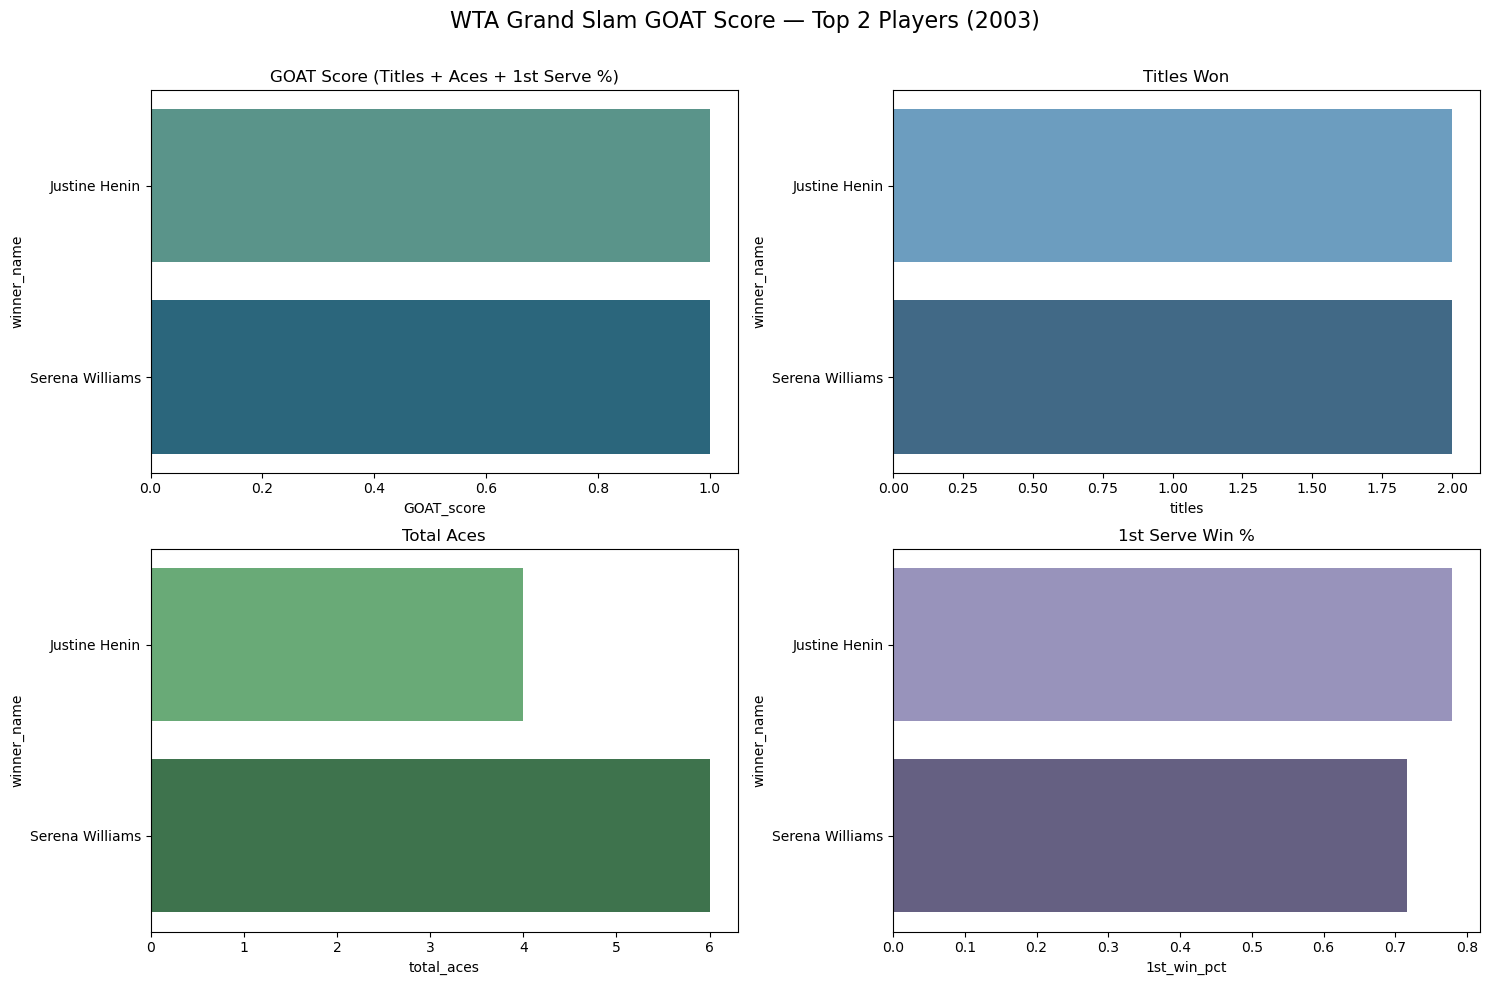

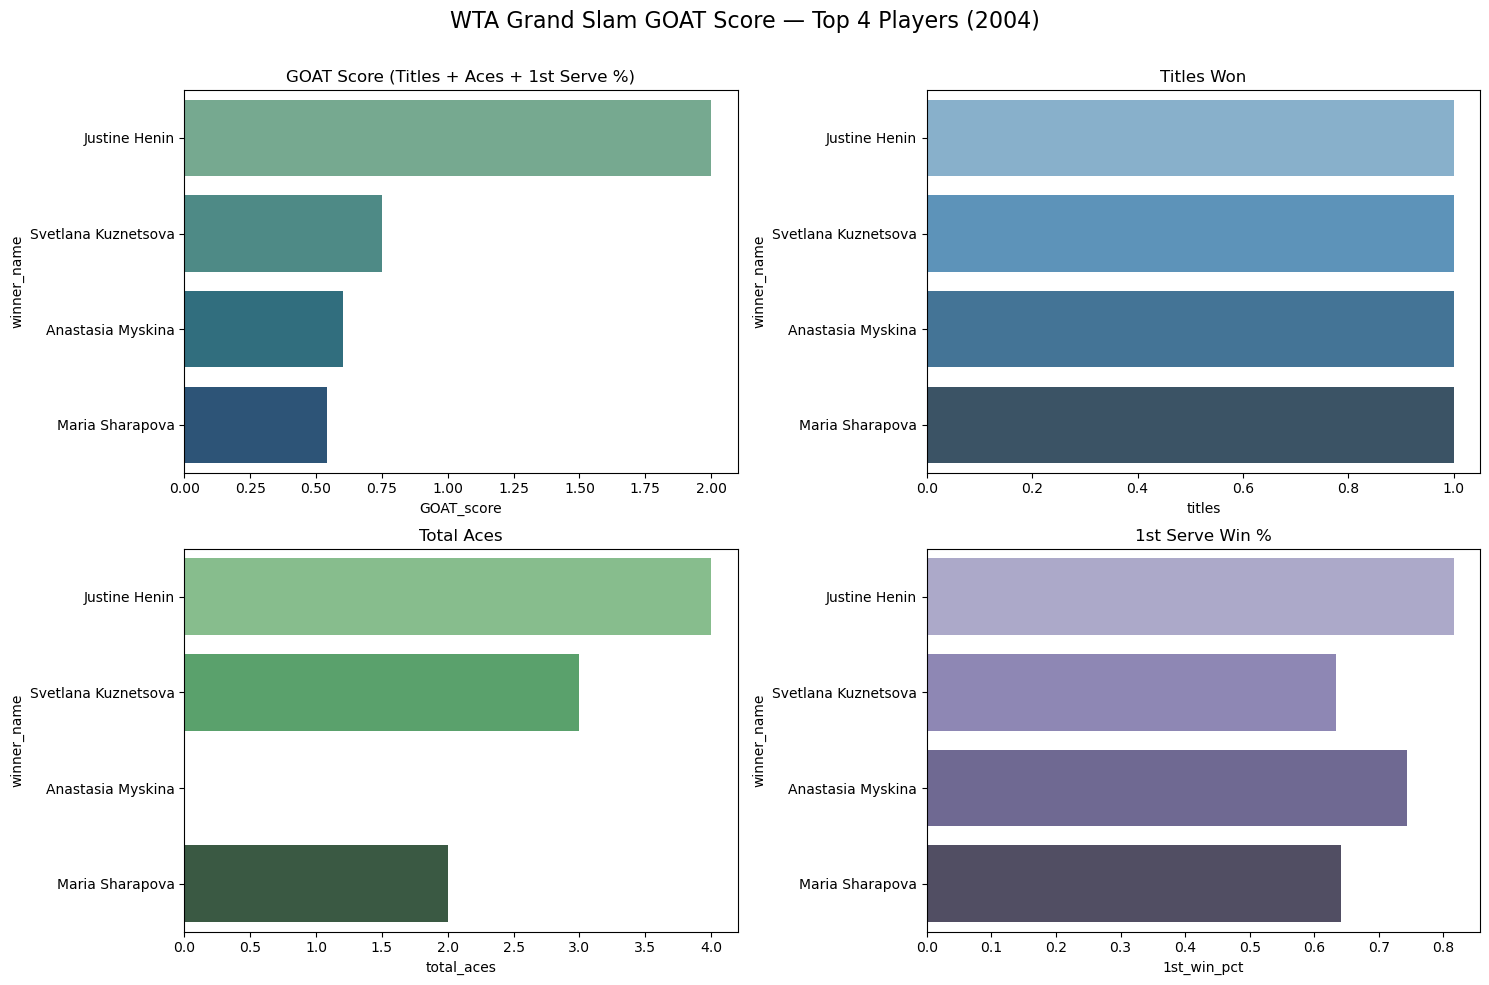

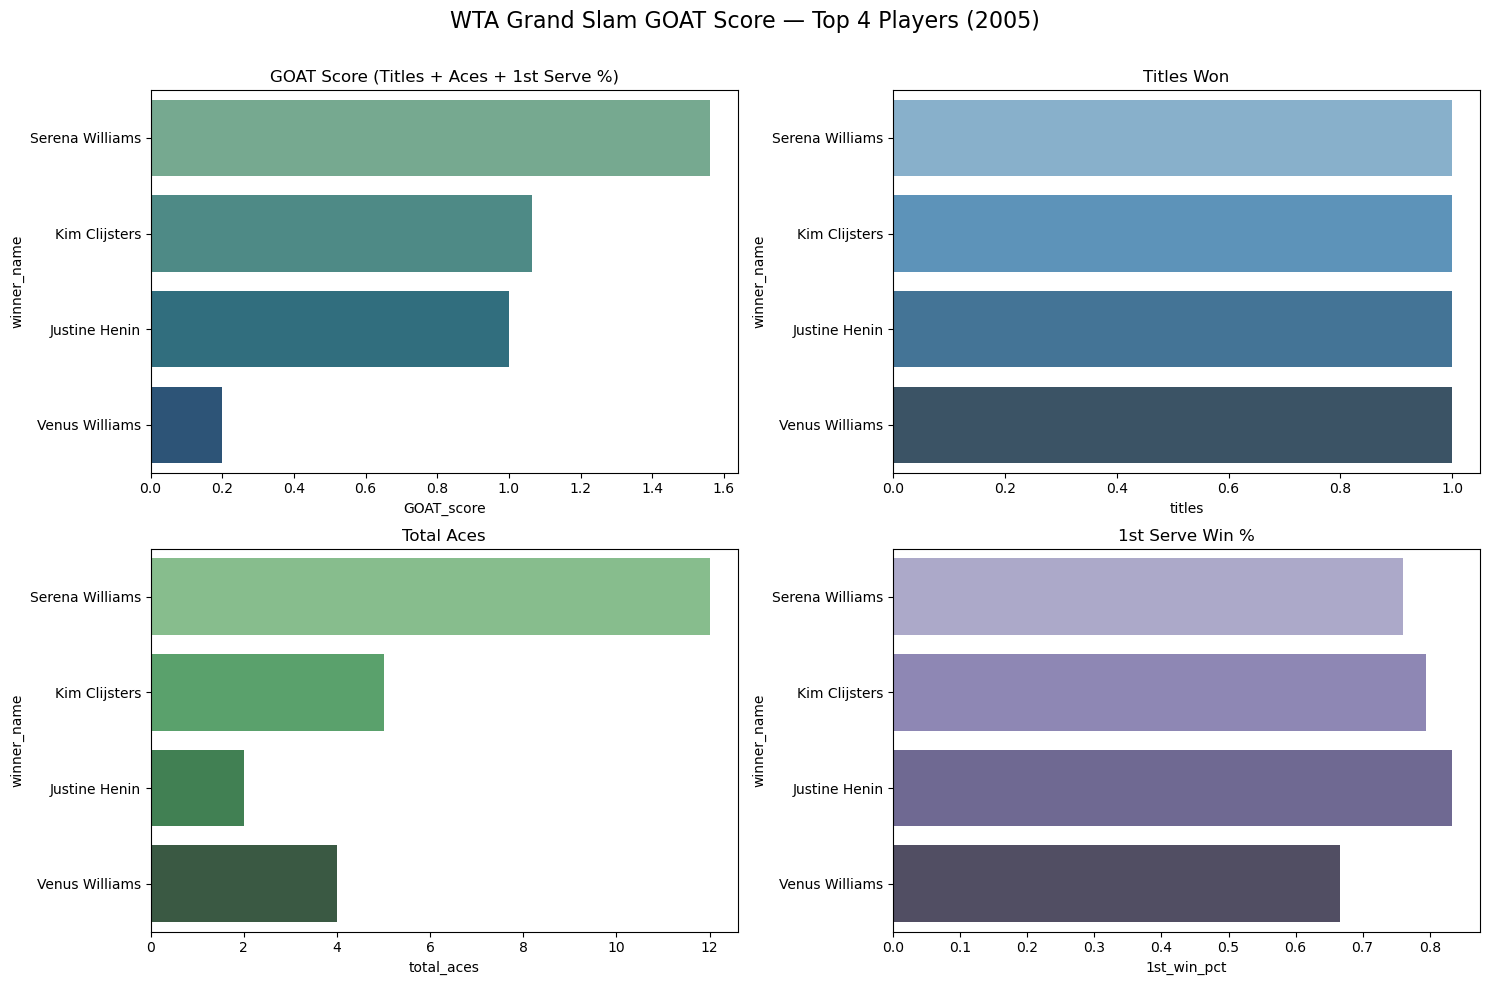

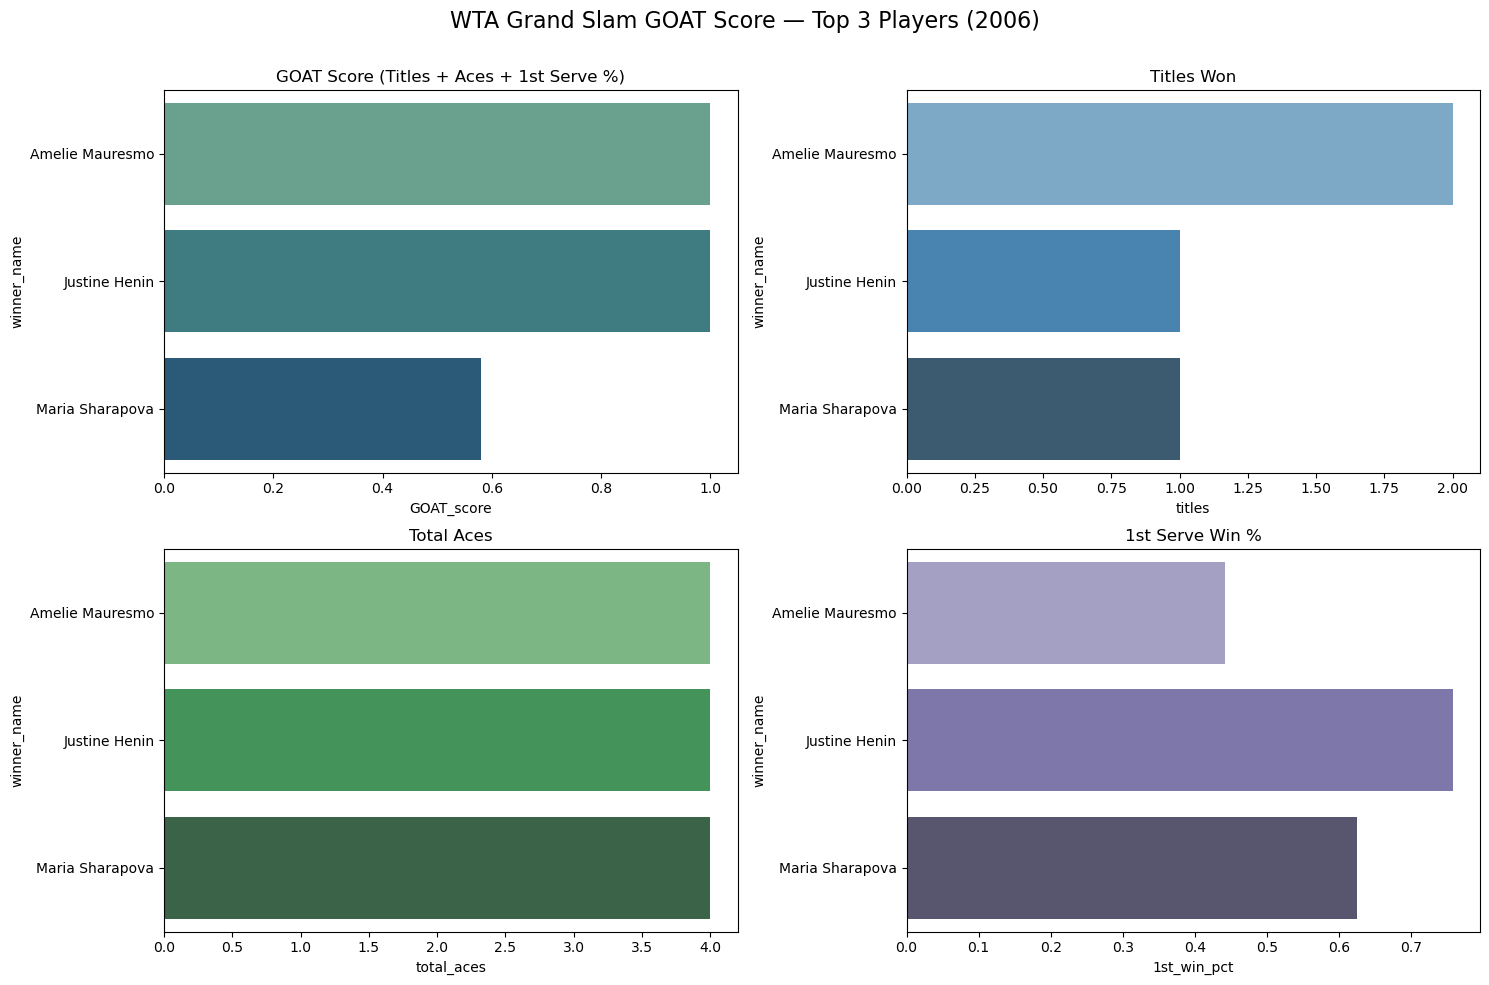

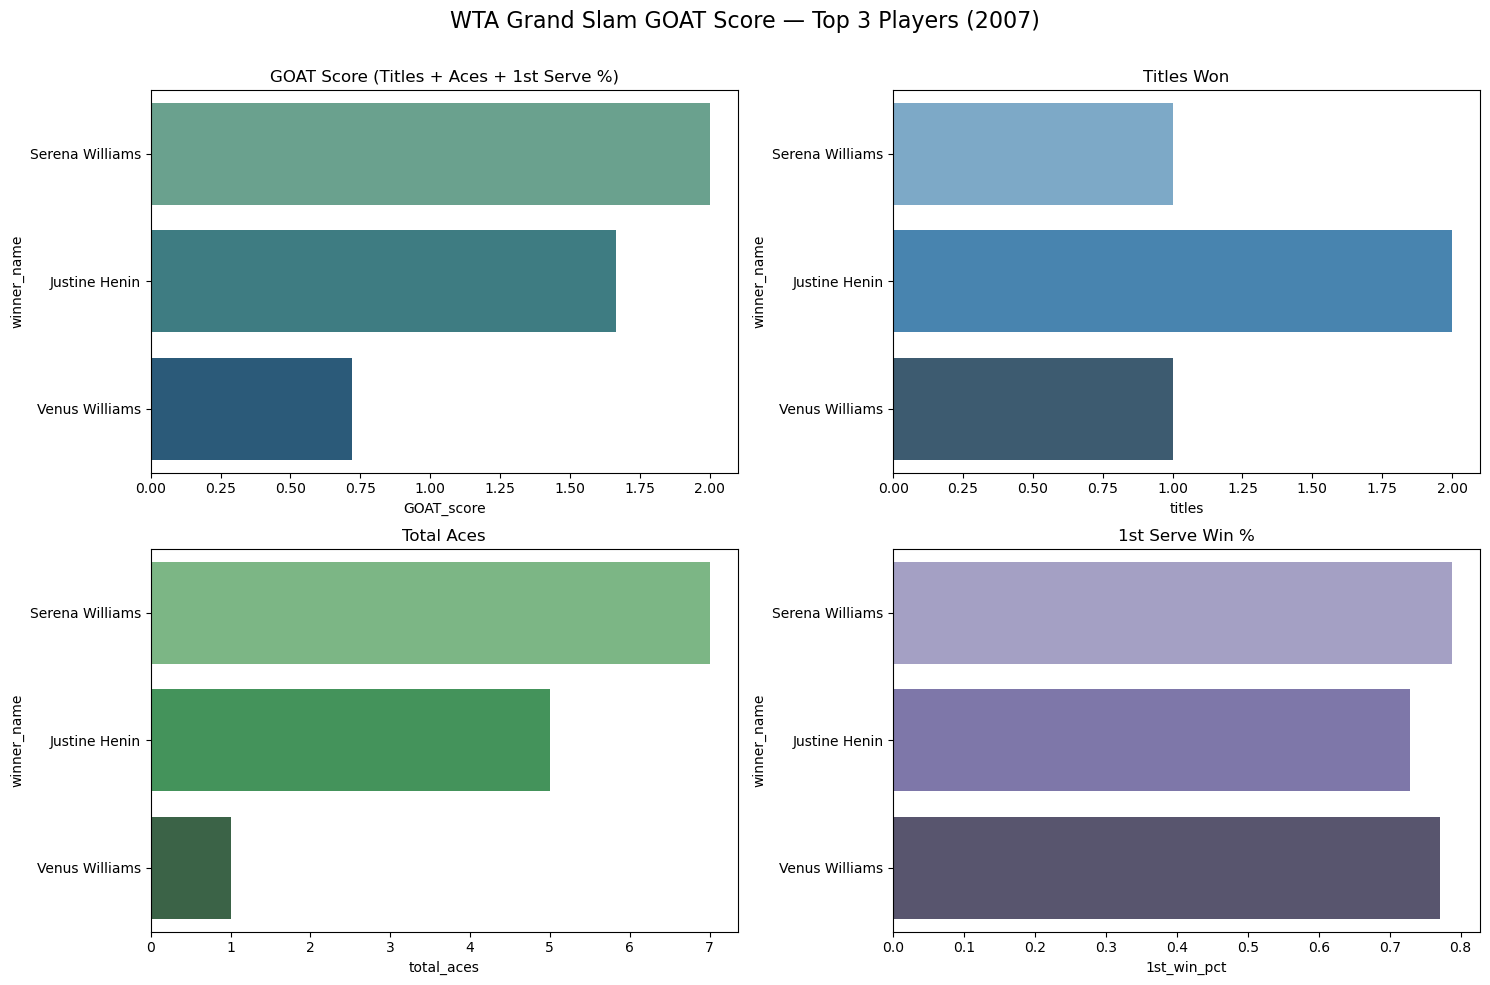

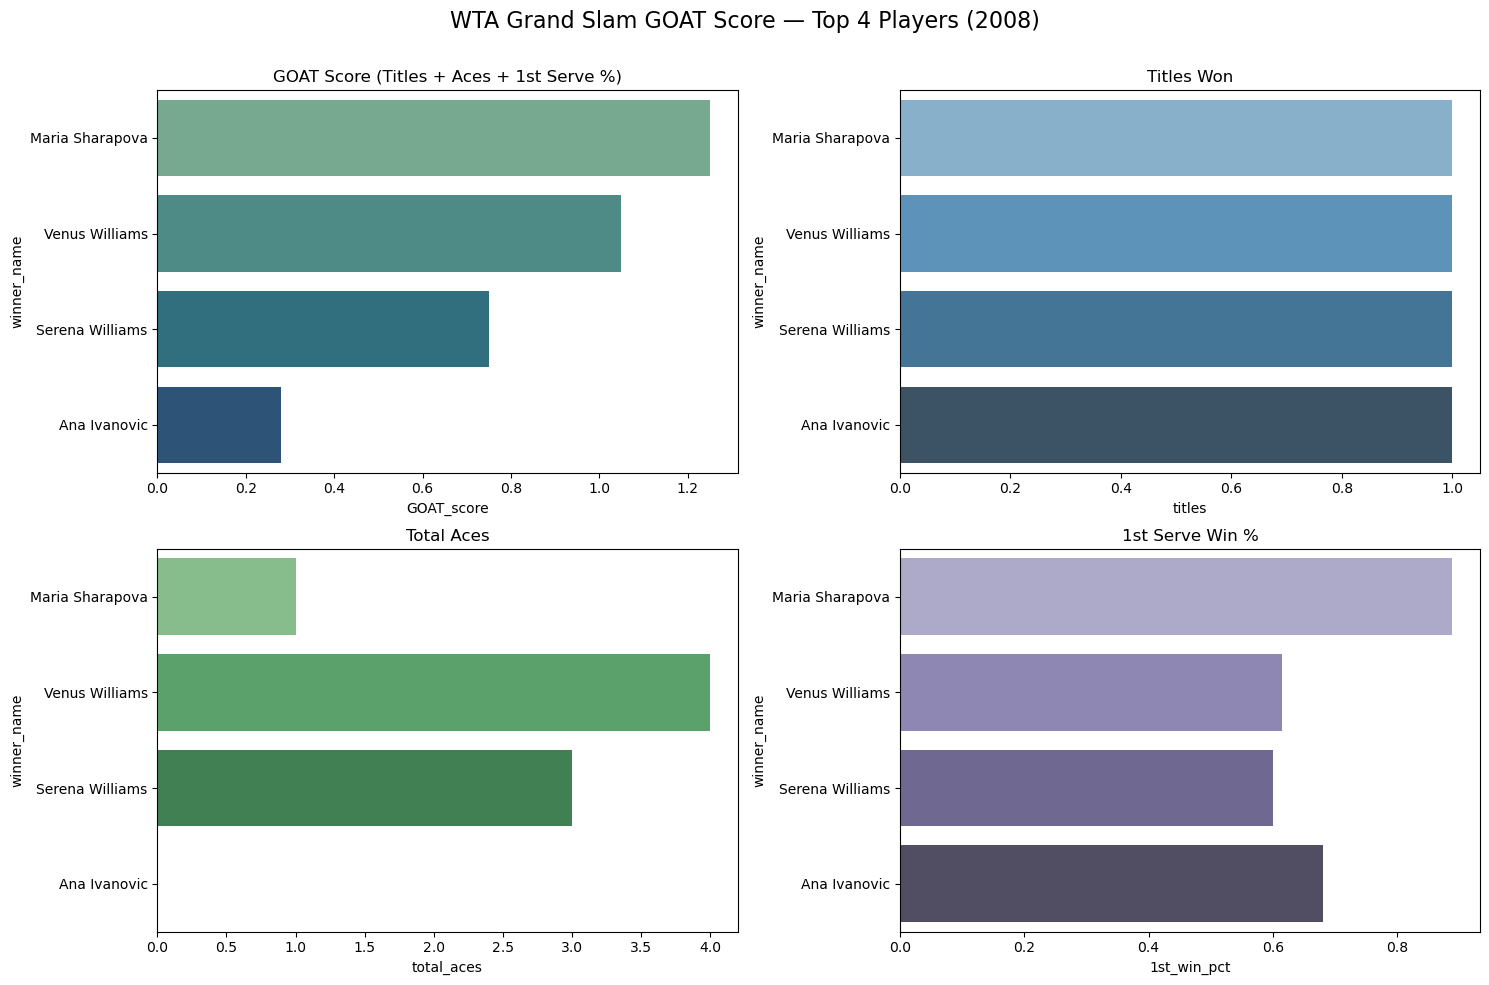

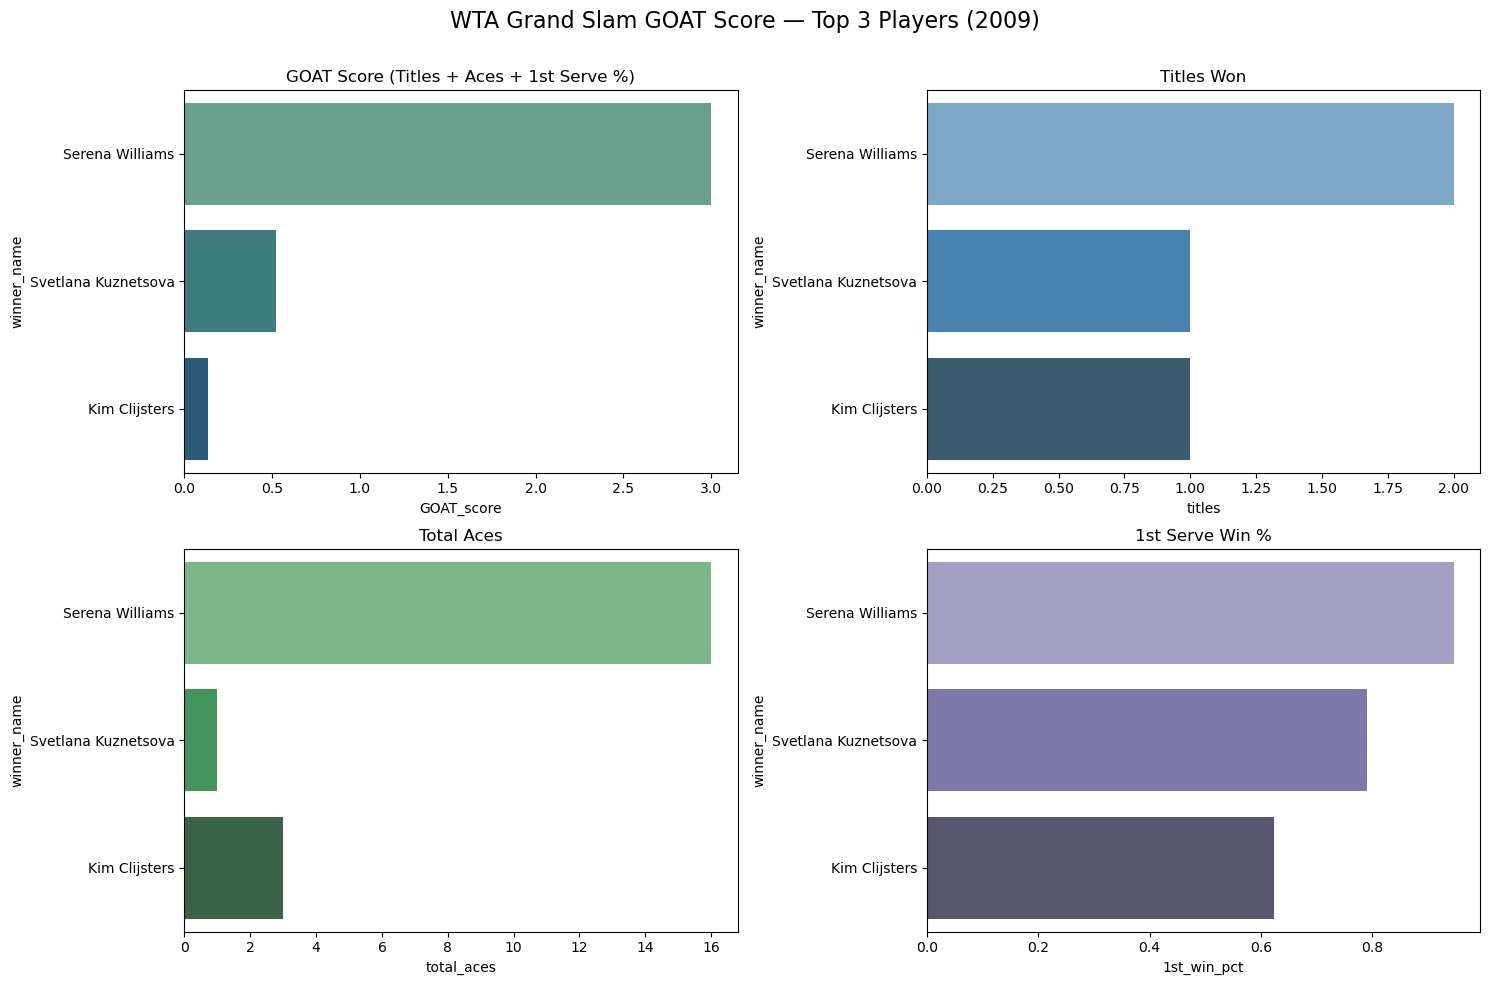

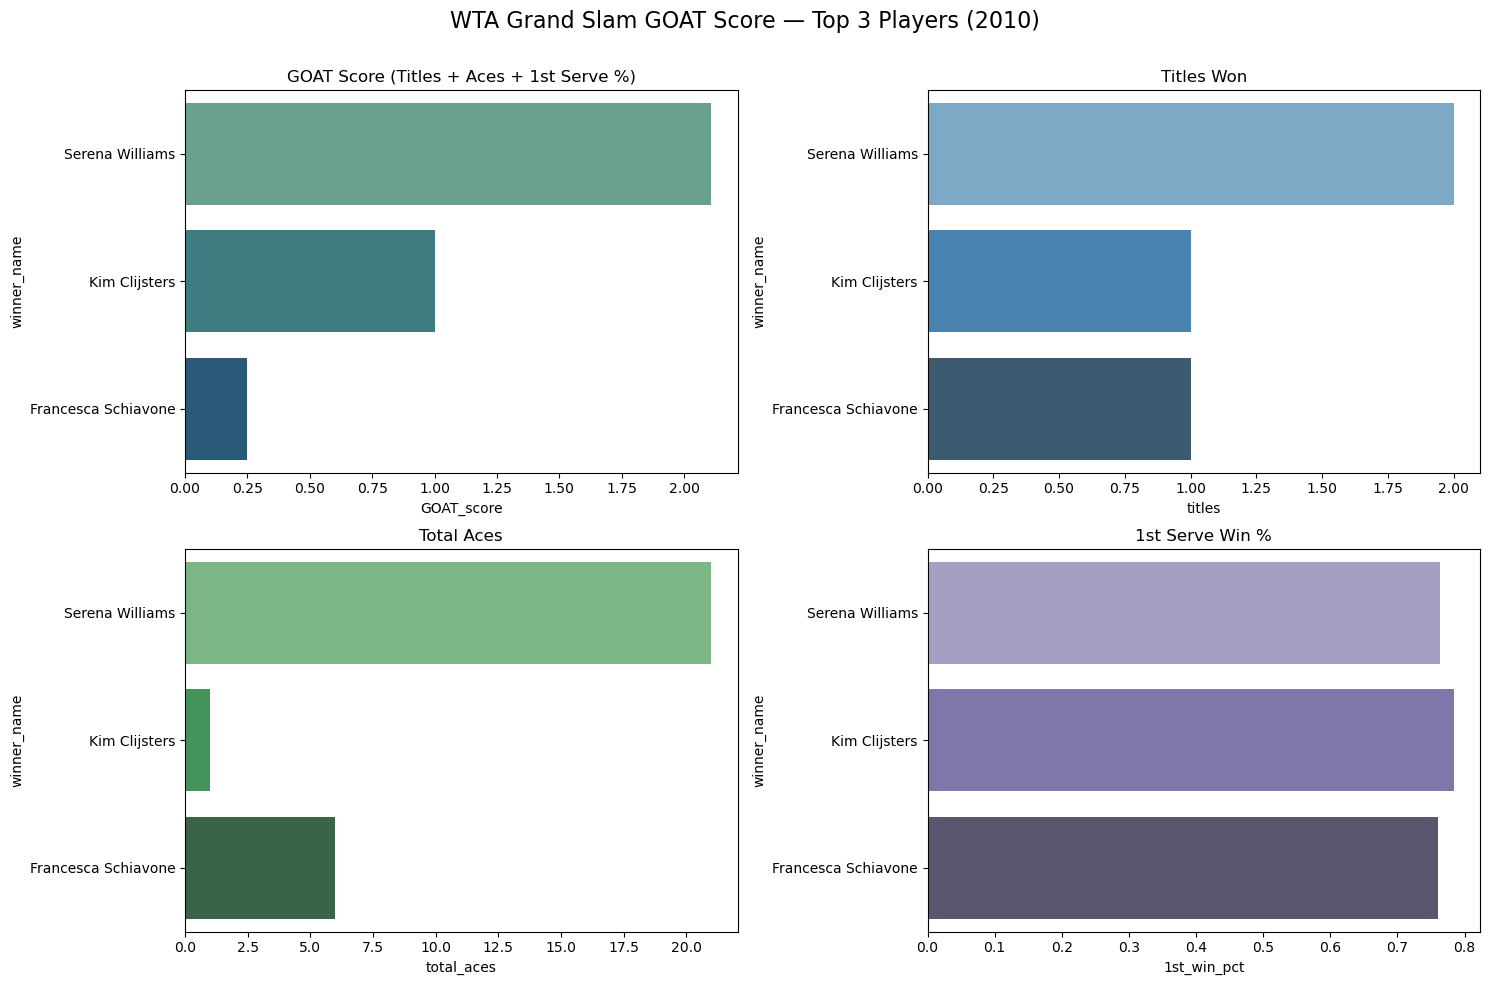

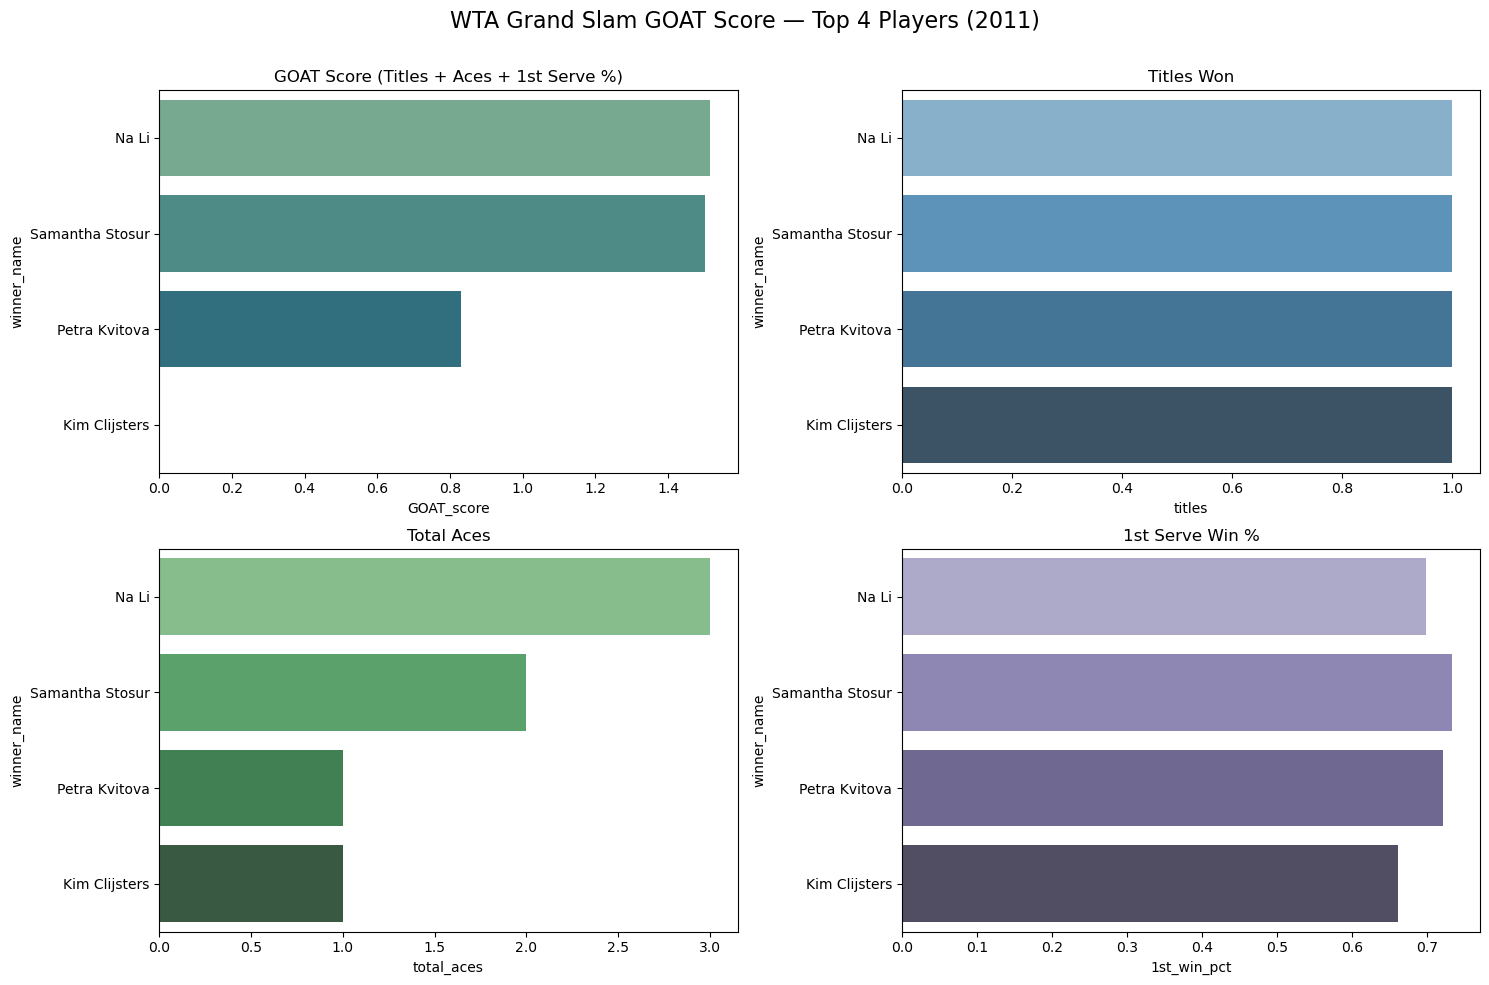

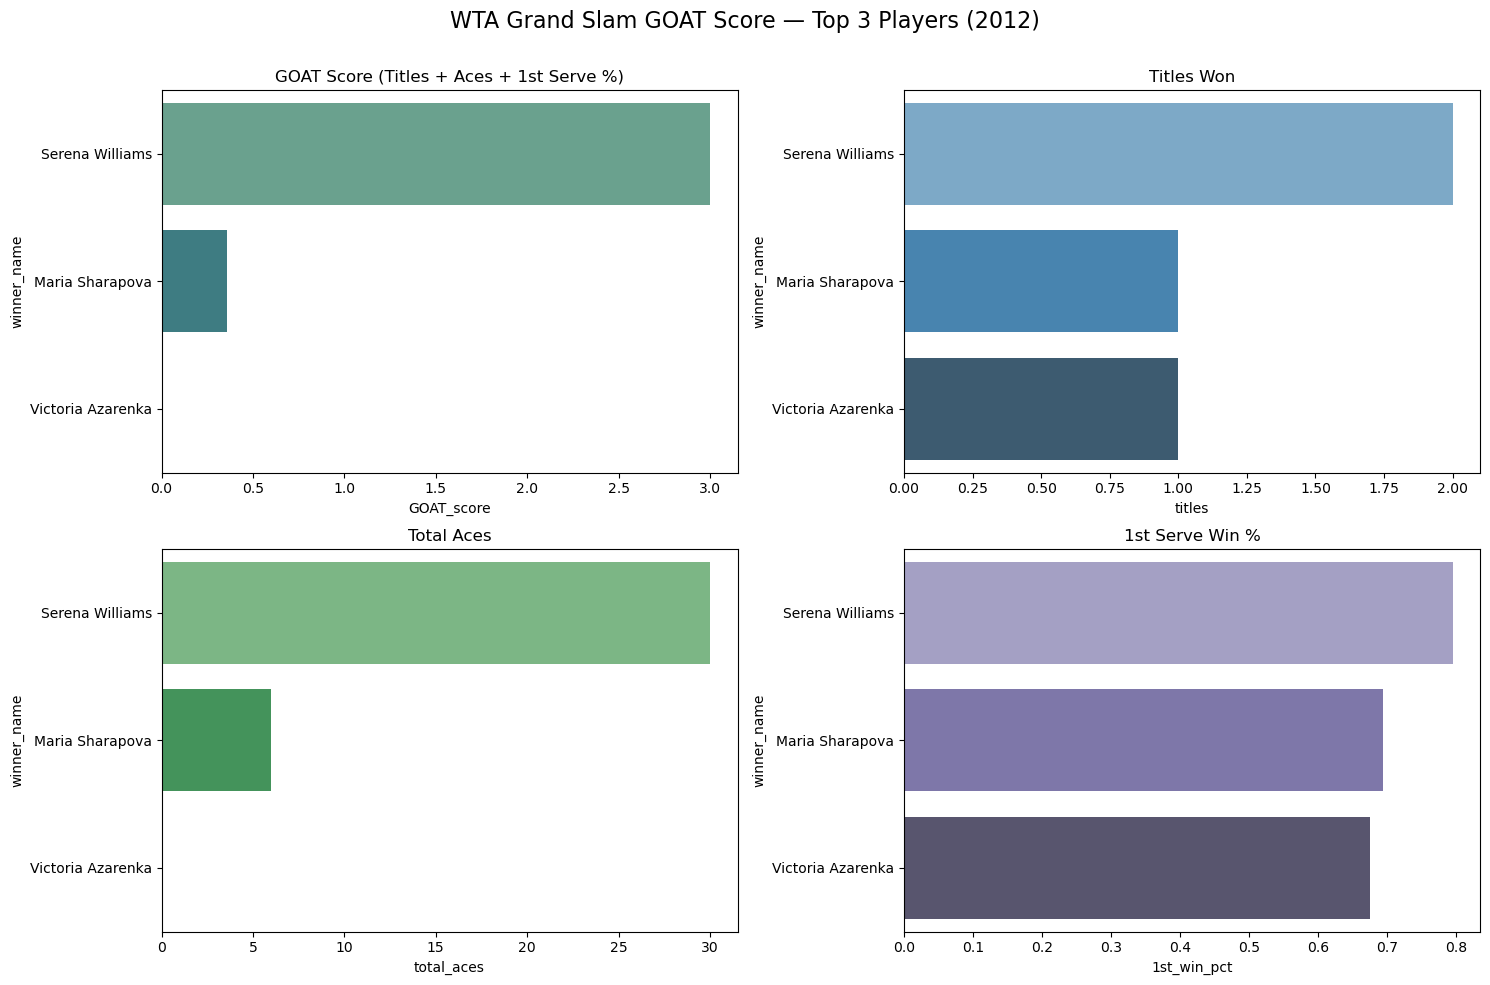

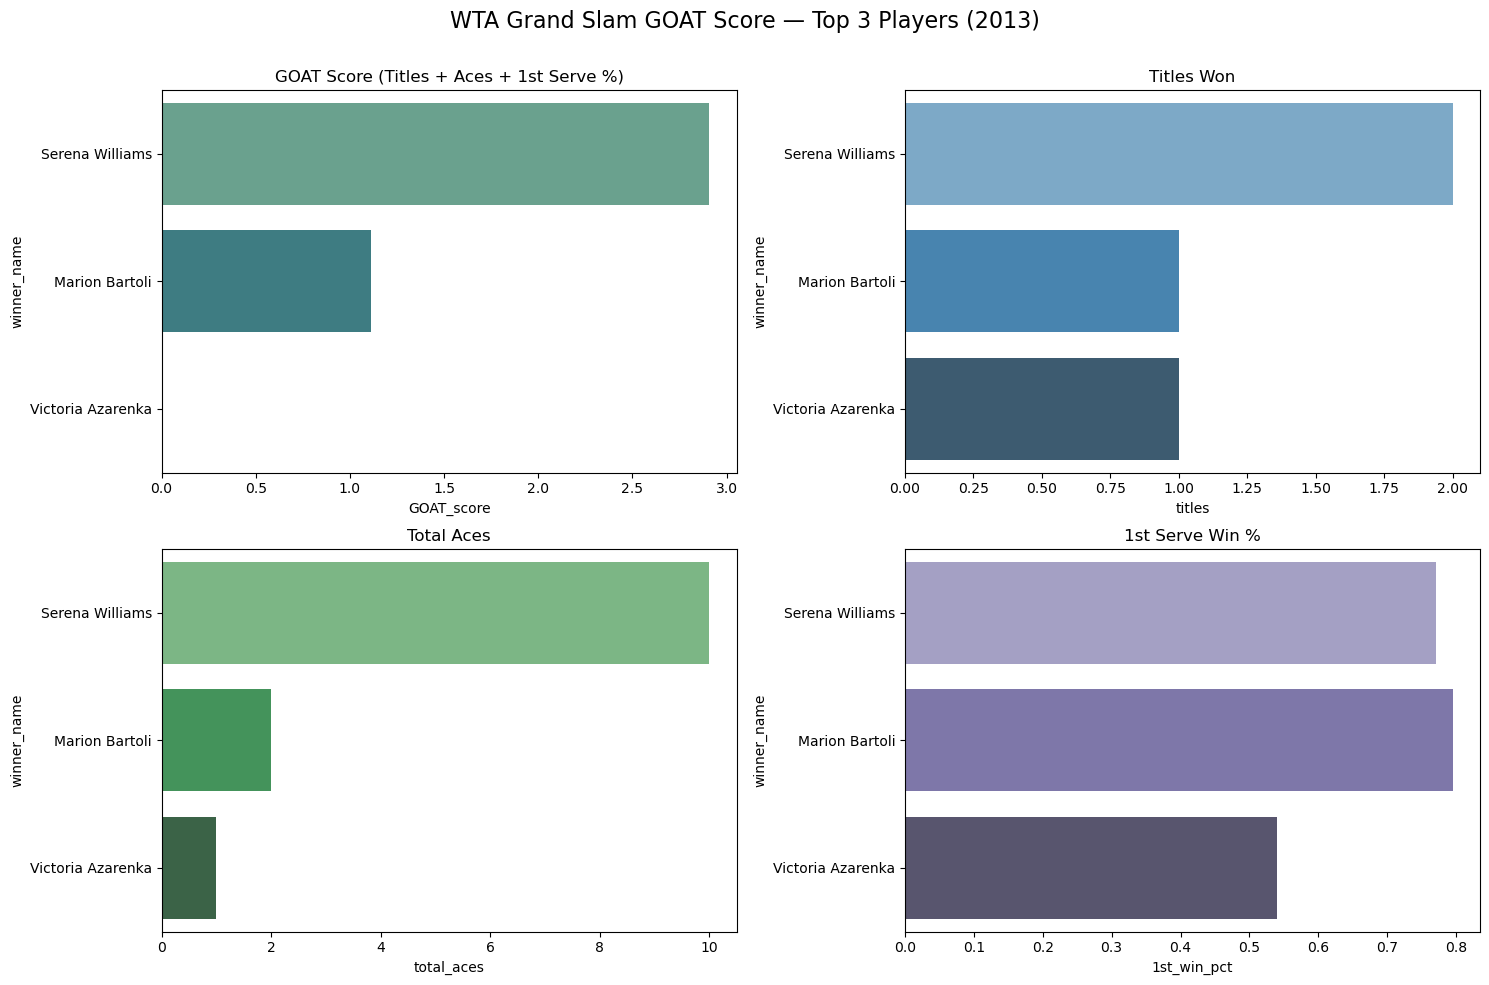

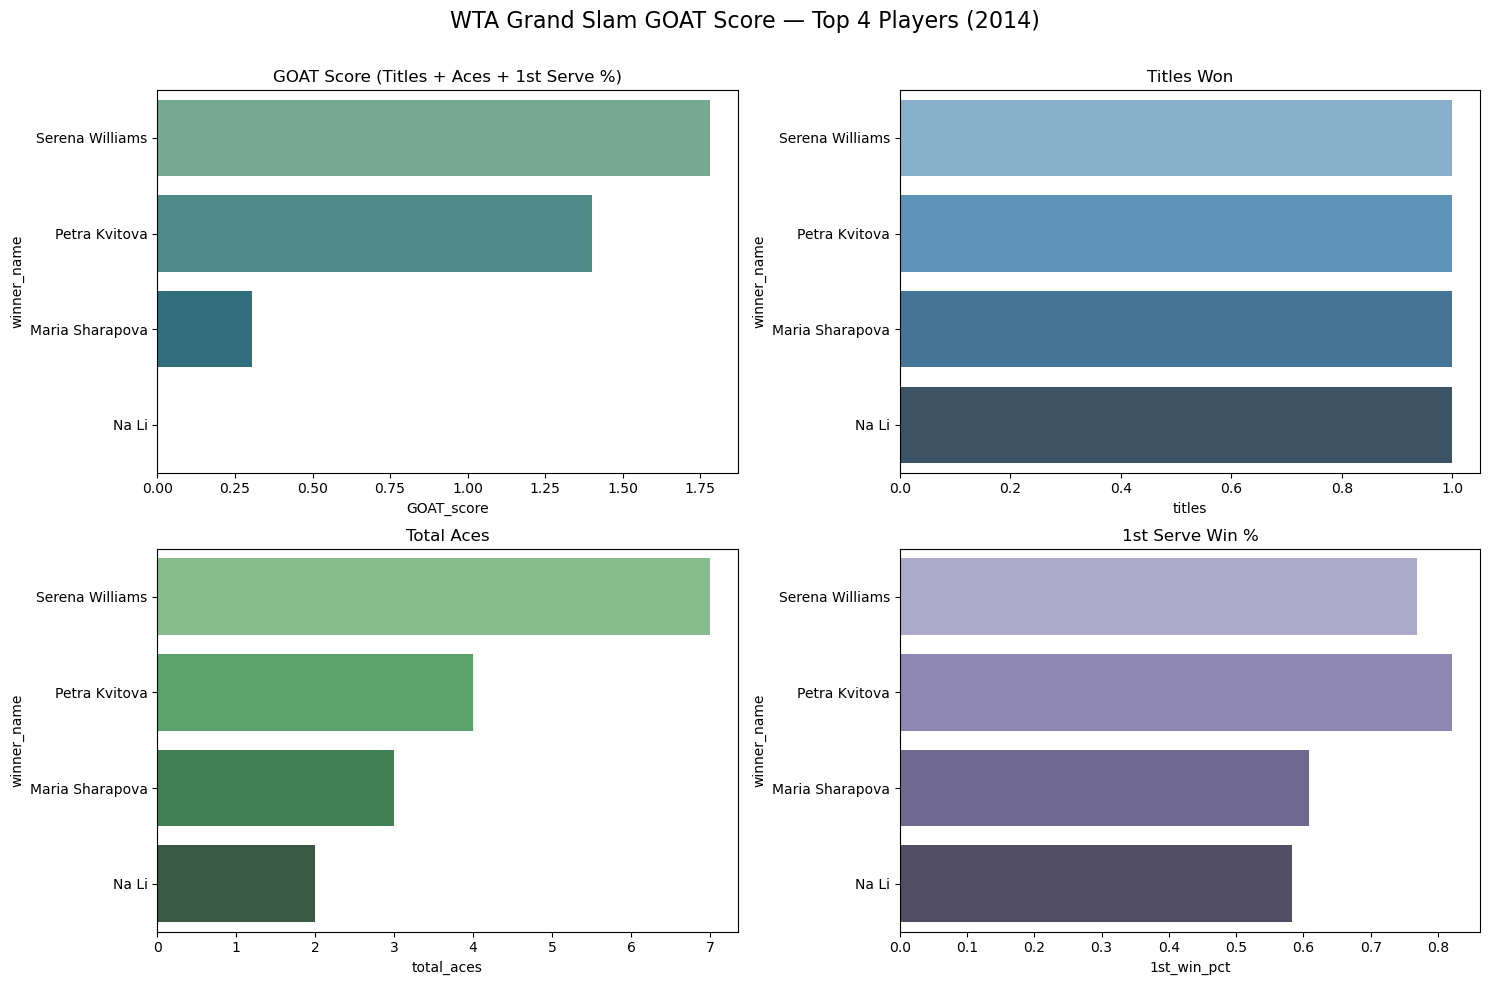

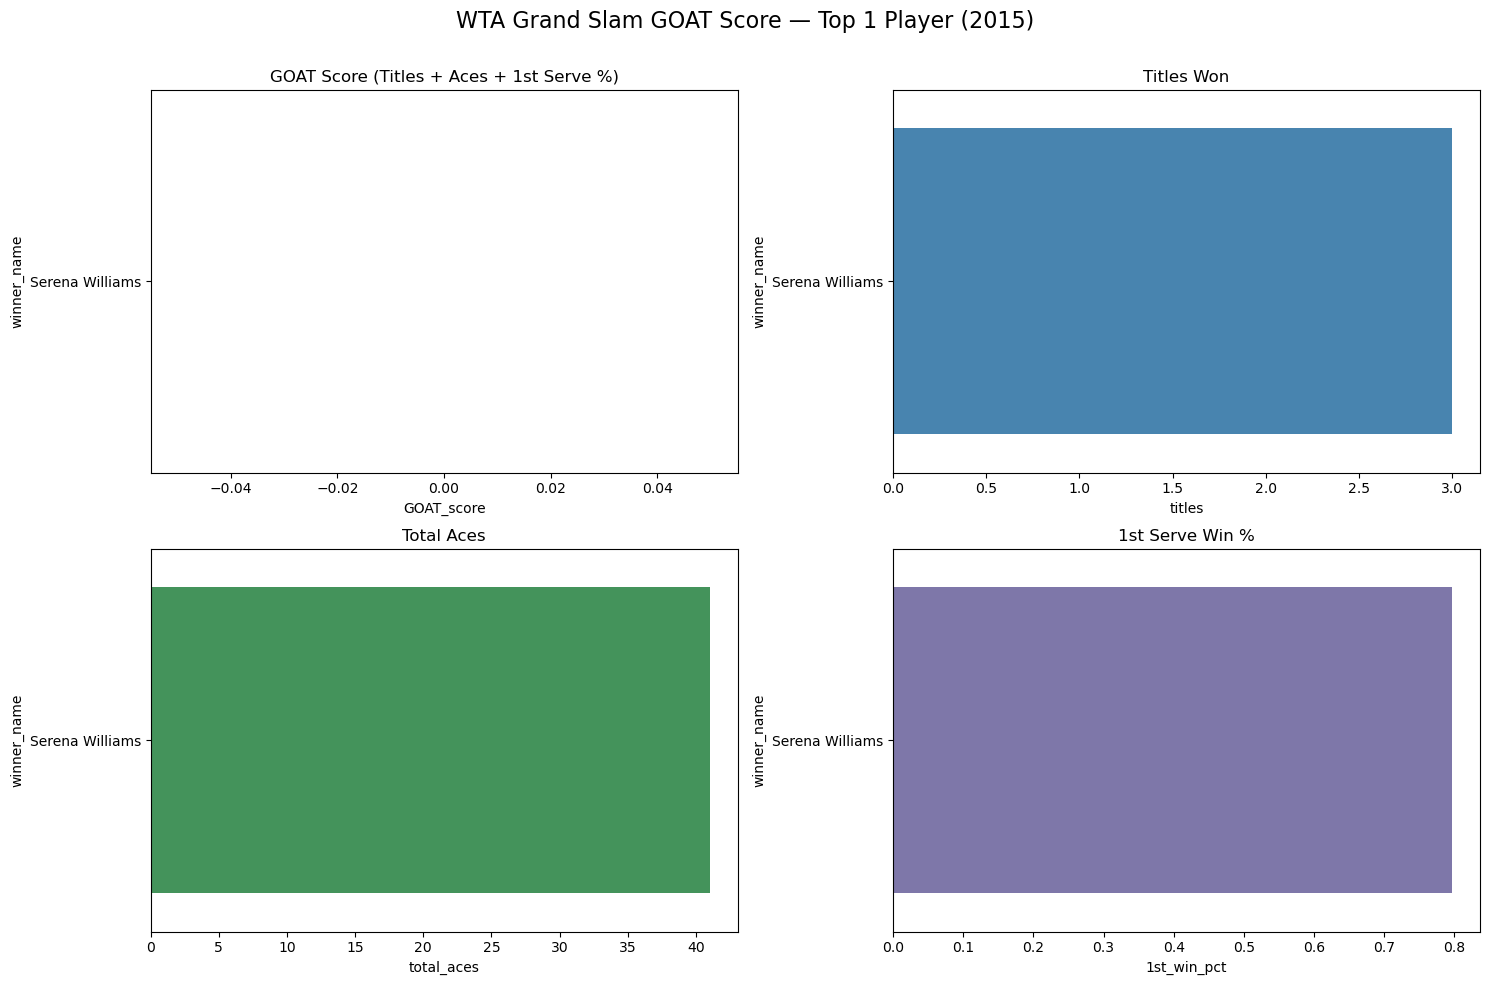

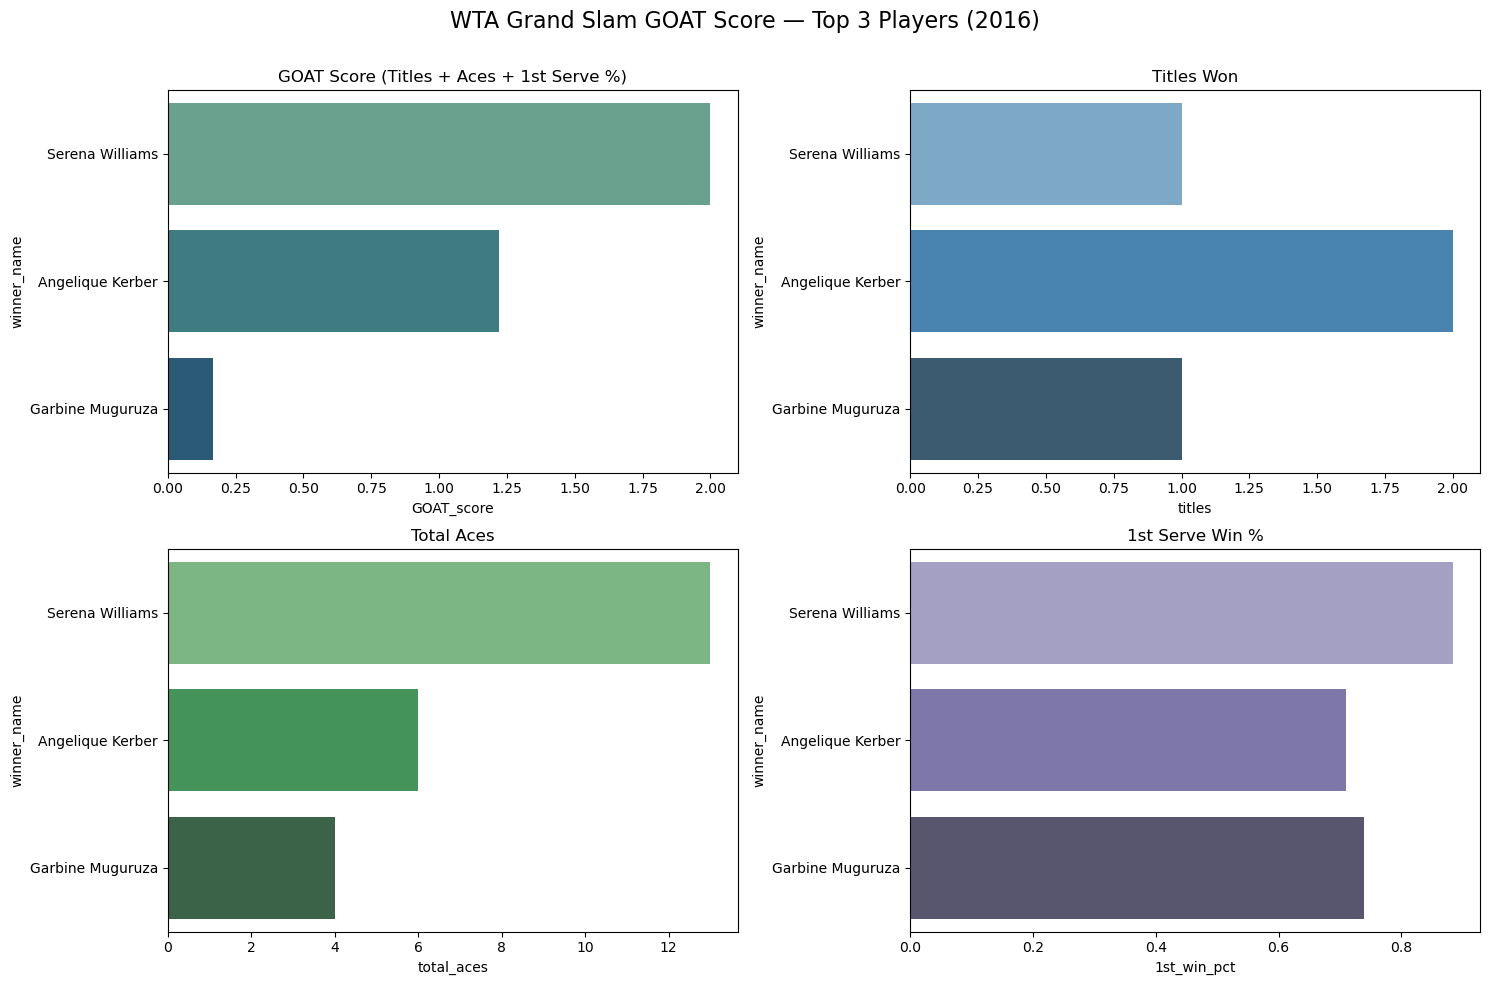

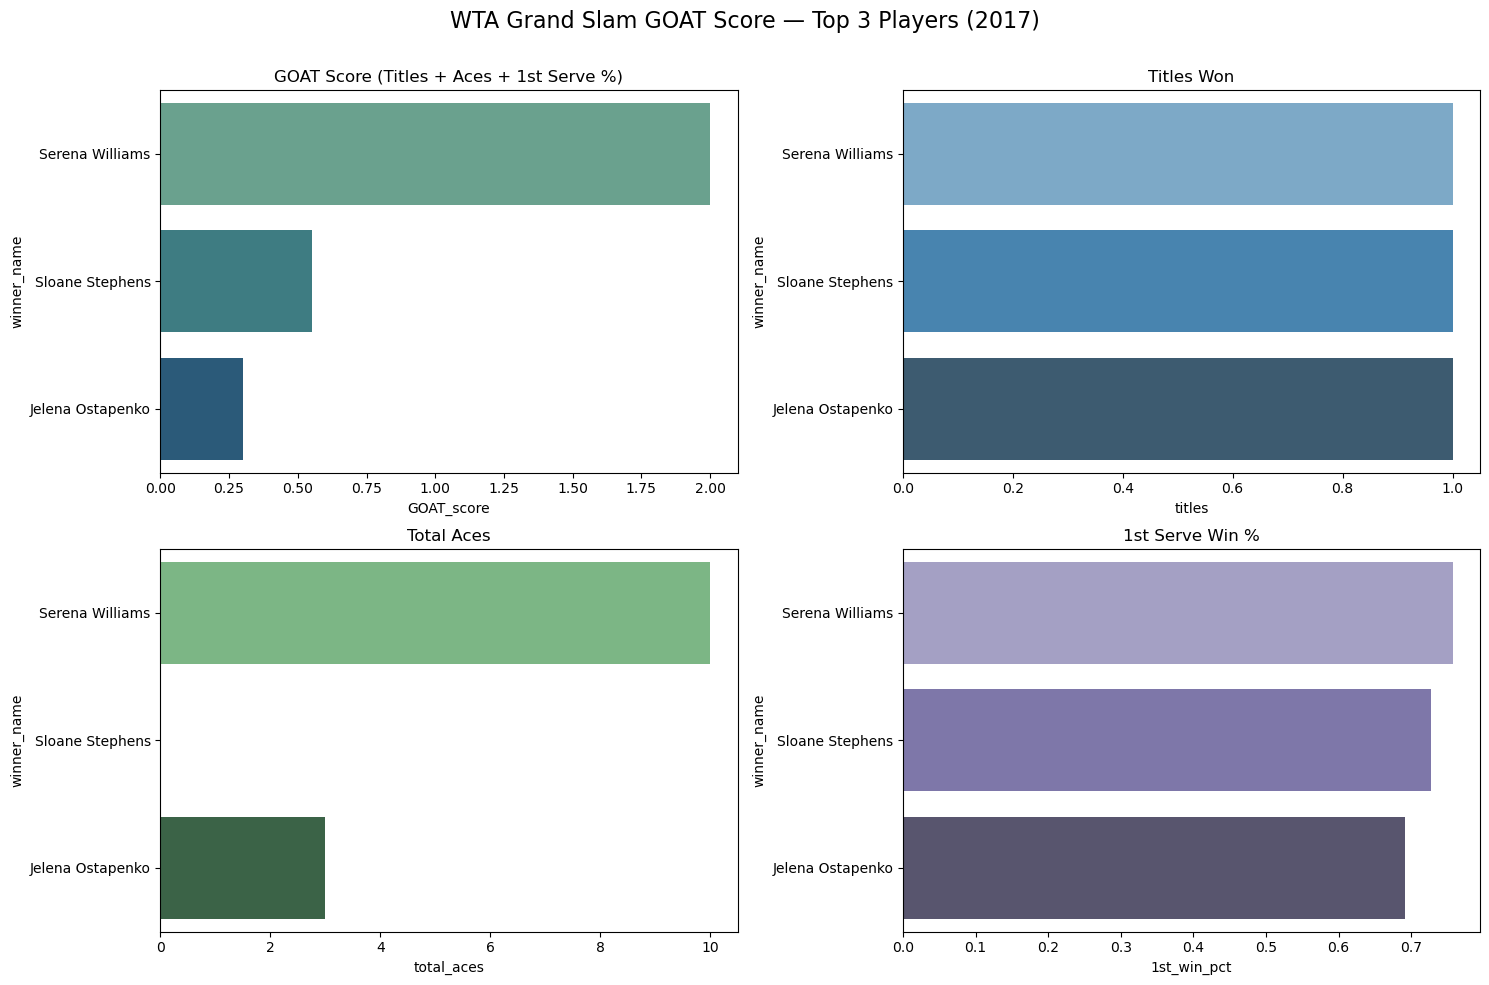

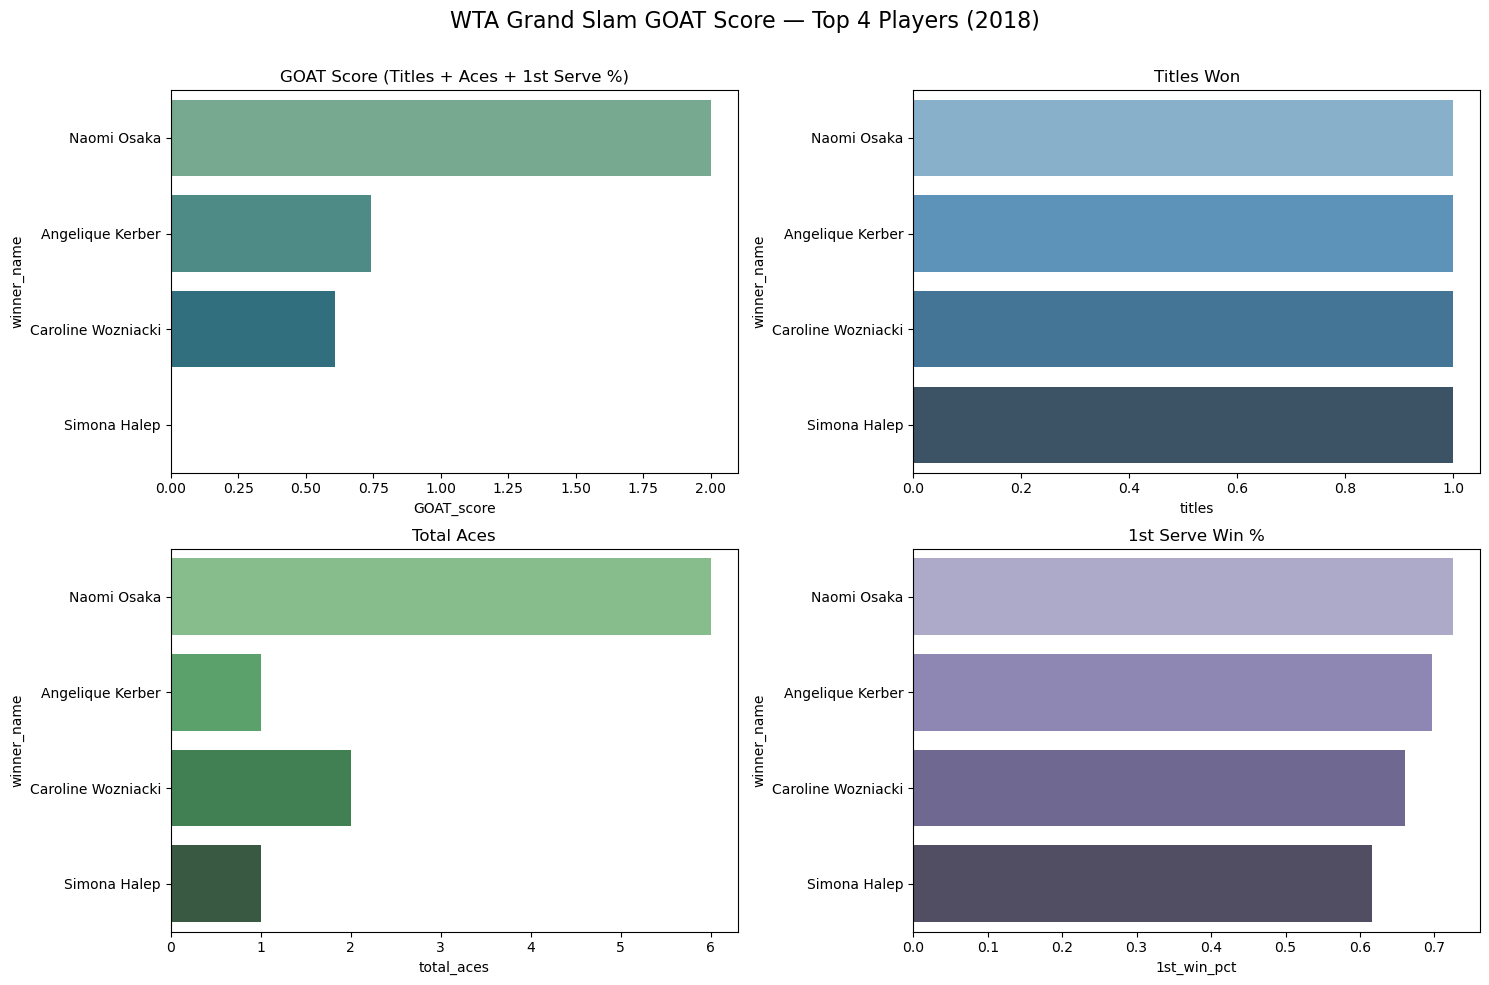

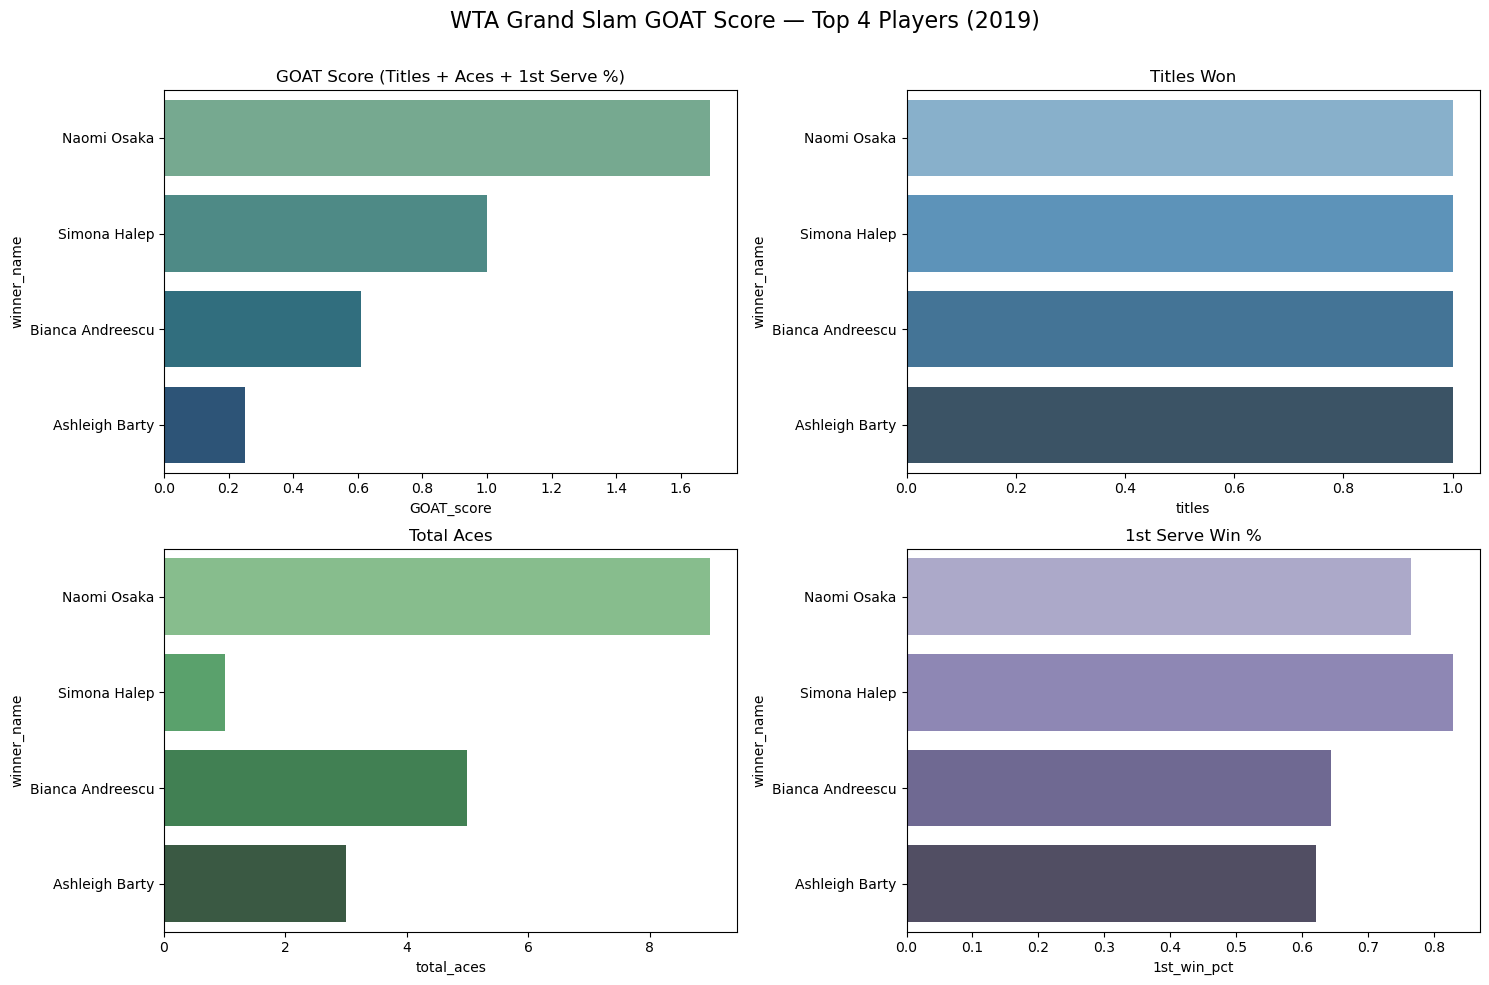

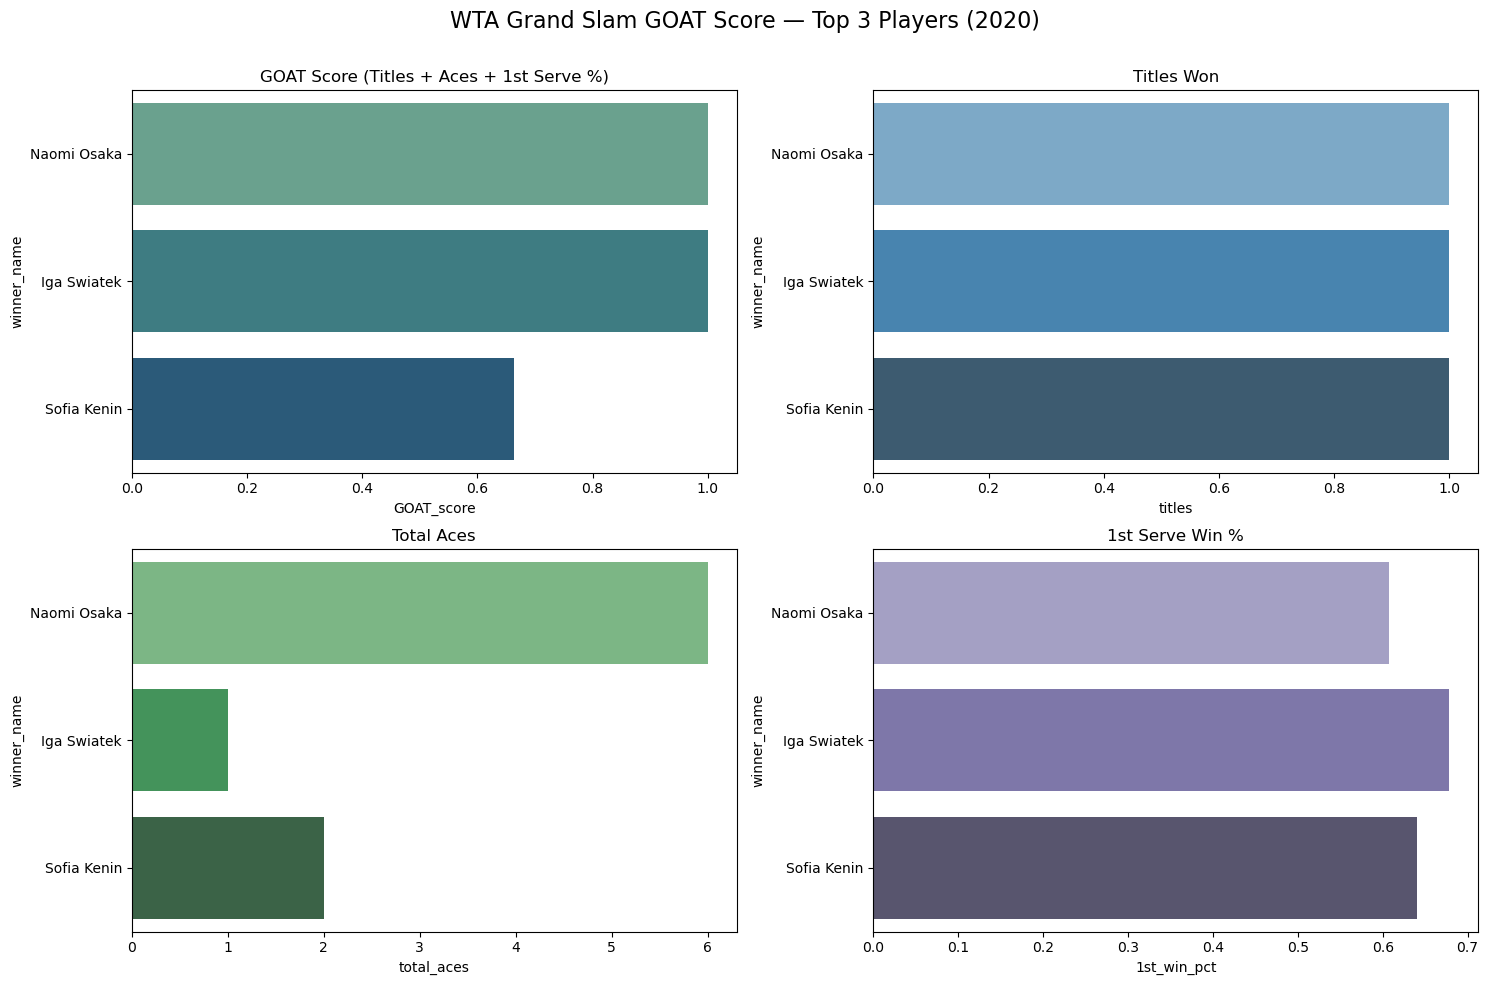

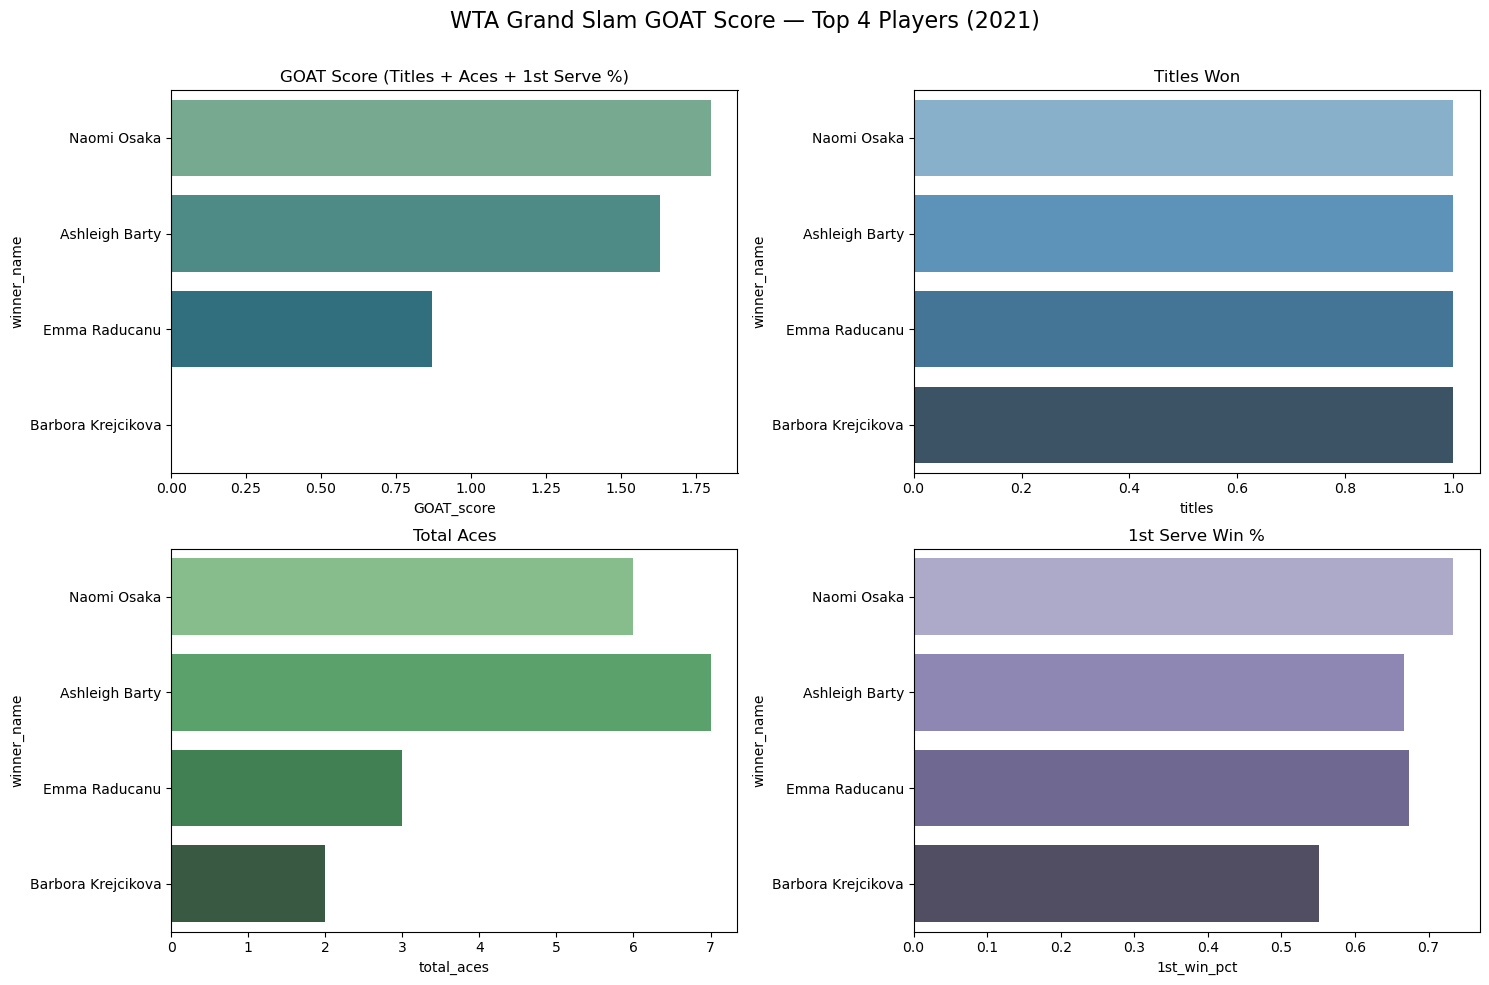

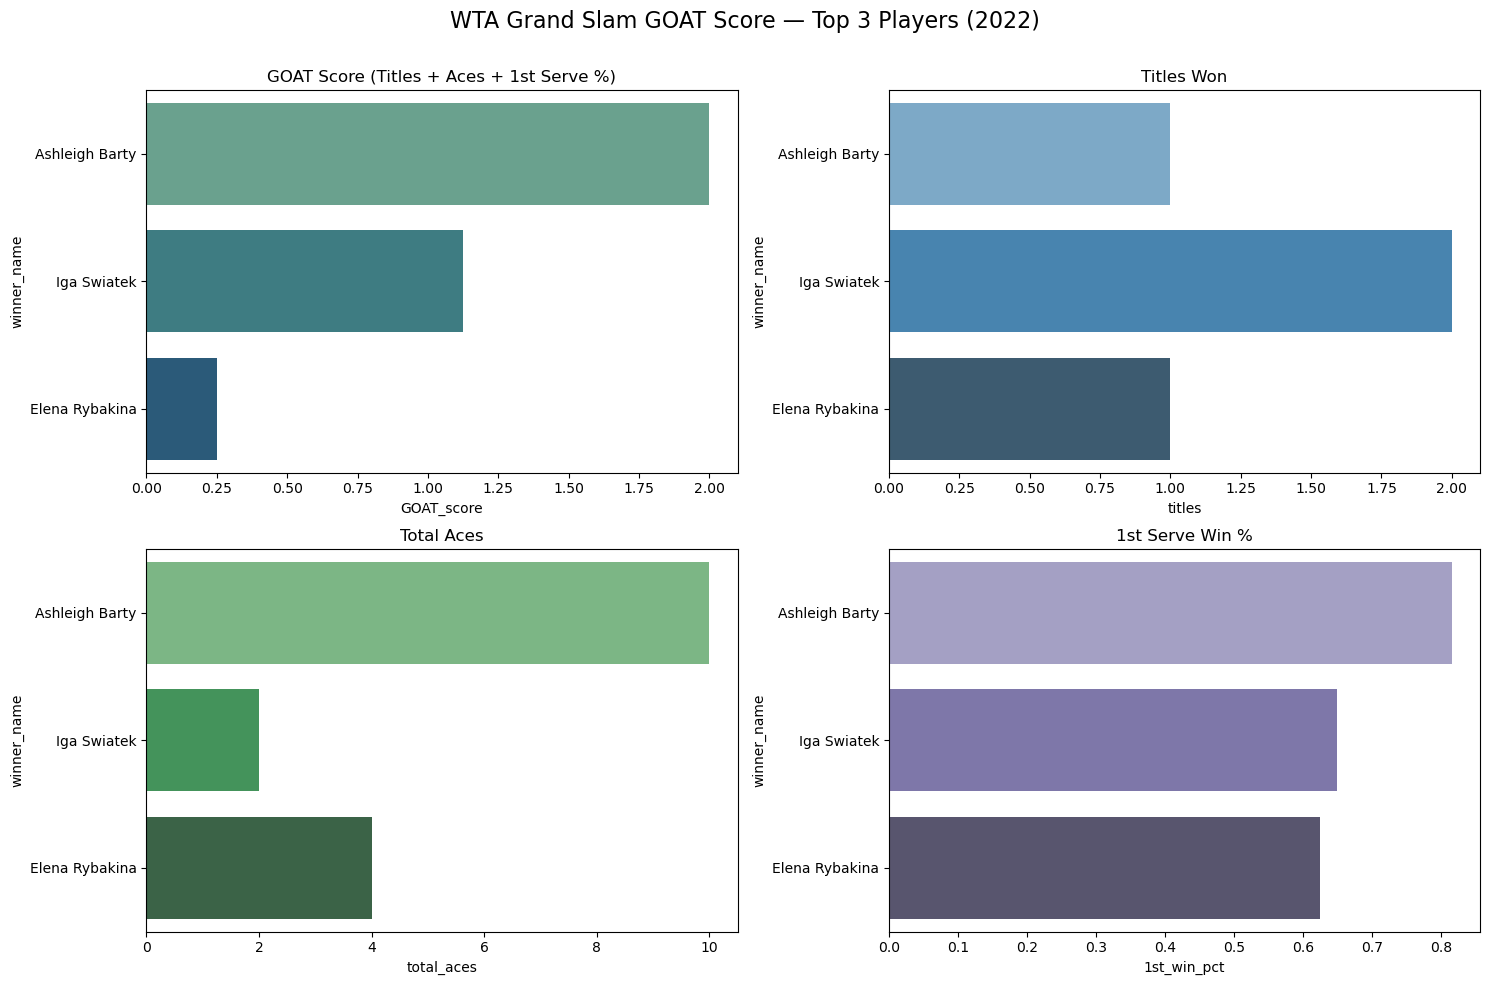

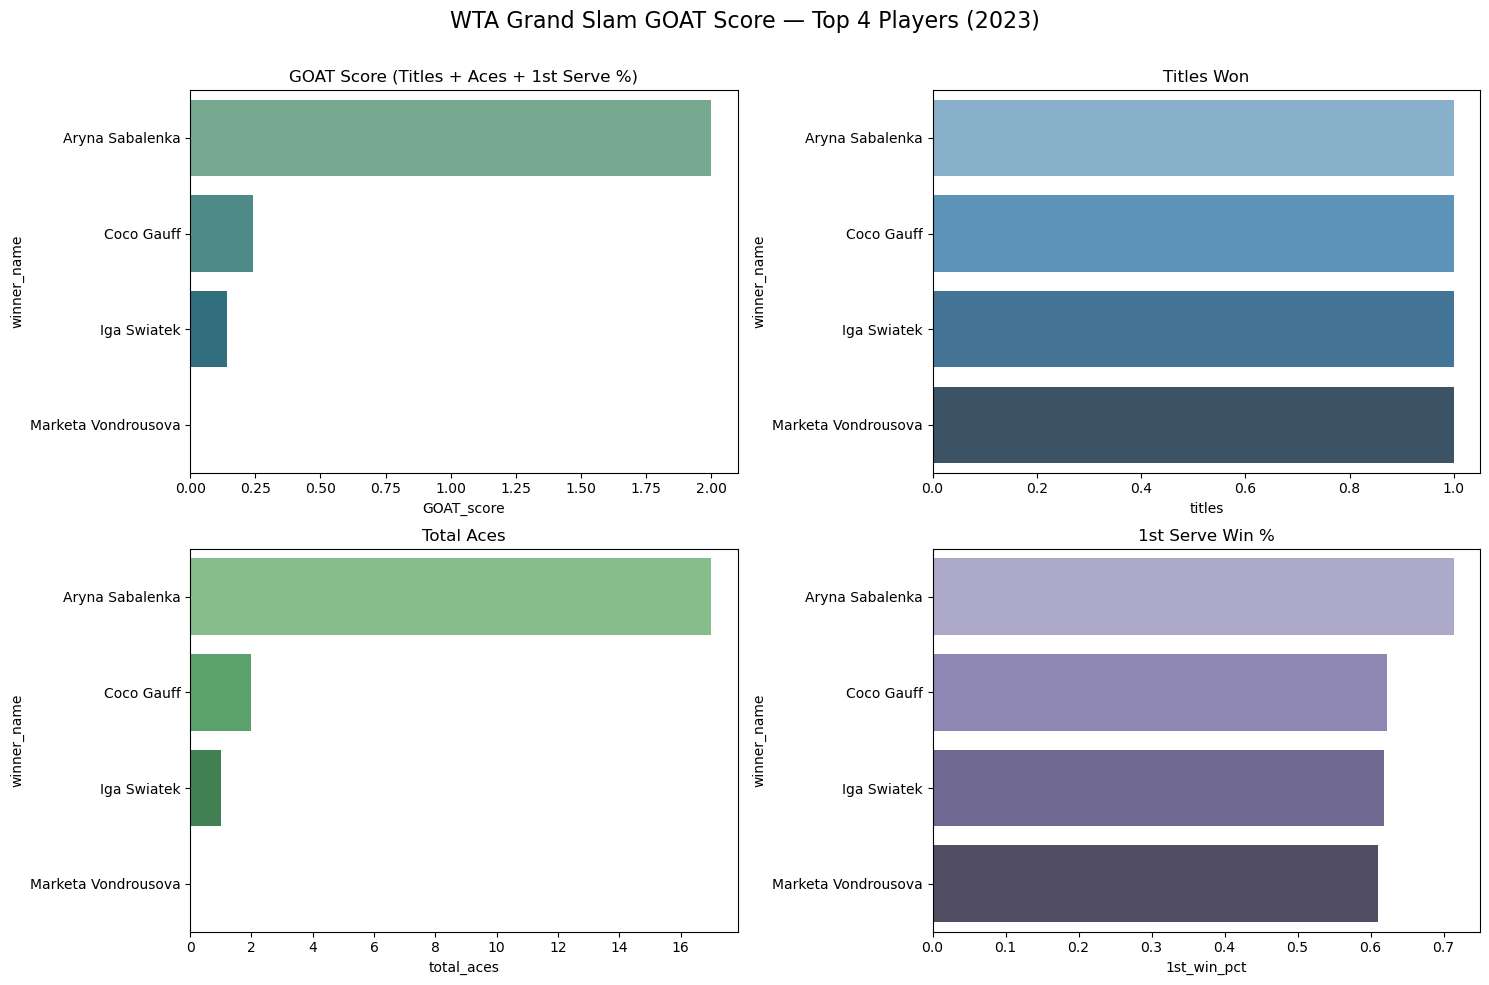

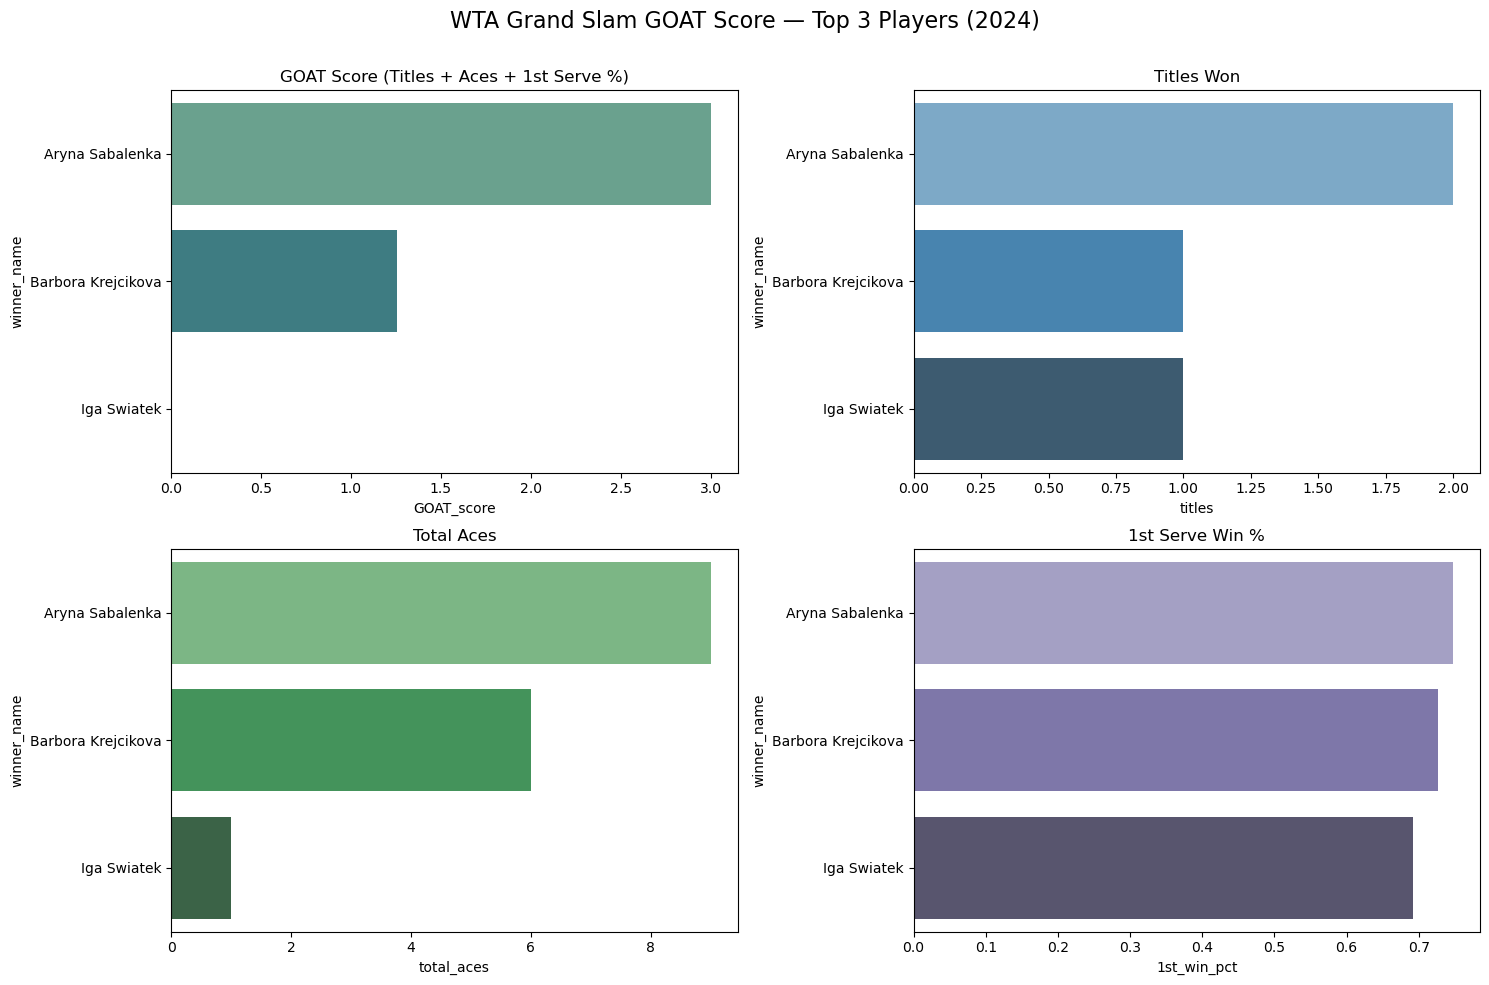

In [ ]:
# Plot GOAT score per year for all WTA Grand Slam final winners
for year in sorted(goat_data['year'].unique()):
    yearly_data = goat_data[goat_data['year'] == year]

    num_players = len(yearly_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'WTA Grand Slam GOAT Score — Top {num_players} Player{"s" if num_players > 1 else ""} ({year})', fontsize=16)

    # Plot 1: GOAT Score Bar
    sns.barplot(
        data=yearly_data,
        x='GOAT_score',
        y='winner_name',
        hue='winner_name',
        palette='crest',
        dodge=False,
        ax=axes[0, 0],
        legend=False
    )
    axes[0, 0].set_title('GOAT Score (Titles + Aces + 1st Serve %)')

    # Plot 2: Titles won
    sns.barplot(
        data=yearly_data,
        x='titles',
        y='winner_name',
        hue='winner_name',
        palette='Blues_d',
        dodge=False,
        ax=axes[0, 1],
        legend=False
    )
    axes[0, 1].set_title('Titles Won')

    # Plot 3: Total Aces
    sns.barplot(
        data=yearly_data,
        x='total_aces',
        y='winner_name',
        hue='winner_name',
        palette='Greens_d',
        dodge=False,
        ax=axes[1, 0],
        legend=False
    )
    axes[1, 0].set_title('Total Aces')

    # Plot 4: 1st Serve Win Percentage
    sns.barplot(
        data=yearly_data,
        x='1st_win_pct',
        y='winner_name',
        hue='winner_name',
        palette='Purples_d',
        dodge=False,
        ax=axes[1, 1],
        legend=False
    )
    axes[1, 1].set_title('1st Serve Win %')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


In [11]:
# Group by player to aggregate Grand Slam final stats
slam_goat_stats = slam_finals.groupby('winner_name').agg(
    total_titles = ('winner_name', 'count'),  # Count of finals won
    total_aces = ('w_ace', 'sum'),
    total_1st_won = ('w_1stWon', 'sum'),
    total_1st_in = ('w_1stIn', 'sum')
).reset_index()

# Derived stat: 1st serve win %
slam_goat_stats['1st_win_pct'] = slam_goat_stats['total_1st_won'] / slam_goat_stats['total_1st_in']
slam_goat_stats['1st_win_pct'] = slam_goat_stats['1st_win_pct'].fillna(0)

# Normalize and compute GOAT score
scaler = MinMaxScaler()

slam_goat_stats['titles_norm'] = scaler.fit_transform(slam_goat_stats[['total_titles']])
slam_goat_stats['aces_norm'] = scaler.fit_transform(slam_goat_stats[['total_aces']])
slam_goat_stats['serve_norm'] = scaler.fit_transform(slam_goat_stats[['1st_win_pct']])

# Combine metrics into GOAT score
slam_goat_stats['GOAT_score'] = (
    slam_goat_stats['titles_norm'] +
    slam_goat_stats['aces_norm'] +
    slam_goat_stats['serve_norm']
)

# Rank players
slam_goat_stats = slam_goat_stats.sort_values(by='GOAT_score', ascending=False)
slam_goat_stats['GOAT_rank'] = slam_goat_stats.reset_index().index + 1

# Display result
print("All-Time WTA Grand Slam GOAT Rankings — Based on Titles, Aces, and 1st Serve Win %")
print(slam_goat_stats[['GOAT_rank', 'winner_name', 'total_titles', 'total_aces', '1st_win_pct', 'GOAT_score']])


All-Time WTA Grand Slam GOAT Rankings — Based on Titles, Aces, and 1st Serve Win %
    GOAT_rank              winner_name  total_titles  total_aces  1st_win_pct  \
37          1          Serena Williams            23       176.0     0.774101   
23          2            Justine Henin             7        19.0     0.768889   
34          3              Naomi Osaka             4        27.0     0.708995   
43          4           Venus Williams             7         9.0     0.670213   
5           5          Aryna Sabalenka             3        26.0     0.726115   
26          6          Maria Sharapova             5        16.0     0.663793   
6           7           Ashleigh Barty             3        20.0     0.697674   
24          8            Kim Clijsters             4        10.0     0.700000   
35          9            Petra Kvitova             2         5.0     0.760563   
3          10         Angelique Kerber             3         7.0     0.705036   
18         11             

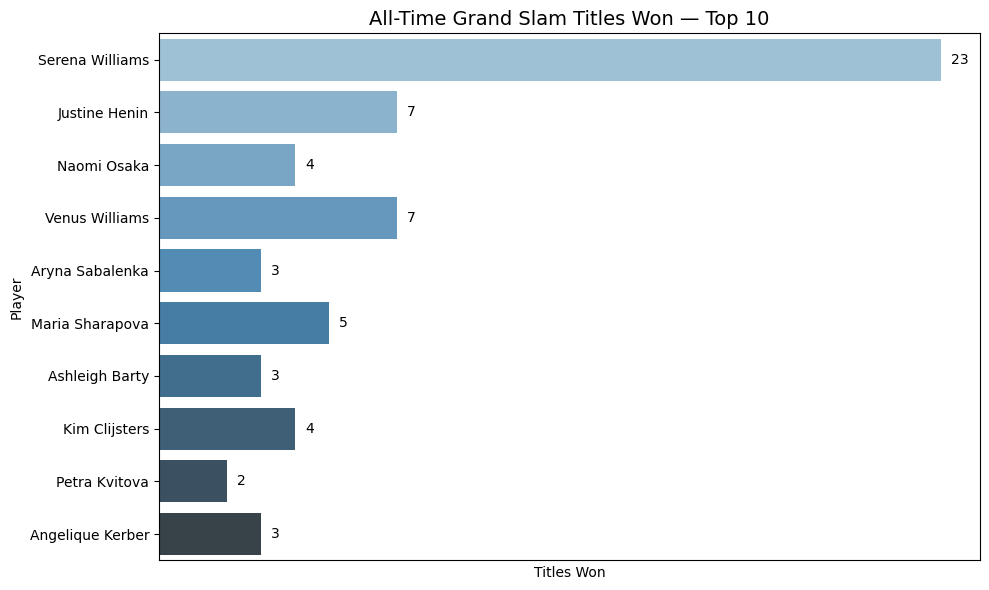

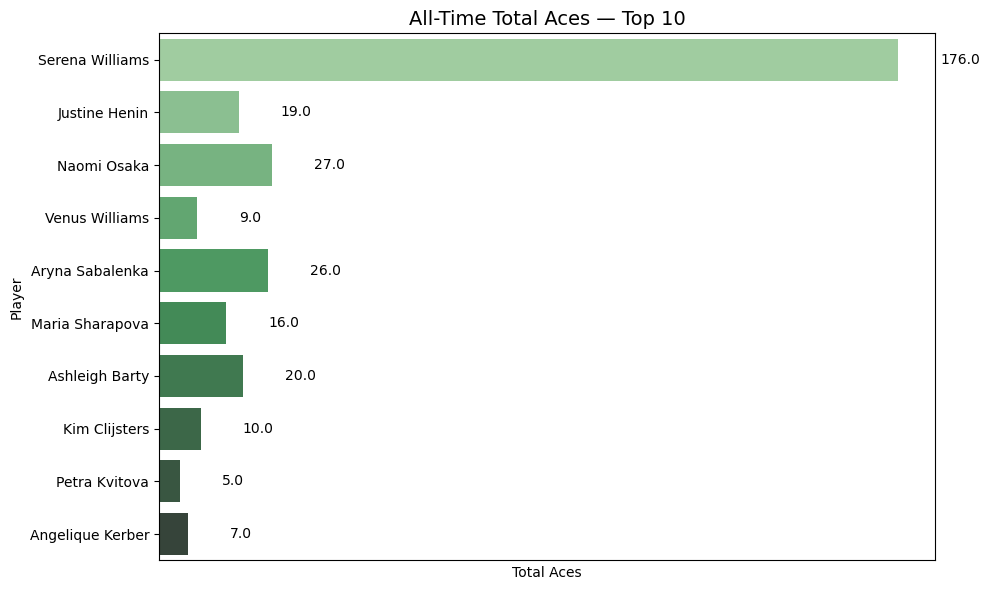

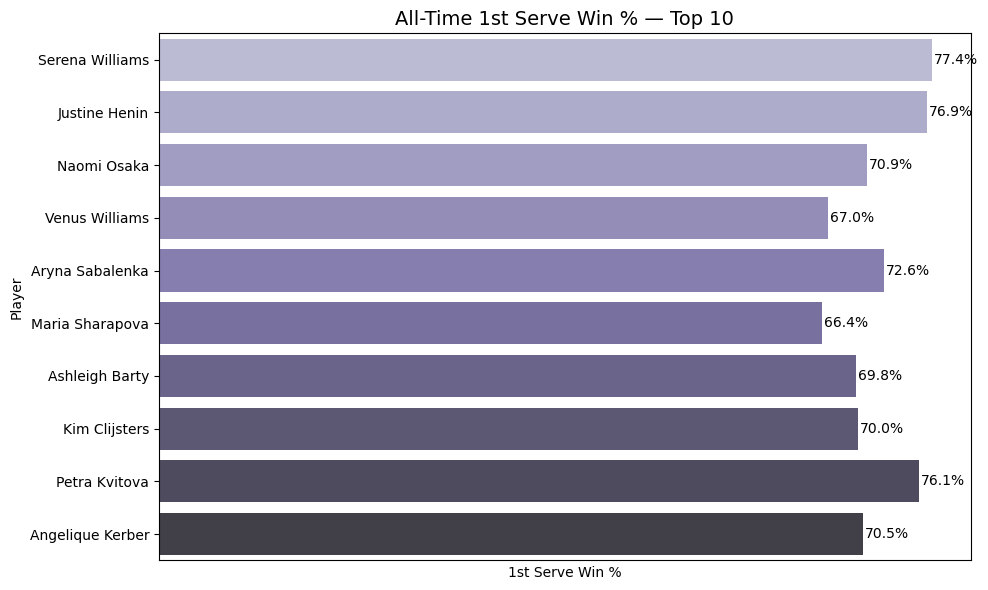

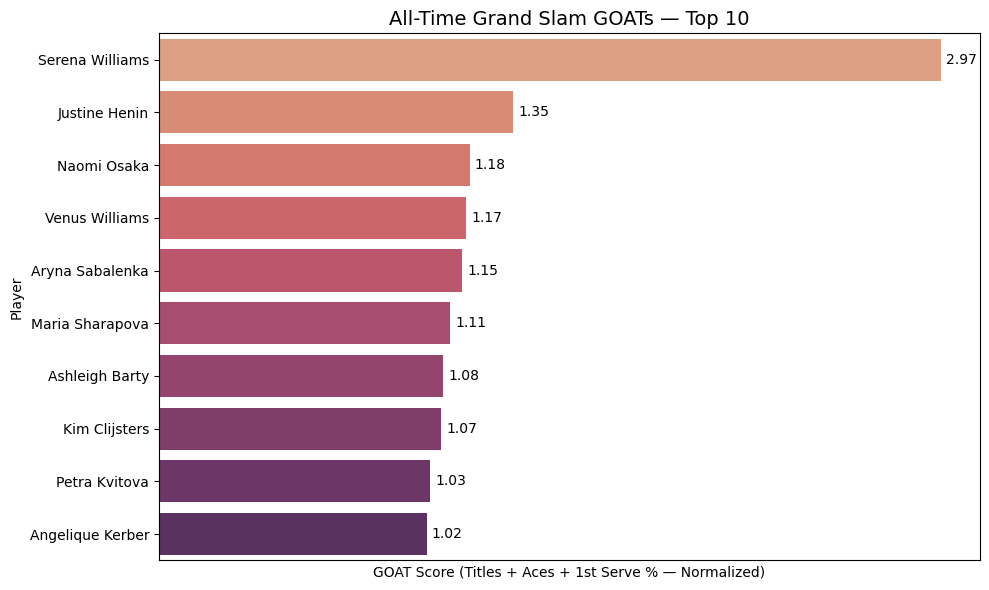

In [12]:
# Step 1: Normalize each metric
scaler = MinMaxScaler()

# Normalizing columns for titles, aces, and 1st serve win % for WTA
slam_goat_stats['titles_norm'] = scaler.fit_transform(slam_goat_stats[['total_titles']])
slam_goat_stats['aces_norm'] = scaler.fit_transform(slam_goat_stats[['total_aces']])
slam_goat_stats['serve_norm'] = scaler.fit_transform(slam_goat_stats[['1st_win_pct']])

# Step 2: Combine normalized metrics into GOAT score
slam_goat_stats['GOAT_score'] = (
    slam_goat_stats['titles_norm'] +
    slam_goat_stats['aces_norm'] +
    slam_goat_stats['serve_norm']
)

# Step 3: Rank players based on GOAT score
slam_goat_stats = slam_goat_stats.sort_values(by='GOAT_score', ascending=False)
slam_goat_stats['GOAT_rank'] = slam_goat_stats.reset_index().index + 1

# Step 4: Select top 10 GOATs
top10_slam_goats = slam_goat_stats.head(10)

# Plotting — Titles Won
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='total_titles',
    y='winner_name',
    hue='winner_name',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("All-Time Grand Slam Titles Won — Top 10", fontsize=14)
plt.xlabel("Titles Won")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_slam_goats['total_titles'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.3, i, str(val), va='center', fontsize=10)

plt.xticks([])  # Remove x-ticks
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — Total Aces
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='total_aces',
    y='winner_name',
    hue='winner_name',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("All-Time Total Aces — Top 10", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_slam_goats['total_aces'], top10_slam_goats['winner_name'])):
    ax.text(val + 10, i, str(val), va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — 1st Serve Win %
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='1st_win_pct',
    y='winner_name',
    hue='winner_name',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("All-Time 1st Serve Win % — Top 10", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

# Add value labels as percentages
for i, (val, name) in enumerate(zip(top10_slam_goats['1st_win_pct'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.002, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — GOAT Score
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='GOAT_score',
    y='winner_name',
    hue='winner_name',
    palette='flare',
    dodge=False,
    legend=False
)
plt.title("All-Time Grand Slam GOATs — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Titles + Aces + 1st Serve % — Normalized)")
plt.ylabel("Player")

# Add value labels to bars
for i, (val, name) in enumerate(zip(top10_slam_goats['GOAT_score'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


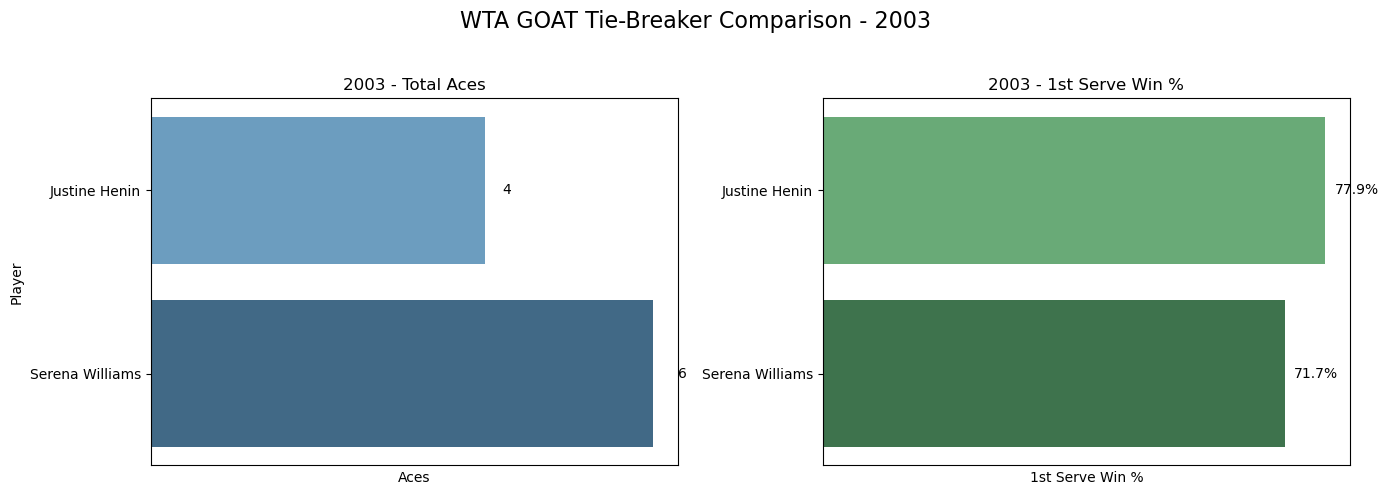

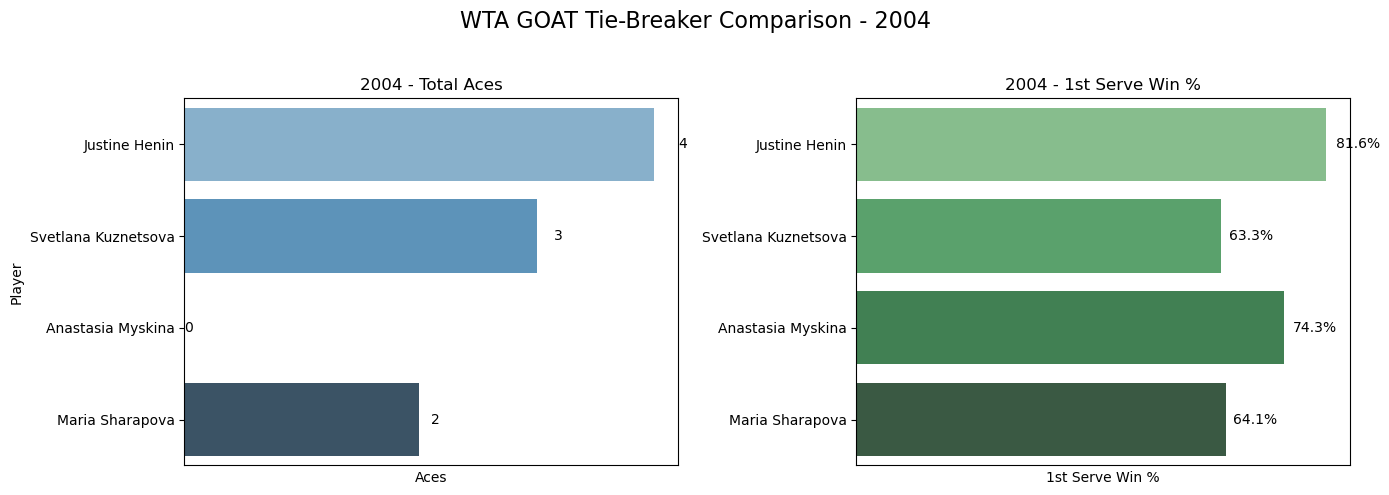

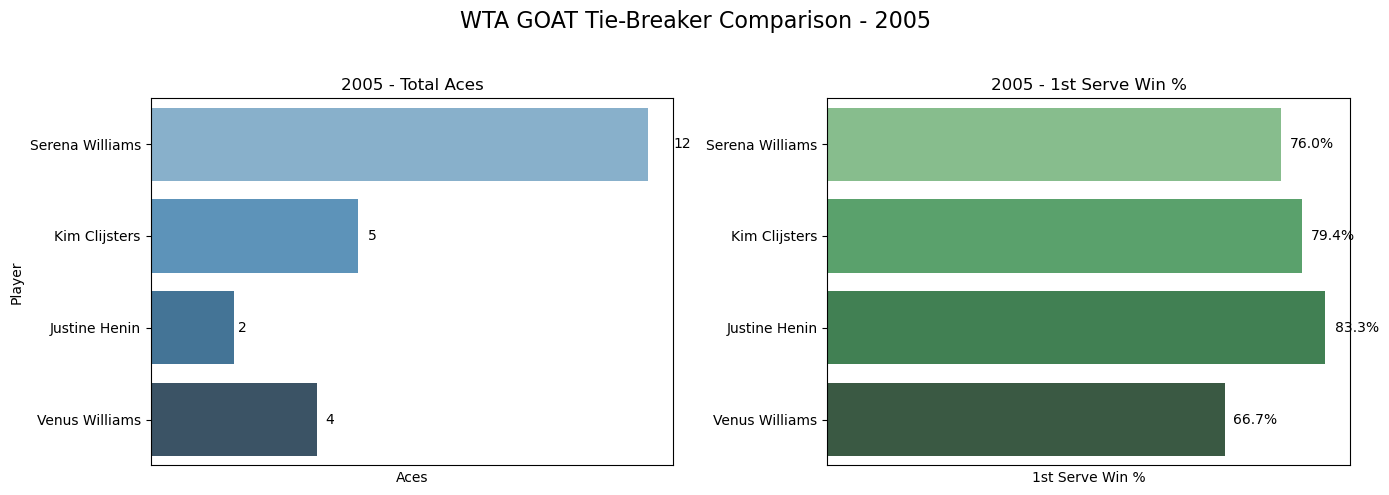

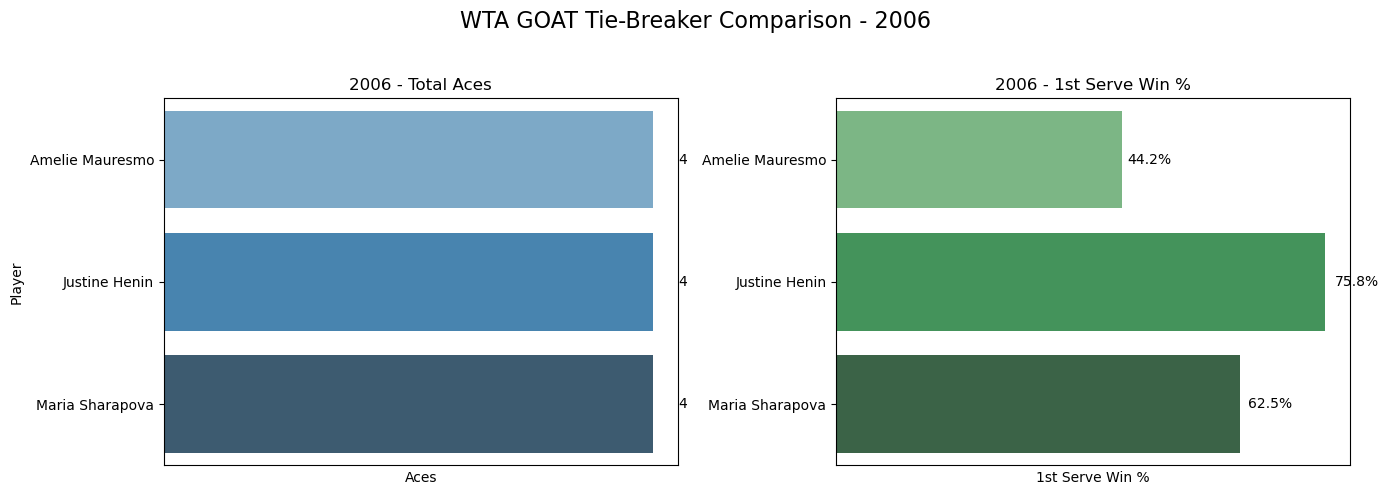

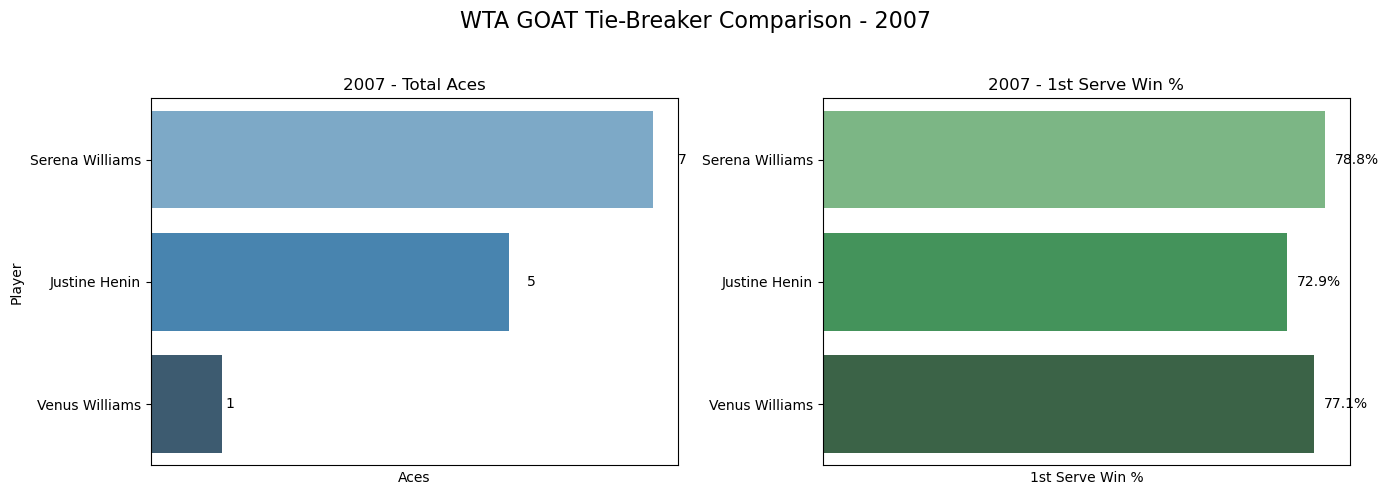

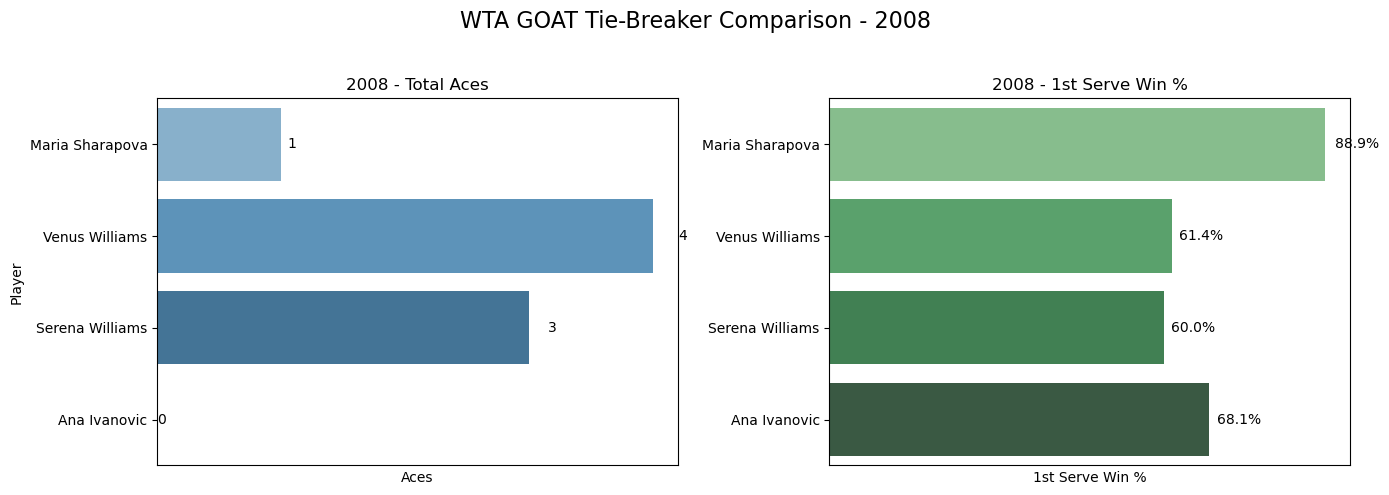

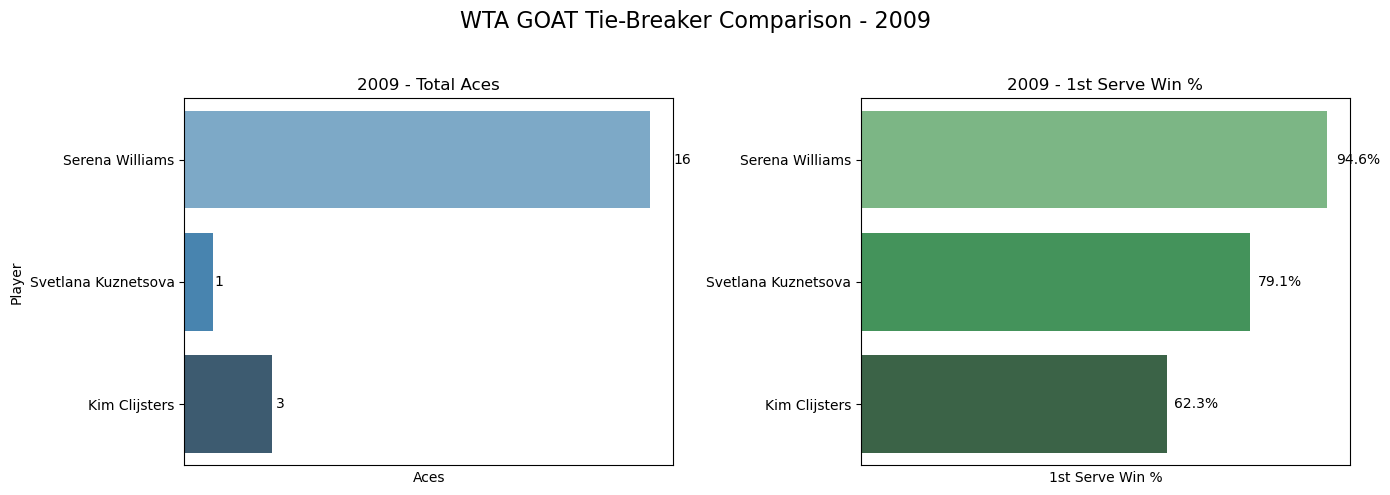

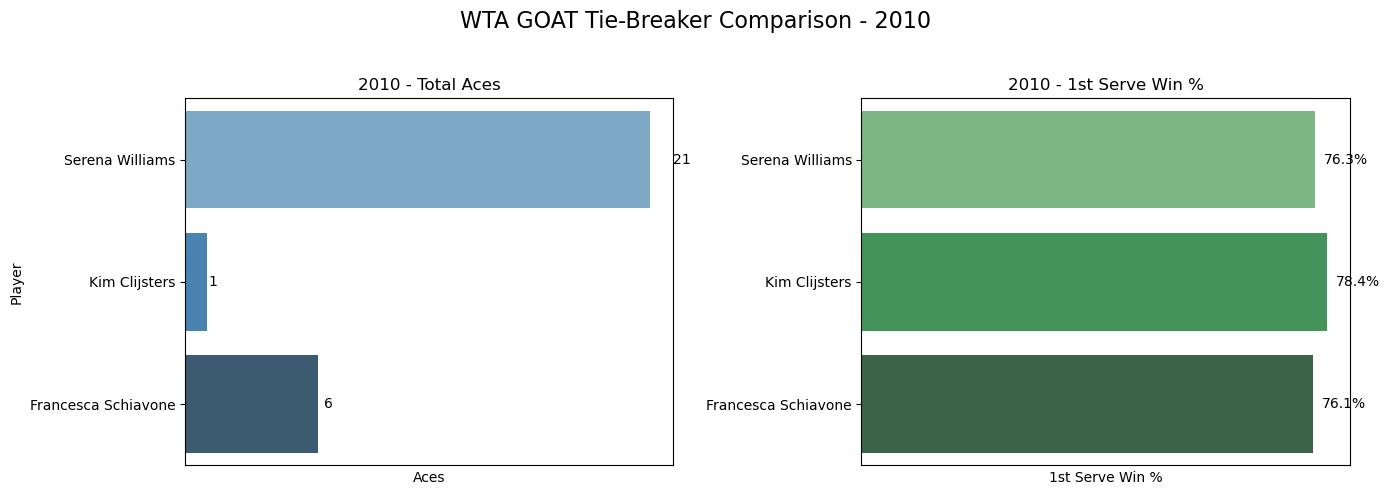

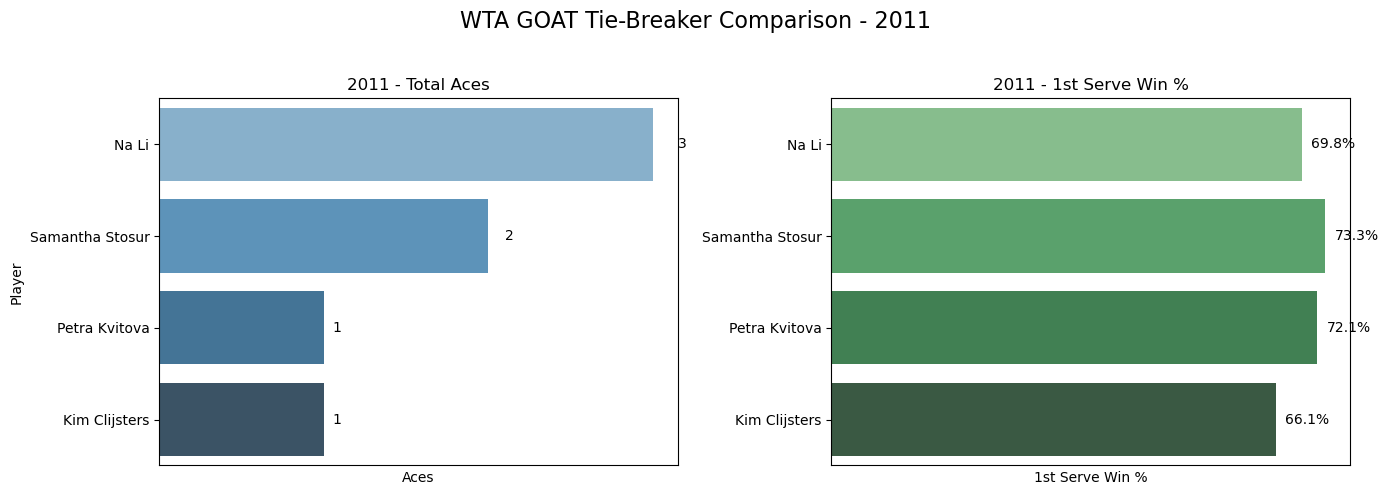

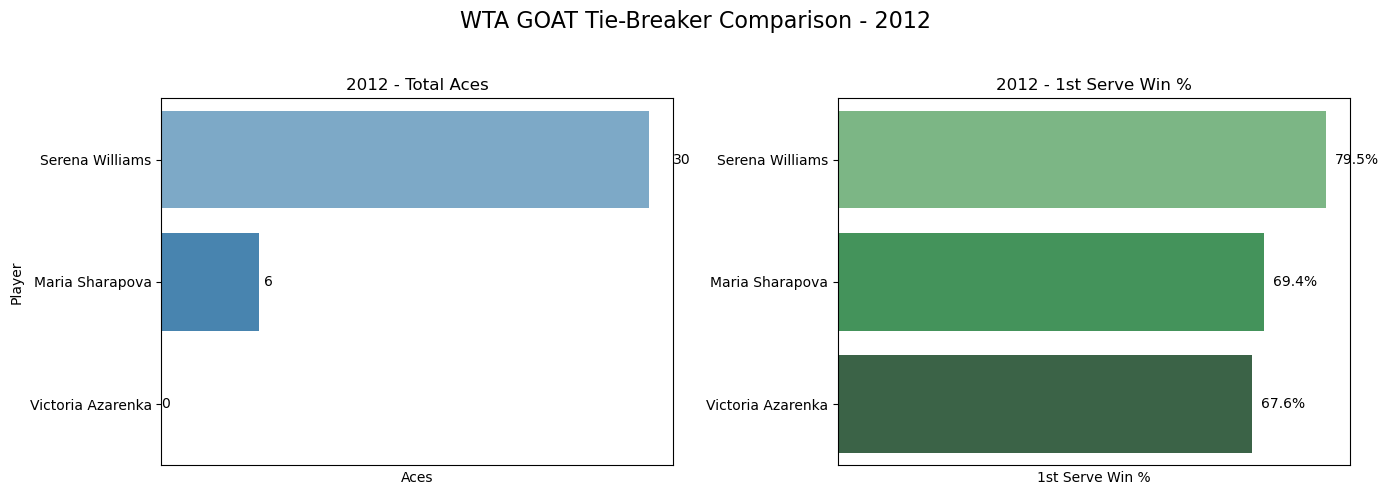

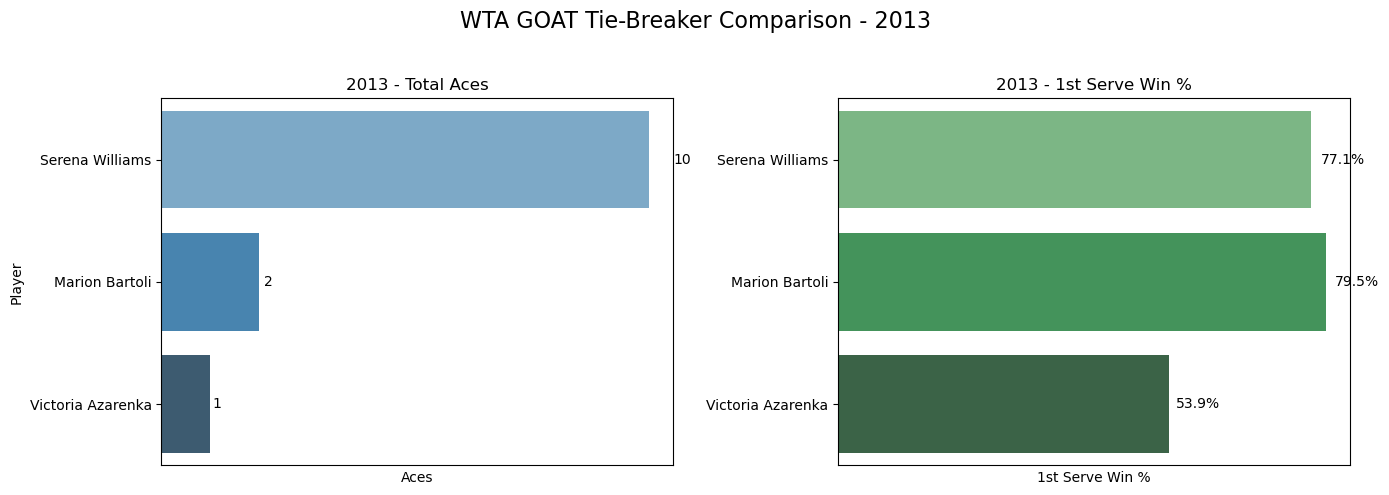

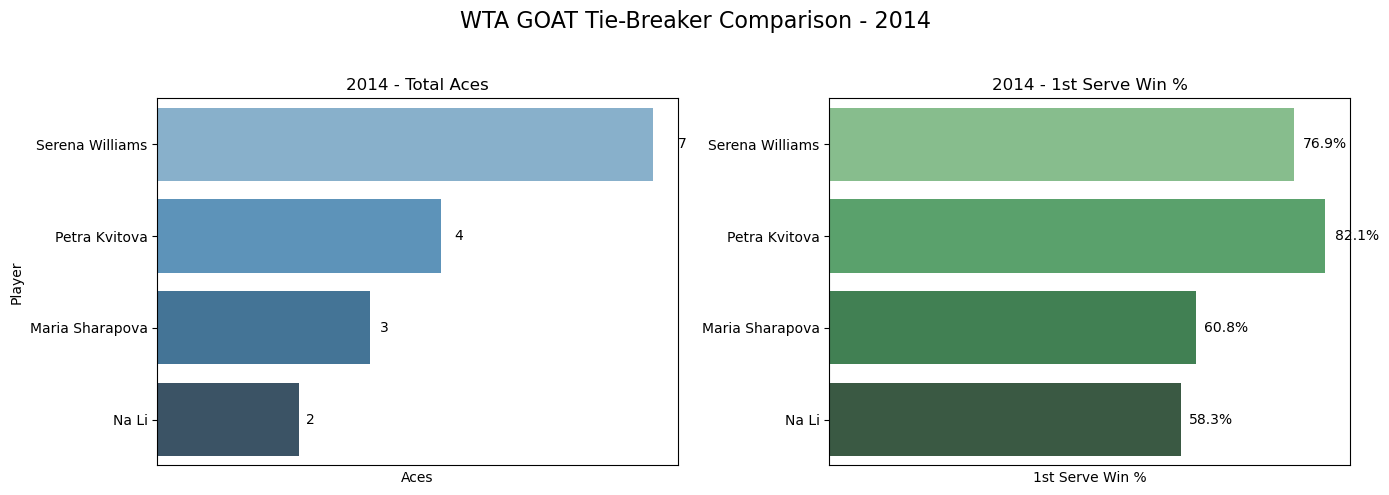

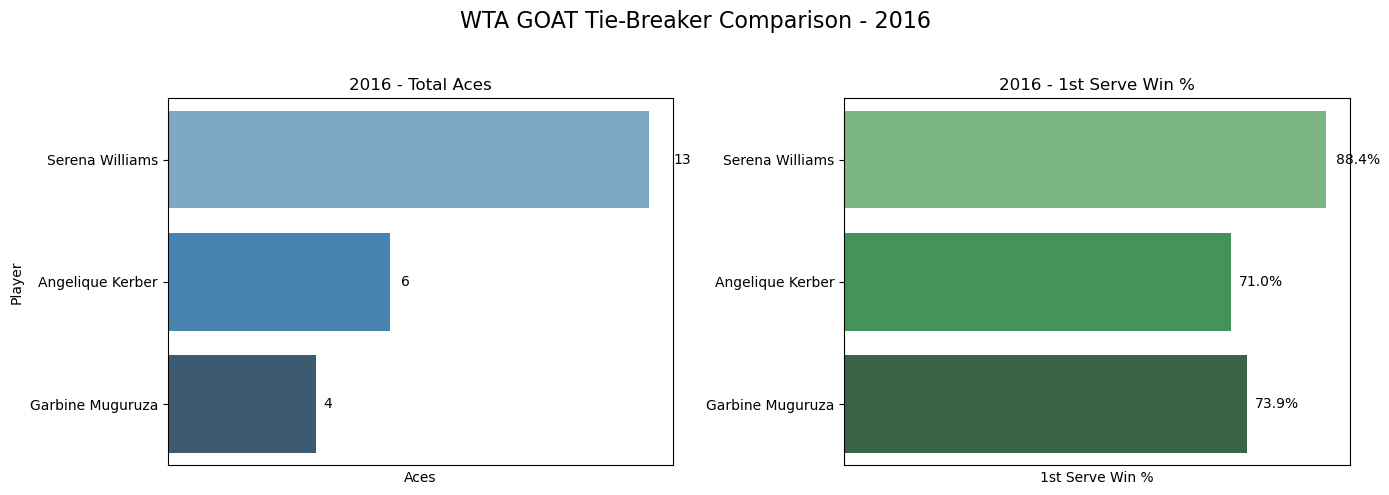

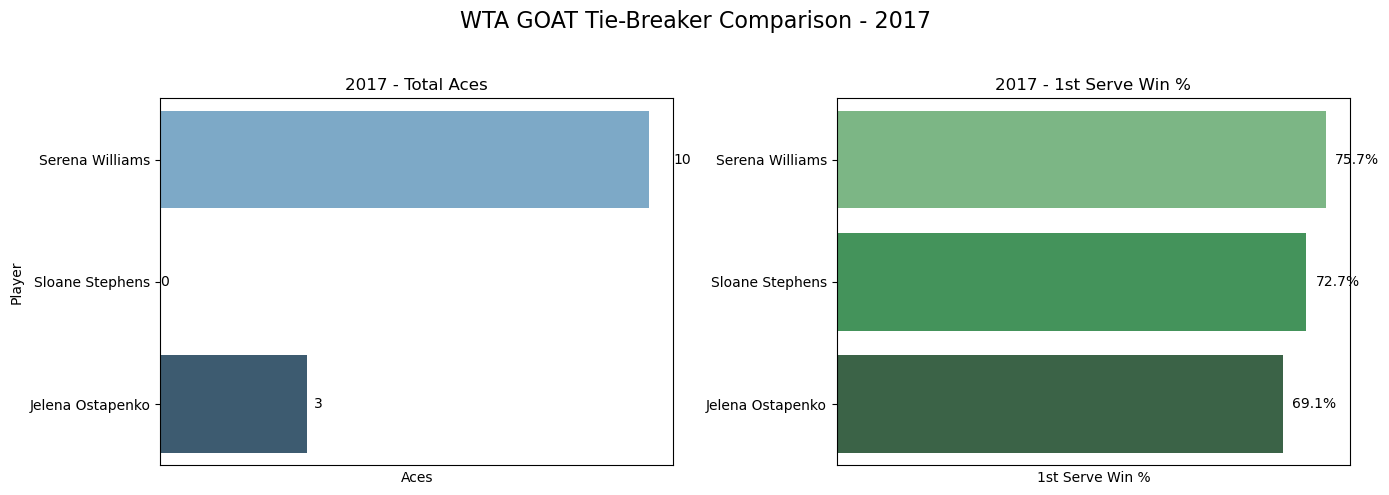

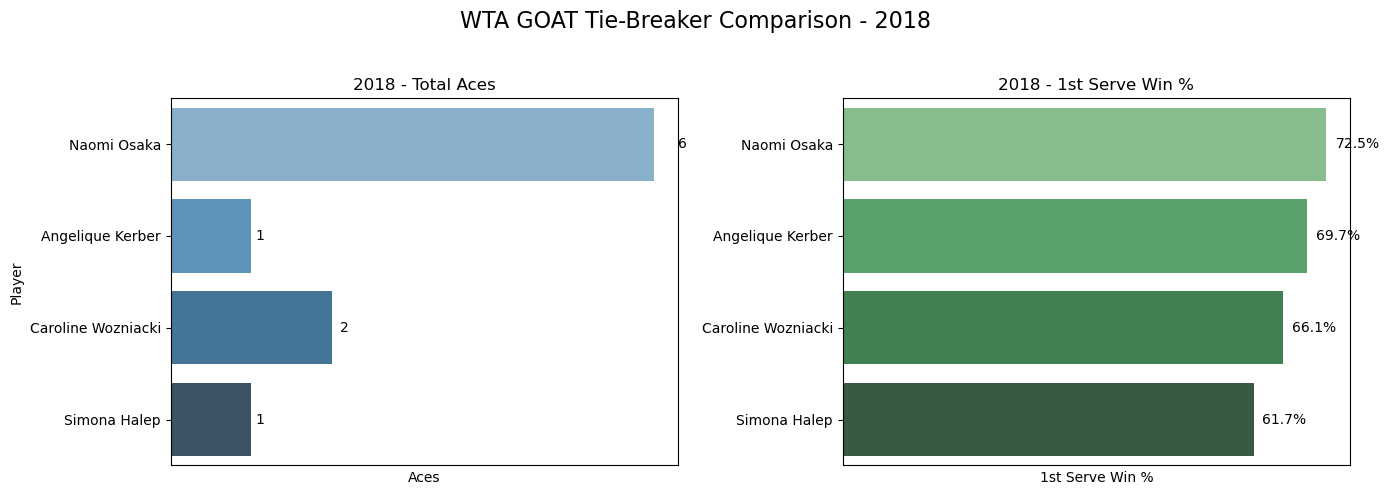

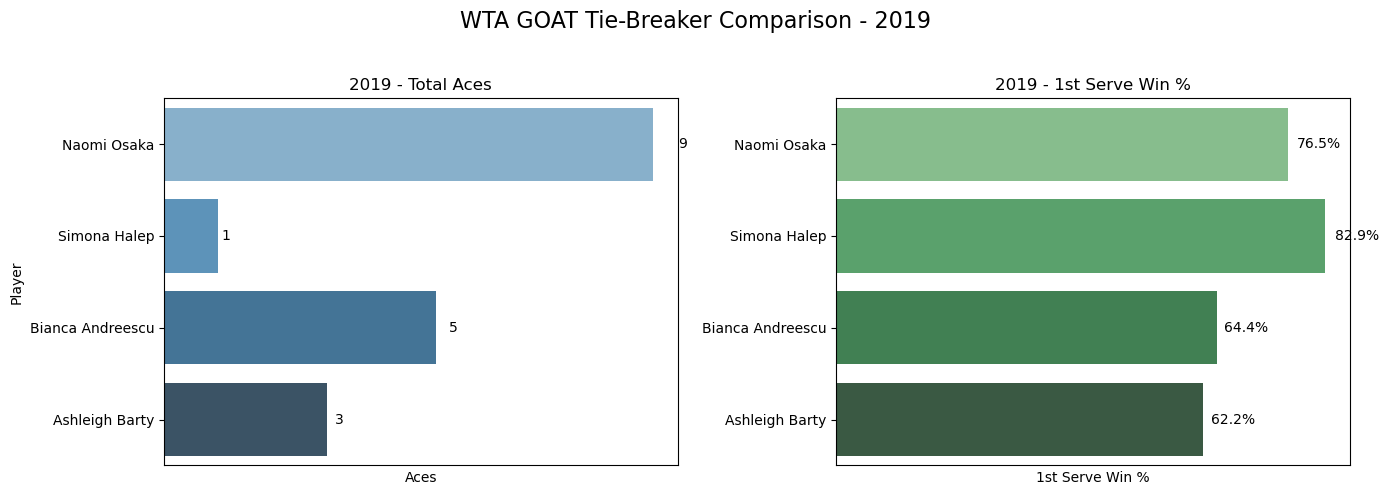

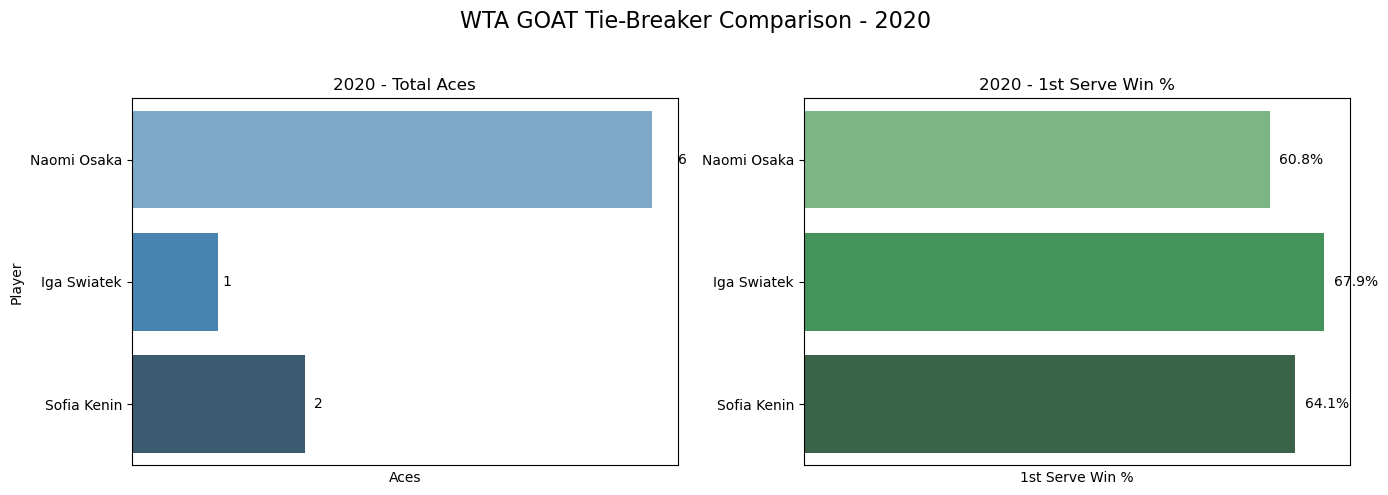

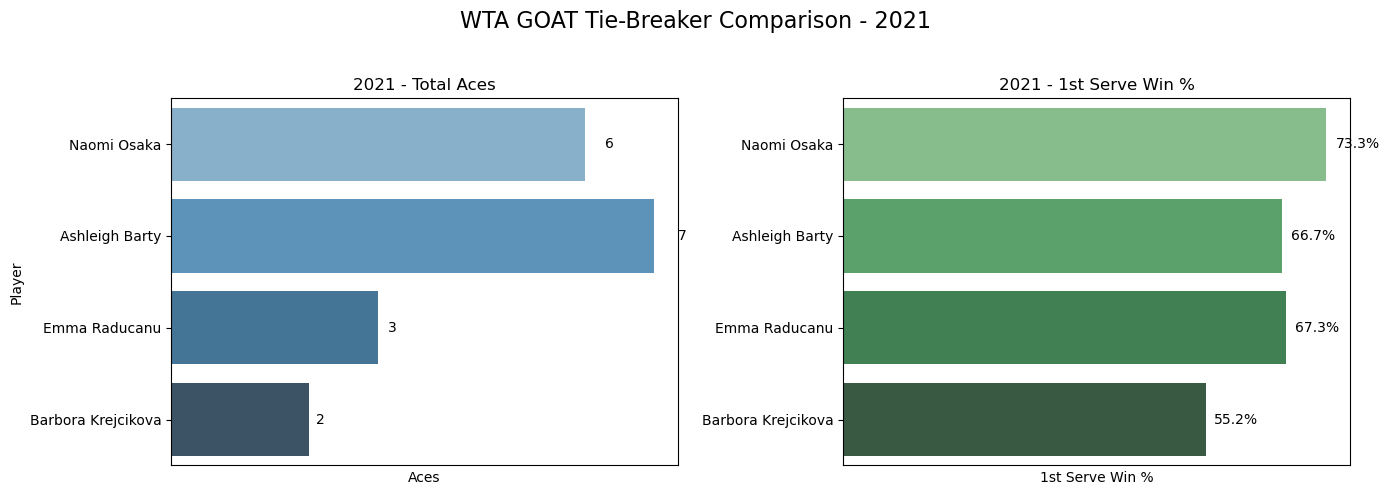

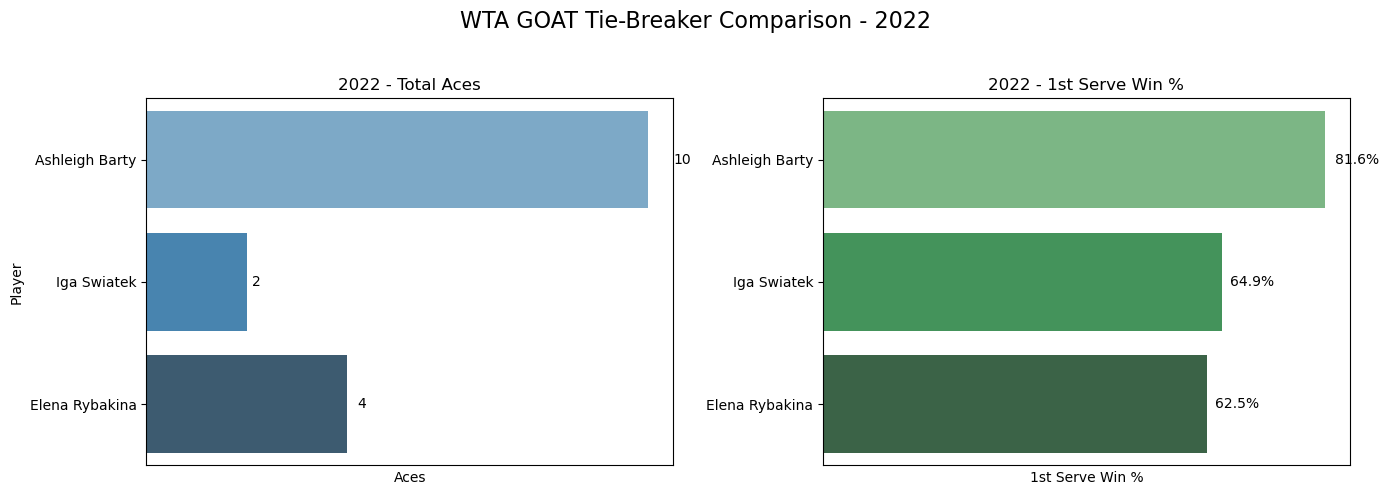

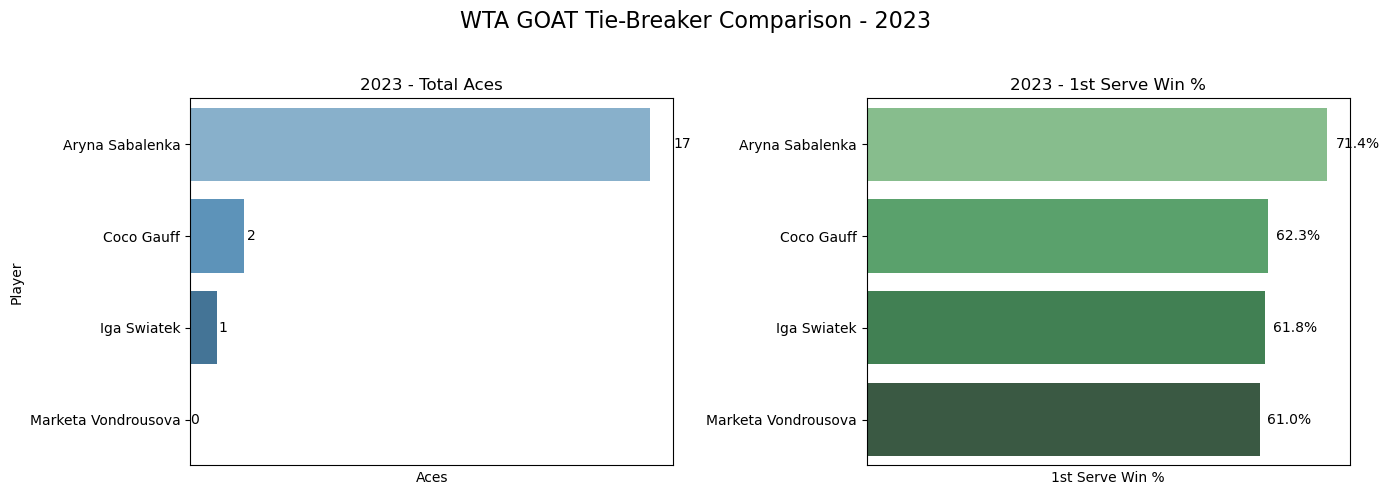

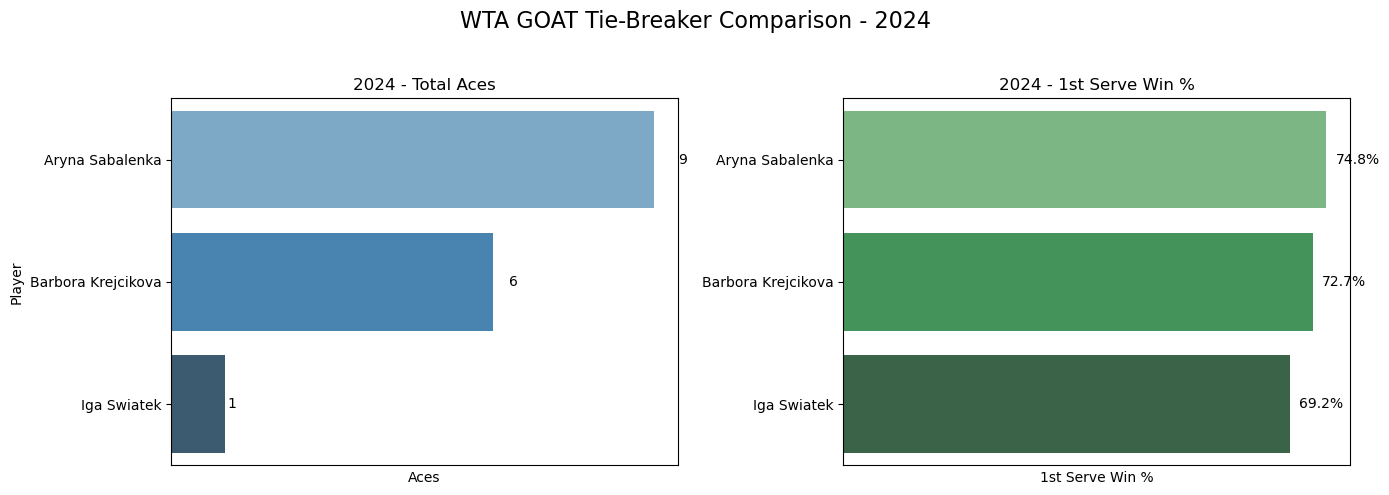

In [ ]:
# Step 1: Find years with ties in the number of titles
tied_years = (
    goat_data.groupby(['year'])['titles']
    .value_counts()
    .reset_index(name='count')
    .query('count > 1')  # Only where more than 1 player had the same title count
)

# Get the years where there's a tie
years_with_ties = tied_years['year'].unique()

# Step 2: Filter only tied years from goat_data
tied_goat_data = goat_data[goat_data['year'].isin(years_with_ties)]

# Step 3: Create separate plots for each tied year
for year in sorted(years_with_ties):
    data = tied_goat_data[tied_goat_data['year'] == year].copy()

    # Skip year if all values are NaN or 0 for both tie-breakers
    if data[['total_aces', '1st_win_pct']].isna().all().all() or (
        data['total_aces'].fillna(0).sum() == 0 and data['1st_win_pct'].fillna(0).sum() == 0
    ):
        print(f"Skipping {year} — no valid stats for tie-breaker comparison.")
        continue

    # Replace NaNs with 0s to avoid empty bars
    data['total_aces'] = data['total_aces'].fillna(0)
    data['1st_win_pct'] = data['1st_win_pct'].fillna(0)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # --- Total Aces Plot ---
    sns.barplot(data=data, x='total_aces', y='winner_name', hue='winner_name',
                palette='Blues_d', ax=ax[0], dodge=False, legend=False)
    ax[0].set_title(f'{year} - Total Aces')
    ax[0].set_xlabel('Aces')
    ax[0].set_ylabel('Player')
    ax[0].grid(axis='x', linestyle='--', alpha=0.3)
    ax[0].set_xticks([])  # Remove x-axis ticks

    # Add value labels to aces
    for i, (val, name) in enumerate(zip(data['total_aces'], data['winner_name'])):
        offset = val * 0.05  # 5% of value to prevent too much gap
        ax[0].text(val + offset, i, f"{int(val)}", va='center', fontsize=10)


    # --- 1st Serve Win % Plot ---
    sns.barplot(data=data, x='1st_win_pct', y='winner_name', hue='winner_name',
                palette='Greens_d', ax=ax[1], dodge=False, legend=False)
    ax[1].set_title(f'{year} - 1st Serve Win %')
    ax[1].set_xlabel('1st Serve Win %')
    ax[1].set_ylabel('')
    ax[1].grid(axis='x', linestyle='--', alpha=0.3)
    ax[1].set_xticks([])  # Remove x-axis ticks

    # Add value labels to 1st Serve %
    for i, (val, name) in enumerate(zip(data['1st_win_pct'], data['winner_name'])):
        offset = val * 0.02  # Adjust dynamically based on % scale
        ax[1].text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

    # Layout and display
    fig.suptitle(f"GOAT Tie-Breaker Comparison - {year}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [15]:
# List of Grand Slam tournaments (WTA)
slam_names = ['Australian Open', 'Roland Garros', 'Wimbledon', 'US Open']

# Step 1: Filter Grand Slam finals for WTA
slam_finals = major_matches[
    (major_matches['tourney_level'] == 'G') &  # Only Grand Slam tournaments
    (major_matches['round'] == 'F')  # Only finals
].copy()

# Step 2: Group by year and winner, get set of won tournaments
player_slams_per_year = slam_finals.groupby(['year', 'winner_name'])['tourney_name'].apply(set).reset_index()

# Step 3: Check if player won all 4 Slams
player_slams_per_year['calendar_slam'] = player_slams_per_year['tourney_name'].apply(
    lambda tourneys: set(slam_names).issubset(tourneys)
)

# Step 4: Filter only true cases for Calendar Slam winners
calendar_slam_winners = player_slams_per_year[player_slams_per_year['calendar_slam'] == True]

# Display results
print("WTA Calendar Grand Slam Winners:")
print(calendar_slam_winners[['year', 'winner_name']])


WTA Calendar Grand Slam Winners:
Empty DataFrame
Columns: [year, winner_name]
Index: []


In [16]:
# Filter WTA Finals matches
wta_finals_matches = major_matches[
    (major_matches['tourney_level'] == 'F')
].copy()

# Create columns for winner and loser
wta_finals_matches['winner'] = wta_finals_matches['winner_name']
wta_finals_matches['loser'] = wta_finals_matches['loser_name']

# Create a long-form table to evaluate both players (winner and loser) in each match
winners_df = wta_finals_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1  # Winner's matches count as won

losers_df = wta_finals_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0  # Loser's matches count as lost

# Combine the winner and loser data into one DataFrame
player_stats = pd.concat([winners_df, losers_df], ignore_index=True)

# Calculate player performance in WTA Finals per year
player_year_stats = player_stats.groupby(['year', 'player']).agg(
    matches_played=('won', 'count'),
    matches_won=('won', 'sum'),
    aces=('w_ace', 'sum'),  # Aces per year
    total_1st_in=('w_1stIn', 'sum'),  # 1st serves in
    total_1st_won=('w_1stWon', 'sum'),  # 1st serves won
).reset_index()

# Calculate derived statistics: win percentage and 1st serve win percentage
player_year_stats['win_pct'] = player_year_stats['matches_won'] / player_year_stats['matches_played']
player_year_stats['1st_win_pct'] = player_year_stats['total_1st_won'] / player_year_stats['total_1st_in']
player_year_stats['1st_win_pct'] = player_year_stats['1st_win_pct'].fillna(0)  # Replace NaN with 0

# Normalize the statistics per year
scaler = MinMaxScaler()

# Normalize aces, 1st serve win %, and win % per year
player_year_stats['aces_norm'] = player_year_stats.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
player_year_stats['serve_norm'] = player_year_stats.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
player_year_stats['win_norm'] = player_year_stats.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Combine the normalized scores into a single GOAT score
player_year_stats['GOAT_score'] = (
    player_year_stats['aces_norm'] +
    player_year_stats['serve_norm'] +
    player_year_stats['win_norm']
)

# Rank players per year based on the GOAT score
player_year_stats = player_year_stats.sort_values(['year', 'GOAT_score'], ascending=[True, False])
player_year_stats['GOAT_rank'] = player_year_stats.groupby('year').cumcount() + 1

# Get the year range dynamically
start_year = player_year_stats['year'].min()
end_year = player_year_stats['year'].max()

# Print the results
print(f"WTA Finals GOAT Rankings ({start_year}–{end_year}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(player_year_stats[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])


WTA Finals GOAT Rankings (2000–2024) — Based on Match Wins, Aces, and 1st Serve Win %
     year            player  matches_played  matches_won  aces  1st_win_pct  \
12   2000    Martina Hingis               4            4   0.0     0.000000   
13   2000      Monica Seles               4            3   0.0     0.000000   
2    2000   Anna Kournikova               3            2   0.0     0.000000   
6    2000  Elena Dementieva               3            2   0.0     0.000000   
0    2000    Amanda Coetzer               2            1   0.0     0.000000   
..    ...               ...             ...          ...   ...          ...   
327  2024       Iga Swiatek               3            2  13.0     0.701613   
328  2024   Jasmine Paolini               3            1  19.0     0.725806   
324  2024        Coco Gauff               5            4  16.0     0.654321   
325  2024   Daria Kasatkina               1            0   1.0     0.760000   
329  2024    Jessica Pegula               2  

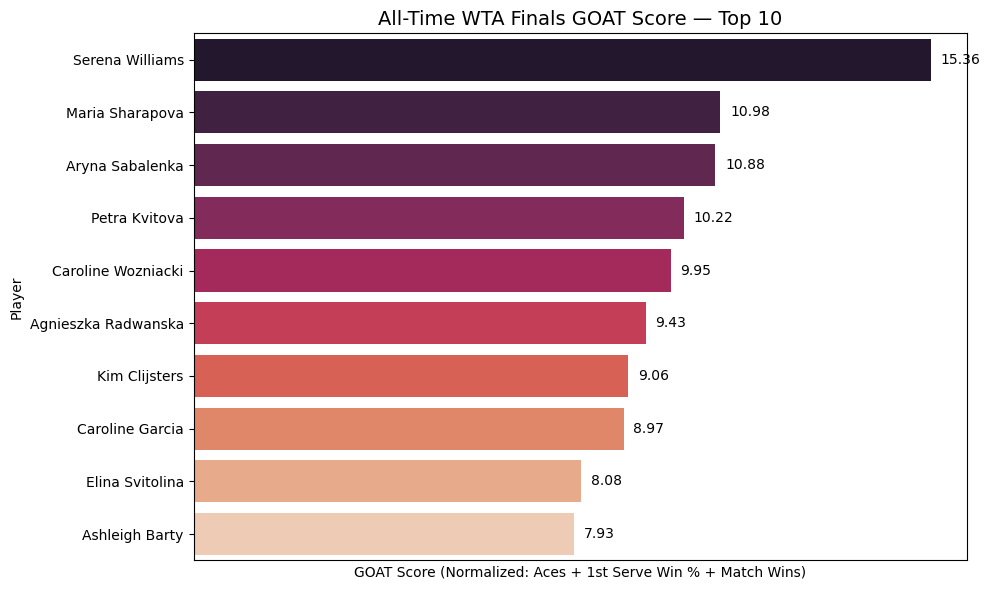

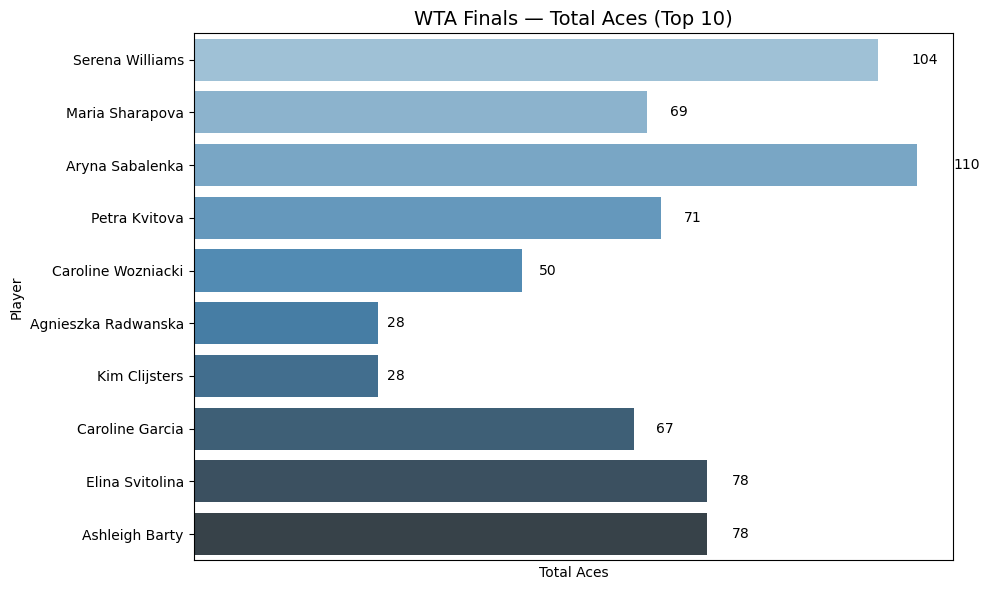

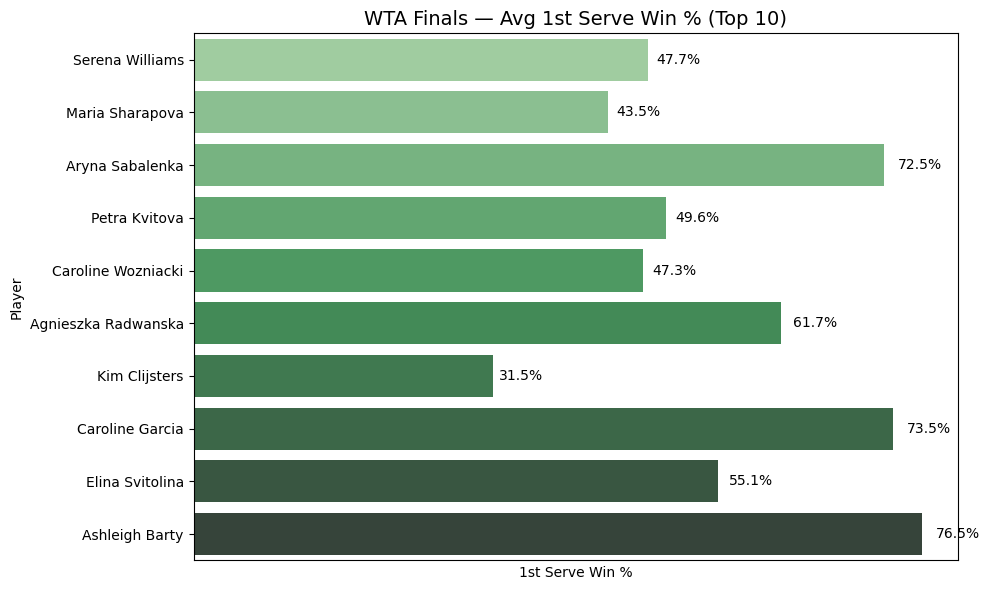

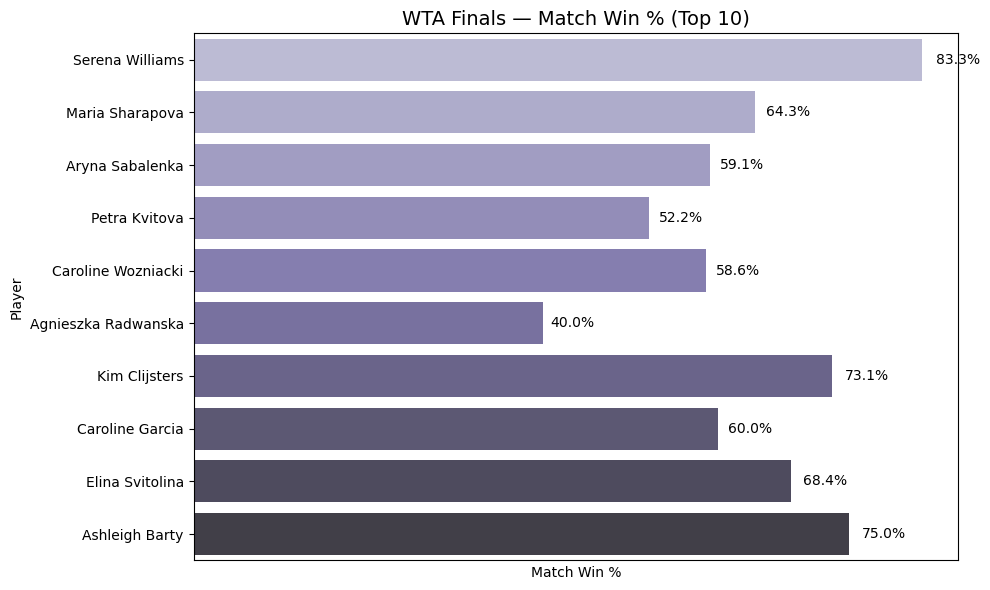

In [17]:
# Aggregate across all years for WTA
wta_goat_summary = player_year_stats.groupby('player').agg(
    total_aces=('aces', 'sum'),
    avg_1st_win_pct=('1st_win_pct', 'mean'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_goat_score=('GOAT_score', 'sum')
).reset_index()

# Sort and take top 10
top10_wta_goats = wta_goat_summary.sort_values(by='total_goat_score', ascending=False).head(10)

# --- Plot: Total GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_wta_goats,
    x='total_goat_score',
    y='player',
    hue='player',
    palette='rocket',
    dodge=False,
    legend=False
)
plt.title("All-Time WTA Finals GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Wins)")
plt.ylabel("Player")

# Add value labels
for i, (score, name) in enumerate(zip(top10_wta_goats['total_goat_score'], top10_wta_goats['player'])):
    ax.text(score + 0.2, i, f"{score:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_wta_goats,
    x='total_aces',
    y='player',
    hue='player',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_wta_goats['total_aces'], top10_wta_goats['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_wta_goats,
    x='avg_1st_win_pct',
    y='player',
    hue='player',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Avg 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

# Add value labels as percentages
for i, (val, name) in enumerate(zip(top10_wta_goats['avg_1st_win_pct'], top10_wta_goats['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Match Win % ---
top10_wta_goats['win_pct'] = top10_wta_goats['total_wins'] / top10_wta_goats['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_wta_goats,
    x='win_pct',
    y='player',
    hue='player',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_wta_goats['win_pct'], top10_wta_goats['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# Group by player to aggregate WTA final stats
wta_all_time_stats = player_year_stats.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived stats
wta_all_time_stats['career_win_pct'] = wta_all_time_stats['total_wins'] / wta_all_time_stats['total_matches']
wta_all_time_stats['career_1st_win_pct'] = wta_all_time_stats['total_1st_won'] / wta_all_time_stats['total_1st_in']
wta_all_time_stats['career_1st_win_pct'] = wta_all_time_stats['career_1st_win_pct'].fillna(0)

# Normalize metrics across all players (WTA)
scaler = MinMaxScaler()

wta_all_time_stats['aces_norm'] = scaler.fit_transform(wta_all_time_stats[['total_aces']])
wta_all_time_stats['serve_norm'] = scaler.fit_transform(wta_all_time_stats[['career_1st_win_pct']])
wta_all_time_stats['win_norm'] = scaler.fit_transform(wta_all_time_stats[['career_win_pct']])

# Combine all metrics into a final GOAT score
wta_all_time_stats['GOAT_score'] = (
    wta_all_time_stats['aces_norm'] +
    wta_all_time_stats['serve_norm'] +
    wta_all_time_stats['win_norm'] +
    wta_all_time_stats['avg_goat_score']
)

# Sort the players based on their GOAT score
wta_all_time_stats = wta_all_time_stats.sort_values(by='GOAT_score', ascending=False)

# Add rank column
wta_all_time_stats['GOAT_rank'] = wta_all_time_stats.reset_index().index + 1

# Print the results
print("All-Time WTA Finals GOAT Rankings — Based on Cumulative Performance Across All Years")
print(wta_all_time_stats[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 
                          'career_win_pct', 'total_aces', 'career_1st_win_pct', 'avg_goat_score', 'GOAT_score']])


All-Time WTA Finals GOAT Rankings — Based on Cumulative Performance Across All Years
     GOAT_rank                player  total_years  total_matches  total_wins  \
24           1        Ashleigh Barty            3             12           9   
100          2          Qinwen Zheng            2              9           6   
35           3       Coco Vandeweghe            1              4           3   
107          4       Serena Williams            9             36          30   
23           5       Aryna Sabalenka            6             22          13   
..         ...                   ...          ...            ...         ...   
29         123      Bianca Andreescu            1              2           0   
20         124        Anna Smashnova            1              1           0   
17         125            Anke Huber            1              1           0   
8          126           Amy Frazier            1              1           0   
63         127  Julie Halard Decugi

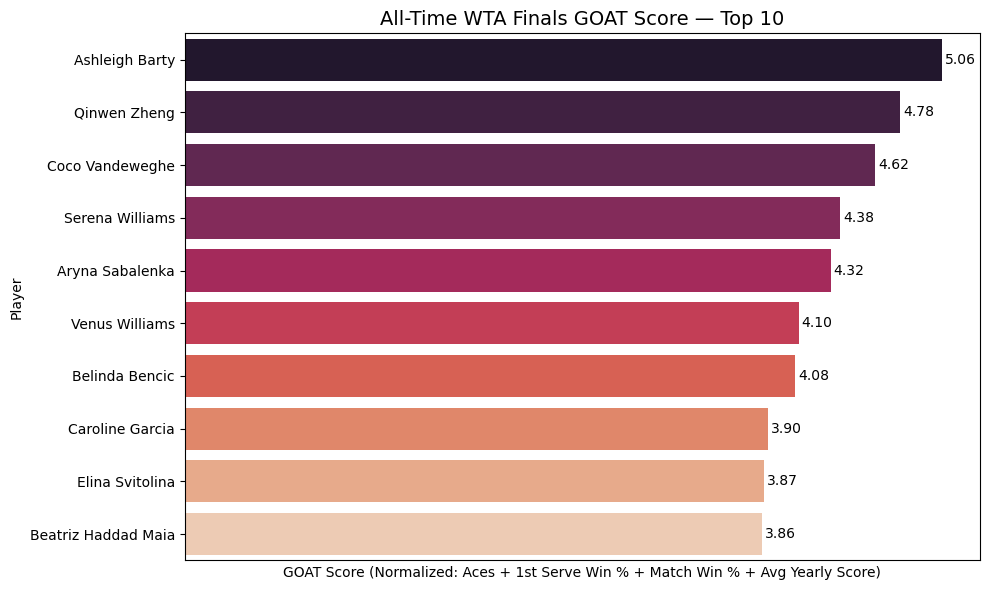

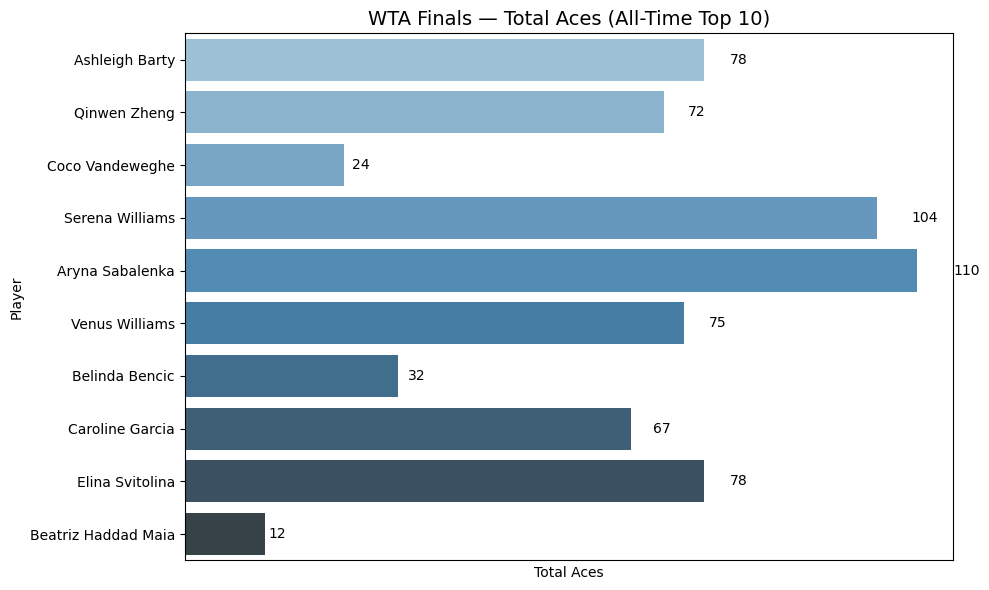

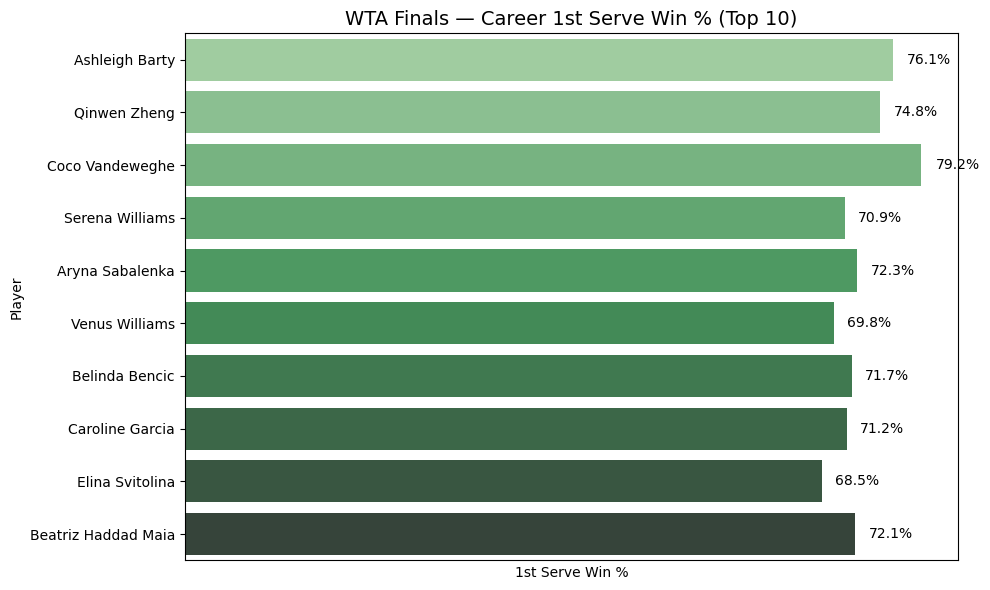

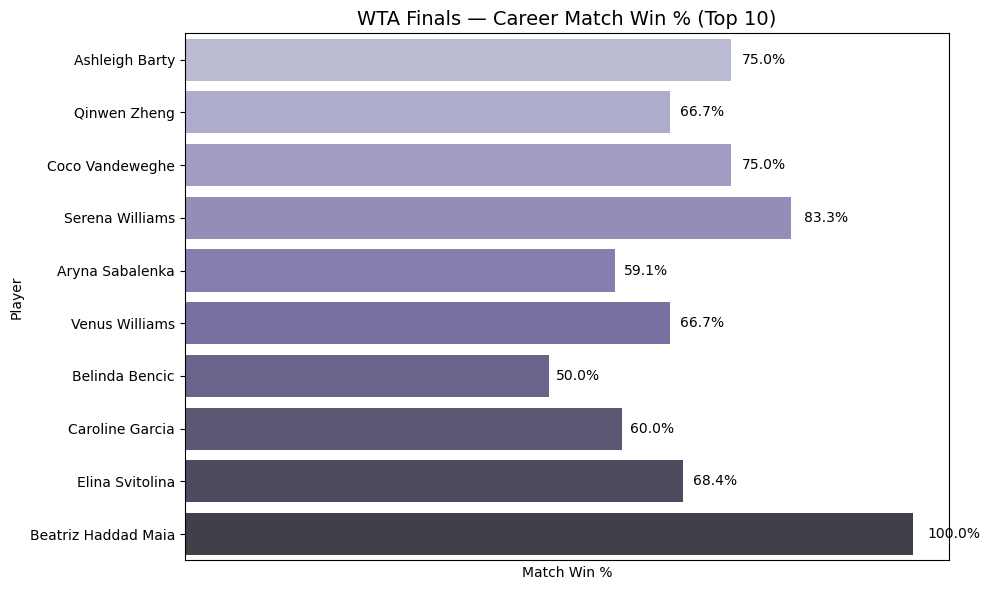

In [19]:
# Take Top 10 All-Time WTA Finals GOATs
top10_all_time_wta = wta_all_time_stats.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time_wta,
    x='GOAT_score',
    y='player',
    hue='player',
    palette='rocket',
    dodge=False,
    legend=False
)
plt.title("All-Time WTA Finals GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Win % + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time_wta['GOAT_score'], top10_all_time_wta['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time_wta,
    x='total_aces',
    y='player',
    hue='player',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Total Aces (All-Time Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time_wta['total_aces'], top10_all_time_wta['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time_wta,
    x='career_1st_win_pct',
    y='player',
    hue='player',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time_wta['career_1st_win_pct'], top10_all_time_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career Match Win % ---
top10_all_time_wta['win_pct'] = top10_all_time_wta['total_wins'] / top10_all_time_wta['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time_wta,
    x='win_pct',
    y='player',
    hue='player',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("WTA Finals — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time_wta['win_pct'], top10_all_time_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
# Filter matches from Olympic tournaments for WTA
olympics_matches_wta = major_matches[
    (major_matches['tourney_name'].str.contains("Olympics", na=False)) |
    (major_matches['tourney_level'] == 'O')  # if available for WTA
].copy()

# Add winner/loser flags for WTA matches
olympics_matches_wta['winner'] = olympics_matches_wta['winner_name']
olympics_matches_wta['loser'] = olympics_matches_wta['loser_name']

# Create player-centric dataset for WTA
winners_df = olympics_matches_wta.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = olympics_matches_wta.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine both sides for WTA
olympics_stats_wta = pd.concat([winners_df, losers_df], ignore_index=True)

# Player performance per Olympic year for WTA
olympics_yearly_wta = olympics_stats_wta.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum')
).reset_index()

# Derived stats for WTA
olympics_yearly_wta['win_pct'] = olympics_yearly_wta['matches_won'] / olympics_yearly_wta['matches_played']
olympics_yearly_wta['1st_win_pct'] = olympics_yearly_wta['total_1st_won'] / olympics_yearly_wta['total_1st_in']
olympics_yearly_wta['1st_win_pct'] = olympics_yearly_wta['1st_win_pct'].fillna(0)

# Normalize metrics for WTA
scaler = MinMaxScaler()

olympics_yearly_wta['aces_norm'] = olympics_yearly_wta.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly_wta['serve_norm'] = olympics_yearly_wta.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly_wta['win_norm'] = olympics_yearly_wta.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# GOAT score = combination of all 3 for WTA
olympics_yearly_wta['GOAT_score'] = (
    olympics_yearly_wta['aces_norm'] +
    olympics_yearly_wta['serve_norm'] +
    olympics_yearly_wta['win_norm']
)

olympics_yearly_wta = olympics_yearly_wta.sort_values(['year', 'GOAT_score'], ascending=[True, False])
olympics_yearly_wta['GOAT_rank'] = olympics_yearly_wta.groupby('year').cumcount() + 1

# Print results for WTA Olympic Tennis GOAT Rankings
start_year_wta = olympics_yearly_wta['year'].min()
end_year_wta = olympics_yearly_wta['year'].max()

print(f"Olympic Tennis WTA GOAT Rankings ({start_year_wta}–{end_year_wta}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(olympics_yearly_wta[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])


Olympic Tennis WTA GOAT Rankings (1992–2024) — Based on Match Wins, Aces, and 1st Serve Win %
     year                   player  matches_played  matches_won  aces  \
23   1992        Jennifer Capriati               6            6   0.0   
61   1992              Steffi Graf               6            5   0.0   
5    1992  Arantxa Sanchez Vicario               5            4   0.0   
39   1992       Mary Joe Fernandez               5            4   0.0   
4    1992               Anke Huber               4            3   0.0   
..    ...                      ...             ...          ...   ...   
494  2024             Mayar Sherif               1            0   1.0   
477  2024         Jelena Ostapenko               1            0   1.0   
506  2024         Varvara Gracheva               1            0   0.0   
481  2024       Katerina Siniakova               1            0   0.0   
469  2024    Ekaterina Alexandrova               1            0   2.0   

     1st_win_pct   win_pct  G

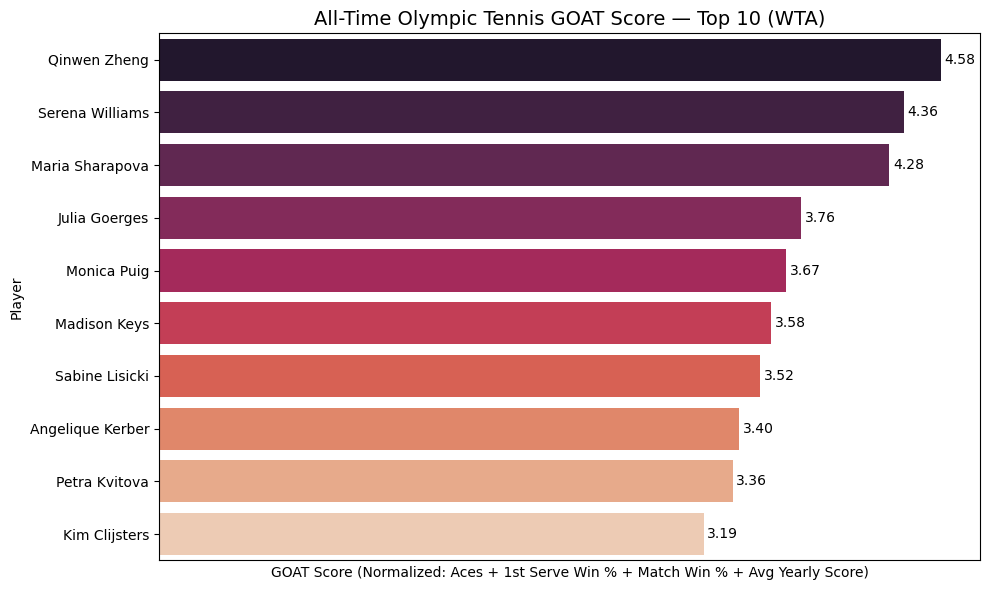

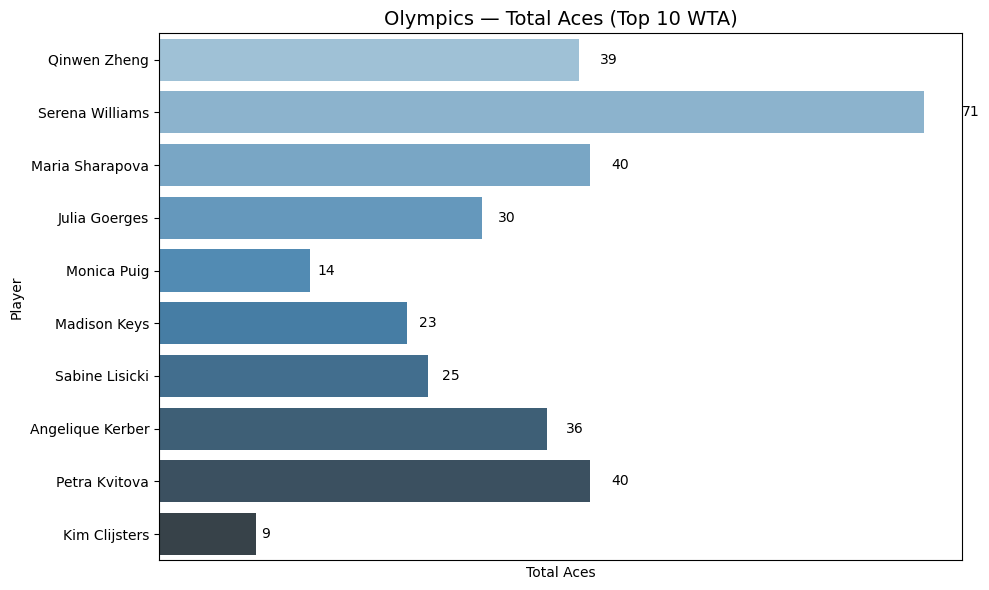

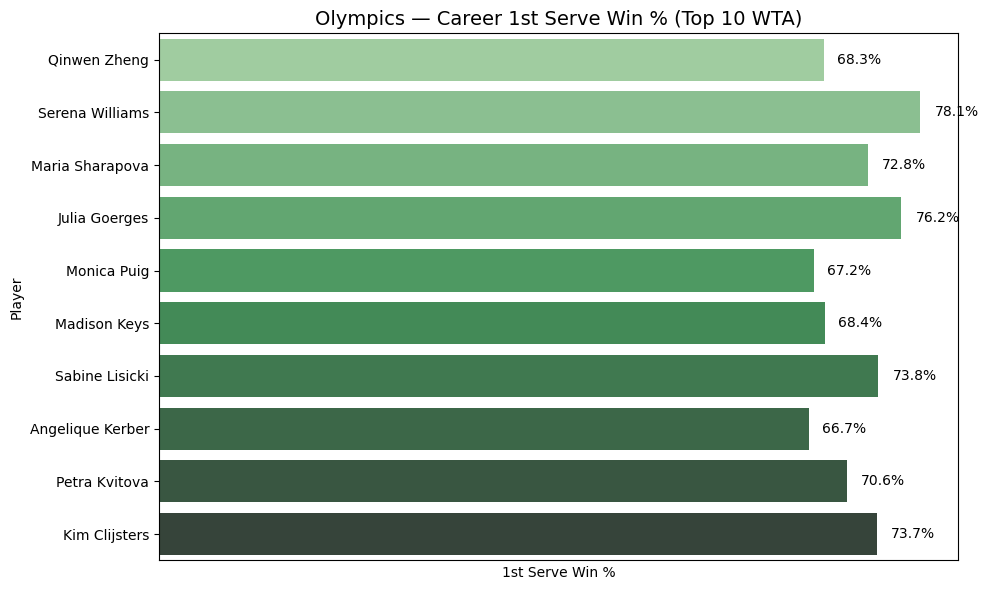

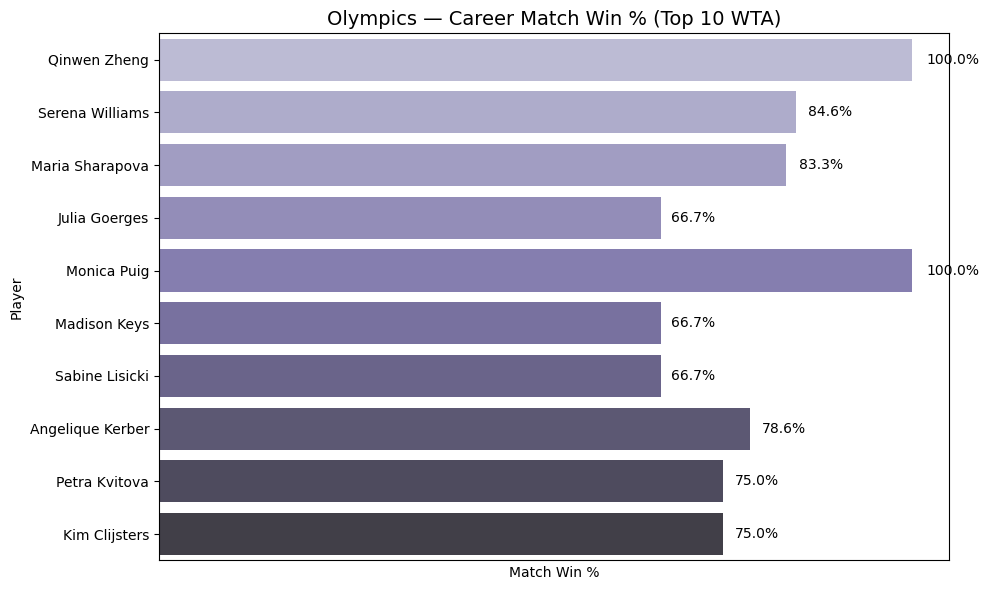

In [23]:
# Filter WTA Olympics matches
olympics_matches_wta = major_matches[
    (major_matches['tourney_name'].str.contains("Olympics", na=False)) |
    (major_matches['tourney_level'] == 'O')  # if available for WTA
].copy()

# Add winner/loser flags for WTA matches
olympics_matches_wta['winner'] = olympics_matches_wta['winner_name']
olympics_matches_wta['loser'] = olympics_matches_wta['loser_name']

# Create player-centric dataset for WTA
winners_df = olympics_matches_wta.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = olympics_matches_wta.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine both sides for WTA
olympics_stats_wta = pd.concat([winners_df, losers_df], ignore_index=True)

# Player performance per Olympic year for WTA
olympics_yearly_wta = olympics_stats_wta.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum')
).reset_index()

# Derived stats for WTA
olympics_yearly_wta['win_pct'] = olympics_yearly_wta['matches_won'] / olympics_yearly_wta['matches_played']
olympics_yearly_wta['1st_win_pct'] = olympics_yearly_wta['total_1st_won'] / olympics_yearly_wta['total_1st_in']
olympics_yearly_wta['1st_win_pct'] = olympics_yearly_wta['1st_win_pct'].fillna(0)

# Normalize metrics for WTA
scaler = MinMaxScaler()

olympics_yearly_wta['aces_norm'] = olympics_yearly_wta.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly_wta['serve_norm'] = olympics_yearly_wta.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly_wta['win_norm'] = olympics_yearly_wta.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# GOAT score = combination of all 3 for WTA
olympics_yearly_wta['GOAT_score'] = (
    olympics_yearly_wta['aces_norm'] +
    olympics_yearly_wta['serve_norm'] +
    olympics_yearly_wta['win_norm']
)

olympics_yearly_wta = olympics_yearly_wta.sort_values(['year', 'GOAT_score'], ascending=[True, False])
olympics_yearly_wta['GOAT_rank'] = olympics_yearly_wta.groupby('year').cumcount() + 1

# Aggregate all Olympic data by player across all years for WTA
olympics_all_time_wta = olympics_yearly_wta.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived stats for WTA
olympics_all_time_wta['career_win_pct'] = olympics_all_time_wta['total_wins'] / olympics_all_time_wta['total_matches']
olympics_all_time_wta['career_1st_win_pct'] = olympics_all_time_wta['total_1st_won'] / olympics_all_time_wta['total_1st_in']

# Normalize all-time metrics for WTA
scaler = MinMaxScaler()
olympics_all_time_wta['aces_norm'] = scaler.fit_transform(olympics_all_time_wta[['total_aces']])
olympics_all_time_wta['serve_norm'] = scaler.fit_transform(olympics_all_time_wta[['career_1st_win_pct']])
olympics_all_time_wta['win_norm'] = scaler.fit_transform(olympics_all_time_wta[['career_win_pct']])

# Combine final GOAT score for WTA
olympics_all_time_wta['GOAT_score'] = (
    olympics_all_time_wta['aces_norm'] +
    olympics_all_time_wta['serve_norm'] +
    olympics_all_time_wta['win_norm'] +
    olympics_all_time_wta['avg_goat_score']
)

olympics_all_time_wta = olympics_all_time_wta.sort_values(by='GOAT_score', ascending=False)
olympics_all_time_wta['GOAT_rank'] = olympics_all_time_wta.reset_index().index + 1

# Take Top 10 for WTA
top10_olympics_wta = olympics_all_time_wta.head(10).copy()

import matplotlib.pyplot as plt
import seaborn as sns

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Olympic Tennis GOAT Score — Top 10 (WTA)", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Win % + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['GOAT_score'], top10_olympics_wta['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Olympics — Total Aces (Top 10 WTA)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['total_aces'], top10_olympics_wta['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Olympics — Career 1st Serve Win % (Top 10 WTA)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['career_1st_win_pct'], top10_olympics_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
top10_olympics_wta['career_win_pct'] = top10_olympics_wta['total_wins'] / top10_olympics_wta['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Olympics — Career Match Win % (Top 10 WTA)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['career_win_pct'], top10_olympics_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
# Group by player to aggregate Olympic performance data for WTA players
olympics_all_time_wta = olympics_yearly_wta.groupby('player').agg(
    total_years = ('year', 'count'),
    total_matches = ('matches_played', 'sum'),
    total_wins = ('matches_won', 'sum'),
    total_aces = ('aces', 'sum'),
    total_1st_won = ('total_1st_won', 'sum'),
    total_1st_in = ('total_1st_in', 'sum'),
    avg_goat_score = ('GOAT_score', 'mean')
).reset_index()

# Calculate career win percentage for WTA players
olympics_all_time_wta['career_win_pct'] = olympics_all_time_wta['total_wins'] / olympics_all_time_wta['total_matches']
olympics_all_time_wta['career_1st_win_pct'] = olympics_all_time_wta['total_1st_won'] / olympics_all_time_wta['total_1st_in']

# Normalize metrics across all WTA players
scaler = MinMaxScaler()
olympics_all_time_wta['aces_norm'] = scaler.fit_transform(olympics_all_time_wta[['total_aces']])
olympics_all_time_wta['serve_norm'] = scaler.fit_transform(olympics_all_time_wta[['career_1st_win_pct']])
olympics_all_time_wta['win_norm'] = scaler.fit_transform(olympics_all_time_wta[['career_win_pct']])

# Combine final GOAT score for WTA
olympics_all_time_wta['GOAT_score'] = (
    olympics_all_time_wta['aces_norm'] +
    olympics_all_time_wta['serve_norm'] +
    olympics_all_time_wta['win_norm'] +
    olympics_all_time_wta['avg_goat_score']
)

# Sort players by GOAT score
olympics_all_time_wta = olympics_all_time_wta.sort_values(by='GOAT_score', ascending=False)
olympics_all_time_wta['GOAT_rank'] = olympics_all_time_wta.reset_index().index + 1

# Display top players for WTA
print("All-Time Olympic Tennis GOAT Rankings (WTA)")
print(olympics_all_time_wta[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 
                             'career_win_pct', 'total_aces', 'career_1st_win_pct', 'GOAT_score']])


All-Time Olympic Tennis GOAT Rankings (WTA)
     GOAT_rank            player  total_years  total_matches  total_wins  \
270          1      Qinwen Zheng            1              6           6   
295          2   Serena Williams            3             13          11   
204          3   Maria Sharapova            1              6           5   
143          4     Julia Goerges            1              3           2   
229          5       Monica Puig            1              6           6   
..         ...               ...          ...            ...         ...   
345        346  Yulia Putintseva            1              1           0   
346        347     Yung Jan Chan            1              1           0   
347        348      Zarina Diyas            1              1           0   
348        349            Zi Yan            1              1           0   
349        350     Zina Garrison            1              1           0   

     career_win_pct  total_aces  career_1st

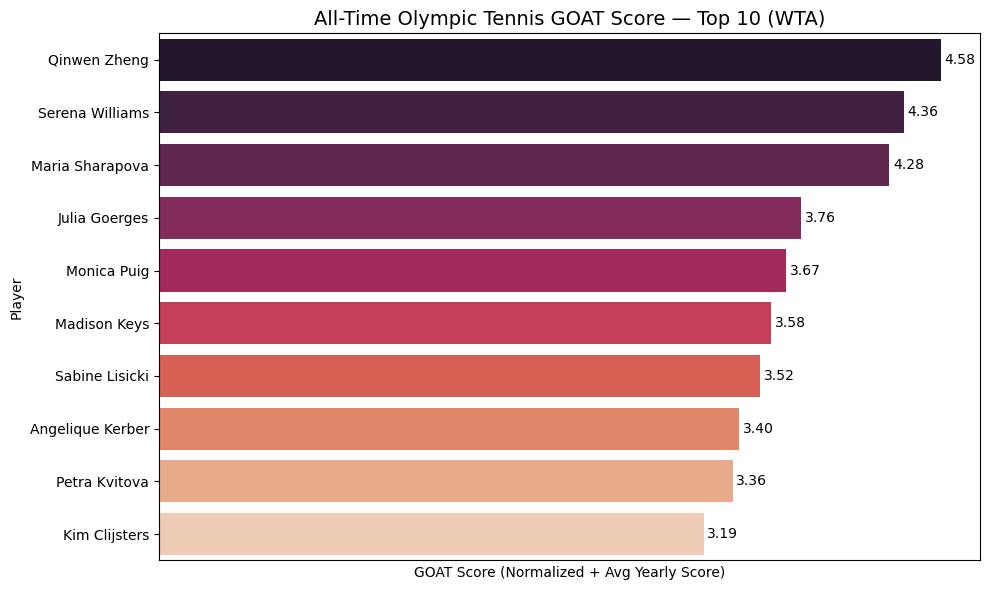

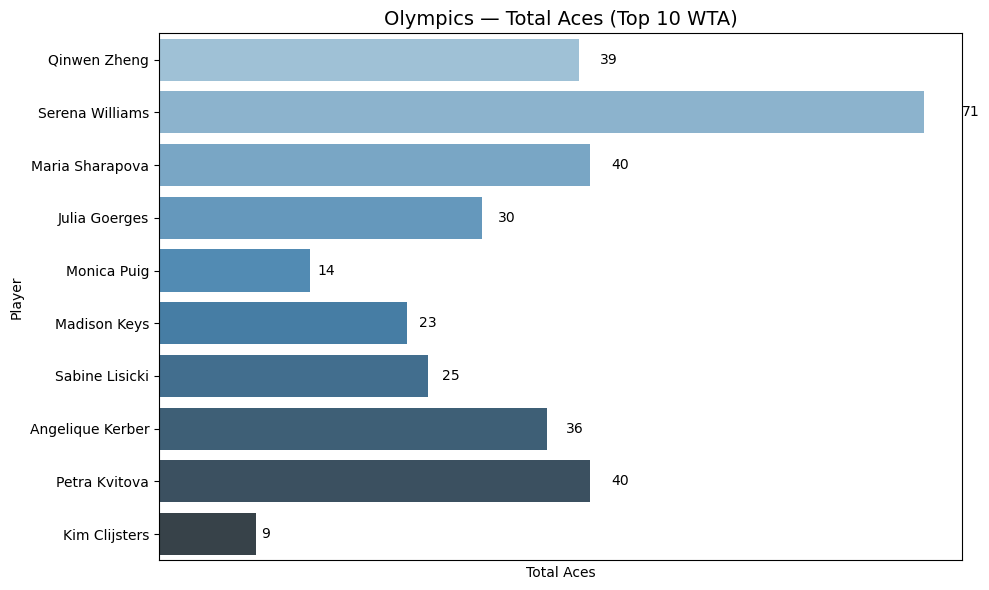

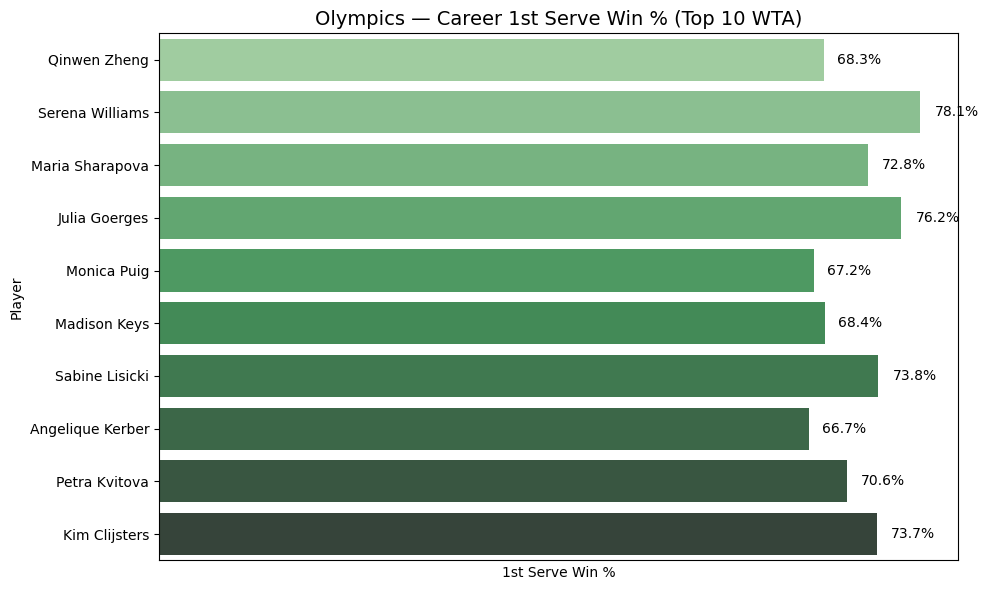

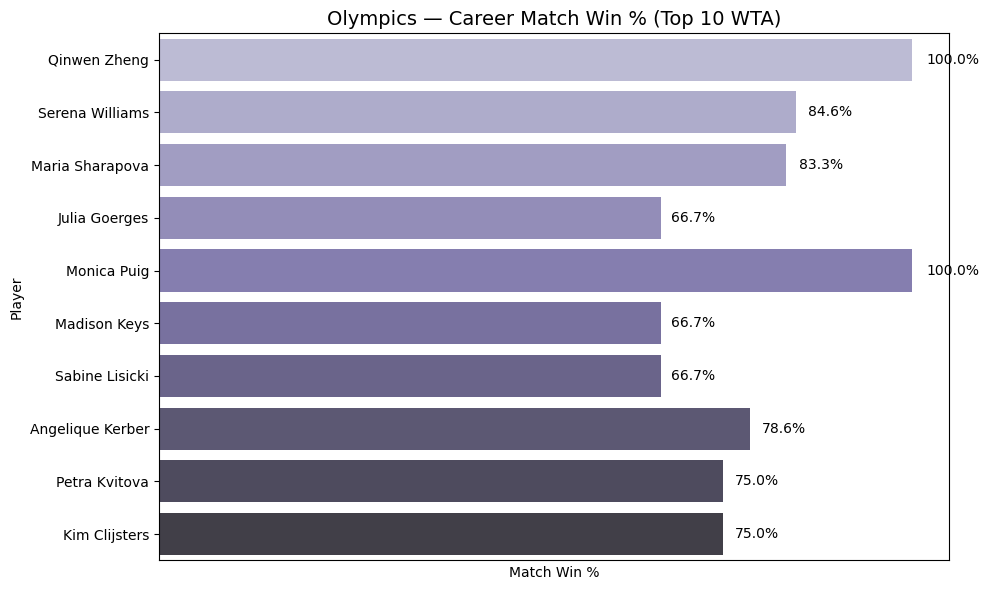

In [26]:
# Take top 10 all-time Olympic GOATs for WTA
top10_olympics_wta = olympics_all_time_wta.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Olympic Tennis GOAT Score — Top 10 (WTA)", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['GOAT_score'], top10_olympics_wta['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Olympics — Total Aces (Top 10 WTA)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['total_aces'], top10_olympics_wta['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Olympics — Career 1st Serve Win % (Top 10 WTA)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['career_1st_win_pct'], top10_olympics_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
top10_olympics_wta['career_win_pct'] = top10_olympics_wta['total_wins'] / top10_olympics_wta['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics_wta, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Olympics — Career Match Win % (Top 10 WTA)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics_wta['career_win_pct'], top10_olympics_wta['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
# Filter matches for WTA 1000 tournaments
masters_matches_wta = major_matches[major_matches['tourney_level'] == 'W'].copy()

# Add outcome flags
masters_matches_wta['winner'] = masters_matches_wta['winner_name']
masters_matches_wta['loser'] = masters_matches_wta['loser_name']

# Create player-centric dataset
winners_df_wta = masters_matches_wta.copy()
winners_df_wta['player'] = winners_df_wta['winner']
winners_df_wta['won'] = 1

losers_df_wta = masters_matches_wta.copy()
losers_df_wta['player'] = losers_df_wta['loser']
losers_df_wta['won'] = 0

# Combine both winner and loser data
masters_stats_wta = pd.concat([winners_df_wta, losers_df_wta], ignore_index=True)

# Group by player to get yearly performance data
masters_yearly_wta = masters_stats_wta.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum')
).reset_index()

# Calculate win percentage and first serve win percentage
masters_yearly_wta['win_pct'] = masters_yearly_wta['matches_won'] / masters_yearly_wta['matches_played']
masters_yearly_wta['1st_win_pct'] = masters_yearly_wta['total_1st_won'] / masters_yearly_wta['total_1st_in']
masters_yearly_wta['1st_win_pct'] = masters_yearly_wta['1st_win_pct'].fillna(0)

# Normalize metrics per year
scaler = MinMaxScaler()

masters_yearly_wta['aces_norm'] = masters_yearly_wta.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
masters_yearly_wta['serve_norm'] = masters_yearly_wta.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
masters_yearly_wta['win_norm'] = masters_yearly_wta.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Combine the metrics to calculate the final GOAT score
masters_yearly_wta['GOAT_score'] = (
    masters_yearly_wta['aces_norm'] +
    masters_yearly_wta['serve_norm'] +
    masters_yearly_wta['win_norm']
)

# Sort players by GOAT score and rank them
masters_yearly_wta = masters_yearly_wta.sort_values(['year', 'GOAT_score'], ascending=[True, False])
masters_yearly_wta['GOAT_rank'] = masters_yearly_wta.groupby('year').cumcount() + 1

# Get the range of years
start_year_wta = masters_yearly_wta['year'].min()
end_year_wta = masters_yearly_wta['year'].max()

# Print the results
print(f"WTA Masters 1000 GOAT Rankings ({start_year_wta}–{end_year_wta}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(masters_yearly_wta[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])


WTA Masters 1000 GOAT Rankings (1990–2024) — Based on Match Wins, Aces, and 1st Serve Win %
      year                 player  matches_played  matches_won  aces  \
287   1990            Steffi Graf              50           48   0.0   
212   1990           Monica Seles              46           42   0.0   
199   1990    Martina Navratilova              48           42   0.0   
65    1990      Conchita Martinez              40           32   0.0   
216   1990        Naoko Sawamatsu              15           12   0.0   
...    ...                    ...             ...          ...   ...   
3079  2024      Varvara Lepchenko               1            0   1.0   
3080  2024         Victoria Bosio               1            0   0.0   
3075  2024       Robin Montgomery               1            0   0.0   
3070  2024    Nicole Fossa Huergo               1            0   1.0   
3069  2024  Miriam Bianca Bulgaru               1            0   1.0   

      1st_win_pct   win_pct  GOAT_score  GO

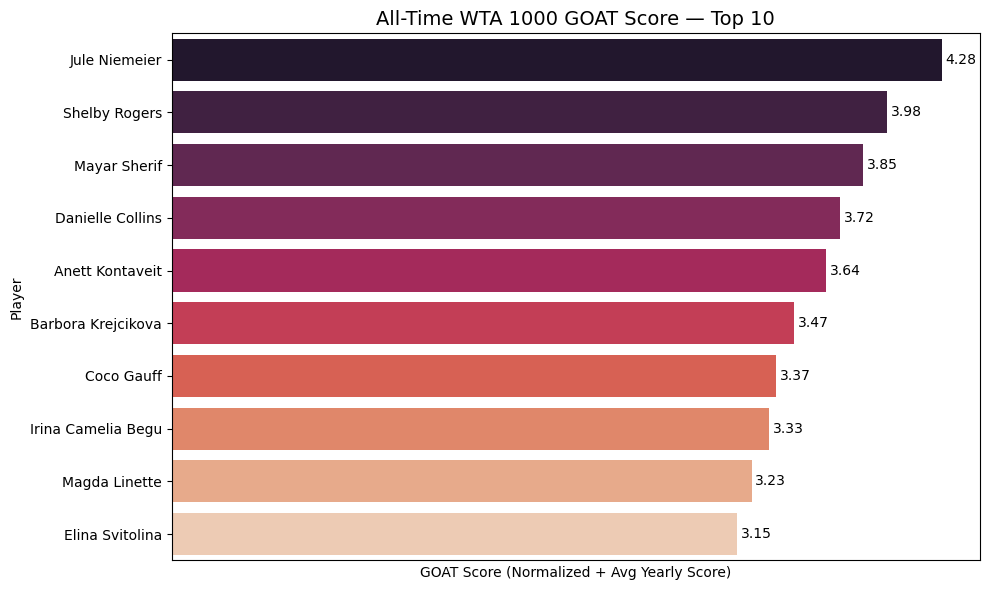

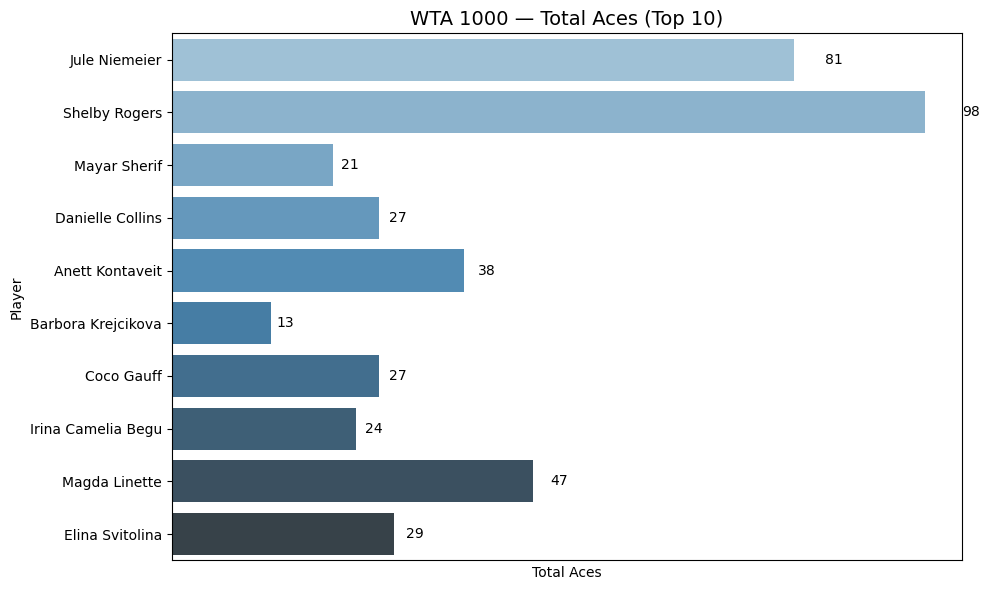

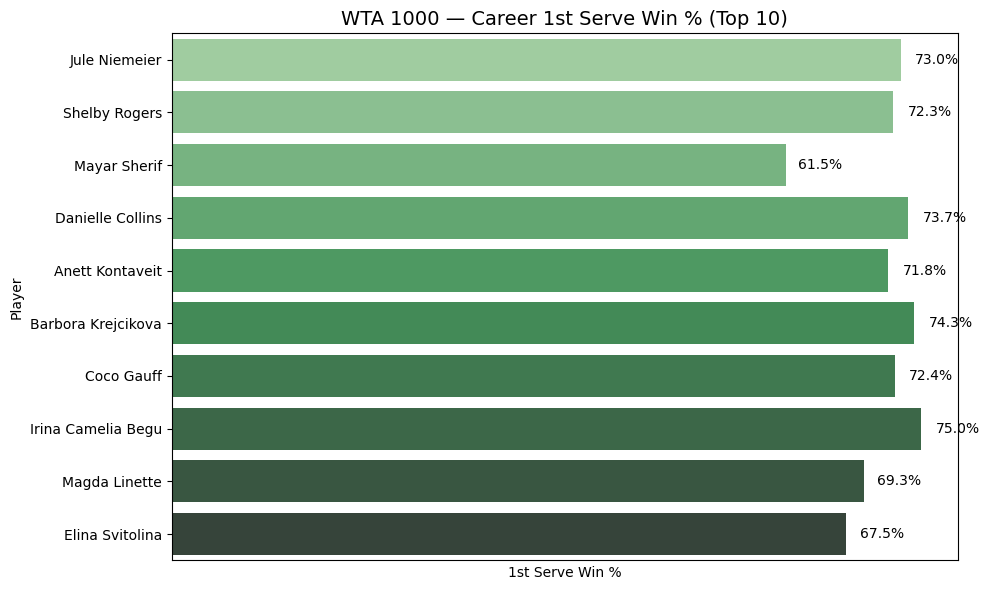

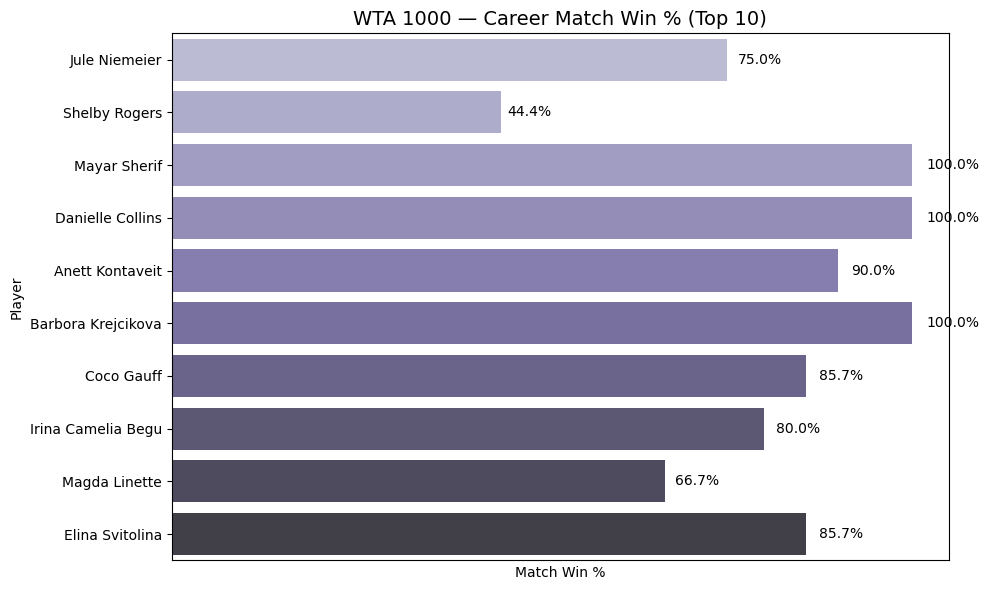

In [33]:
# Filter matches for WTA 1000 tournaments (T5 corresponds to WTA 1000)
wta_1000_matches = major_matches[major_matches['tourney_level'] == 'W'].copy()

# Add outcome flags
wta_1000_matches['winner'] = wta_1000_matches['winner_name']
wta_1000_matches['loser'] = wta_1000_matches['loser_name']

# Create player-centric dataset
winners_df = wta_1000_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = wta_1000_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine both sides
wta_1000_stats = pd.concat([winners_df, losers_df], ignore_index=True)

# Aggregate per year for WTA 1000
wta_1000_yearly = wta_1000_stats.groupby(['year', 'player']).agg(
    matches_played=('won', 'count'),
    matches_won=('won', 'sum'),
    aces=('w_ace', 'sum'),
    total_1st_in=('w_1stIn', 'sum'),
    total_1st_won=('w_1stWon', 'sum')
).reset_index()

wta_1000_yearly['win_pct'] = wta_1000_yearly['matches_won'] / wta_1000_yearly['matches_played']
wta_1000_yearly['1st_win_pct'] = wta_1000_yearly['total_1st_won'] / wta_1000_yearly['total_1st_in']
wta_1000_yearly['1st_win_pct'] = wta_1000_yearly['1st_win_pct'].fillna(0)

scaler = MinMaxScaler()

# Normalize per year
wta_1000_yearly['aces_norm'] = wta_1000_yearly.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
wta_1000_yearly['serve_norm'] = wta_1000_yearly.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
wta_1000_yearly['win_norm'] = wta_1000_yearly.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

wta_1000_yearly['GOAT_score'] = (
    wta_1000_yearly['aces_norm'] +
    wta_1000_yearly['serve_norm'] +
    wta_1000_yearly['win_norm']
)

wta_1000_yearly = wta_1000_yearly.sort_values(['year', 'GOAT_score'], ascending=[True, False])
wta_1000_yearly['GOAT_rank'] = wta_1000_yearly.groupby('year').cumcount() + 1

# Aggregate all-time stats for WTA 1000
wta_1000_all_time = wta_1000_yearly.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived career stats
wta_1000_all_time['career_win_pct'] = wta_1000_all_time['total_wins'] / wta_1000_all_time['total_matches']
wta_1000_all_time['career_1st_win_pct'] = wta_1000_all_time['total_1st_won'] / wta_1000_all_time['total_1st_in']

# Normalize across all players
scaler = MinMaxScaler()
wta_1000_all_time['aces_norm'] = scaler.fit_transform(wta_1000_all_time[['total_aces']])
wta_1000_all_time['serve_norm'] = scaler.fit_transform(wta_1000_all_time[['career_1st_win_pct']])
wta_1000_all_time['win_norm'] = scaler.fit_transform(wta_1000_all_time[['career_win_pct']])

# Final GOAT Score
wta_1000_all_time['GOAT_score'] = (
    wta_1000_all_time['aces_norm'] +
    wta_1000_all_time['serve_norm'] +
    wta_1000_all_time['win_norm'] +
    wta_1000_all_time['avg_goat_score']
)

# Rank
wta_1000_all_time = wta_1000_all_time.sort_values(by='GOAT_score', ascending=False)
wta_1000_all_time['GOAT_rank'] = wta_1000_all_time.reset_index().index + 1

# Top 10
top10_wta_1000 = wta_1000_all_time.head(10).copy()

import matplotlib.pyplot as plt
import seaborn as sns

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time WTA 1000 GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['GOAT_score'], top10_wta_1000['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("WTA 1000 — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['total_aces'], top10_wta_1000['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("WTA 1000 — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['career_1st_win_pct'], top10_wta_1000['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("WTA 1000 — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['career_win_pct'], top10_wta_1000['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [35]:
# Filter for WTA 1000 matches (tourney_level = 'T5')
wta_1000_matches = major_matches[major_matches['tourney_level'] == 'W'].copy()

# Add outcome flags
wta_1000_matches['winner'] = wta_1000_matches['winner_name']
wta_1000_matches['loser'] = wta_1000_matches['loser_name']

# Create player-centric dataset
winners_df = wta_1000_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = wta_1000_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine both sides
wta_1000_stats = pd.concat([winners_df, losers_df], ignore_index=True)

# Aggregate per year for WTA 1000
wta_1000_yearly = wta_1000_stats.groupby(['year', 'player']).agg(
    matches_played=('won', 'count'),
    matches_won=('won', 'sum'),
    aces=('w_ace', 'sum'),
    total_1st_in=('w_1stIn', 'sum'),
    total_1st_won=('w_1stWon', 'sum')
).reset_index()

# Derived stats
wta_1000_yearly['win_pct'] = wta_1000_yearly['matches_won'] / wta_1000_yearly['matches_played']
wta_1000_yearly['1st_win_pct'] = wta_1000_yearly['total_1st_won'] / wta_1000_yearly['total_1st_in']
wta_1000_yearly['1st_win_pct'] = wta_1000_yearly['1st_win_pct'].fillna(0)

# Normalize across all players for WTA 1000
scaler = MinMaxScaler()

wta_1000_yearly['aces_norm'] = wta_1000_yearly.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
wta_1000_yearly['serve_norm'] = wta_1000_yearly.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
wta_1000_yearly['win_norm'] = wta_1000_yearly.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

wta_1000_yearly['GOAT_score'] = (
    wta_1000_yearly['aces_norm'] +
    wta_1000_yearly['serve_norm'] +
    wta_1000_yearly['win_norm']
)

wta_1000_yearly = wta_1000_yearly.sort_values(['year', 'GOAT_score'], ascending=[True, False])
wta_1000_yearly['GOAT_rank'] = wta_1000_yearly.groupby('year').cumcount() + 1

# Aggregate all-time stats for WTA 1000
wta_1000_all_time = wta_1000_yearly.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived career stats for WTA 1000
wta_1000_all_time['career_win_pct'] = wta_1000_all_time['total_wins'] / wta_1000_all_time['total_matches']
wta_1000_all_time['career_1st_win_pct'] = wta_1000_all_time['total_1st_won'] / wta_1000_all_time['total_1st_in']

# Normalize across all players for WTA 1000
scaler = MinMaxScaler()
wta_1000_all_time['aces_norm'] = scaler.fit_transform(wta_1000_all_time[['total_aces']])
wta_1000_all_time['serve_norm'] = scaler.fit_transform(wta_1000_all_time[['career_1st_win_pct']])
wta_1000_all_time['win_norm'] = scaler.fit_transform(wta_1000_all_time[['career_win_pct']])

# Final GOAT Score for WTA 1000
wta_1000_all_time['GOAT_score'] = (
    wta_1000_all_time['aces_norm'] +
    wta_1000_all_time['serve_norm'] +
    wta_1000_all_time['win_norm'] +
    wta_1000_all_time['avg_goat_score']
)

# Rank players for WTA 1000
wta_1000_all_time = wta_1000_all_time.sort_values(by='GOAT_score', ascending=False)
wta_1000_all_time['GOAT_rank'] = wta_1000_all_time.reset_index().index + 1

# Top 10 WTA 1000
top10_wta_1000 = wta_1000_all_time.head(10).copy()

# Display the final rankings
print("All-Time WTA 1000 GOAT Rankings")
print(wta_1000_all_time[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 'career_win_pct', 'total_aces', 'career_1st_win_pct', 'GOAT_score']])


All-Time WTA 1000 GOAT Rankings
      GOAT_rank            player  total_years  total_matches  total_wins  \
424           1     Jule Niemeier            1              4           3   
875           2     Shelby Rogers            1              9           4   
655           3      Mayar Sherif            1              5           5   
217           4  Danielle Collins            1              5           5   
68            5   Anett Kontaveit            1             10           9   
...         ...               ...          ...            ...         ...   
1008       1009    Zdenka Malkova            2              4           1   
1009       1010     Zina Garrison            7            252         160   
1010       1011    Zsofia Gubacsi            2              2           0   
1011       1012    Zuzana Hejdova            1              1           0   
1012       1013  Zuzana Nemsakova            1              1           0   

      career_win_pct  total_aces  career_1s

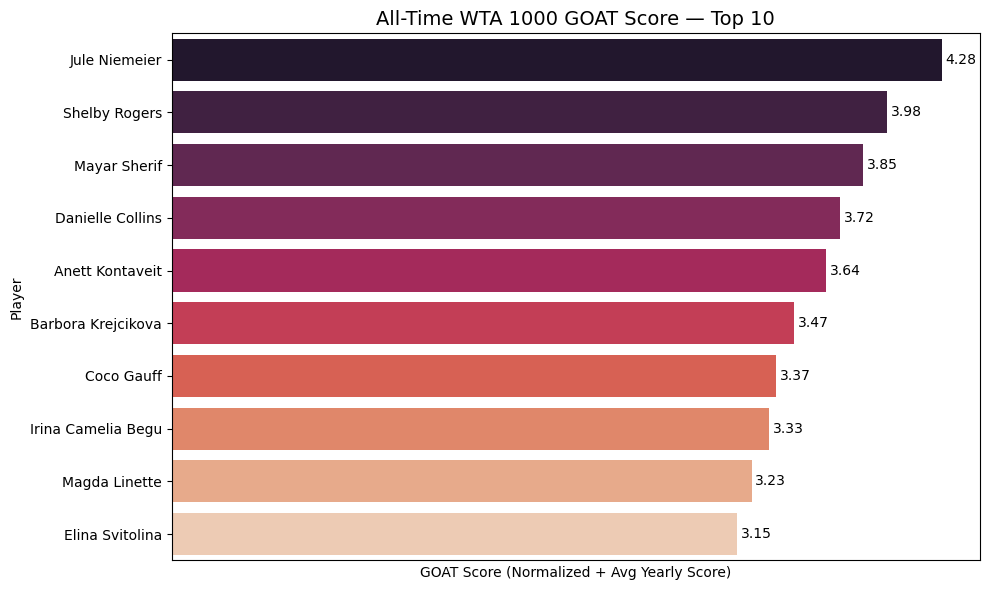

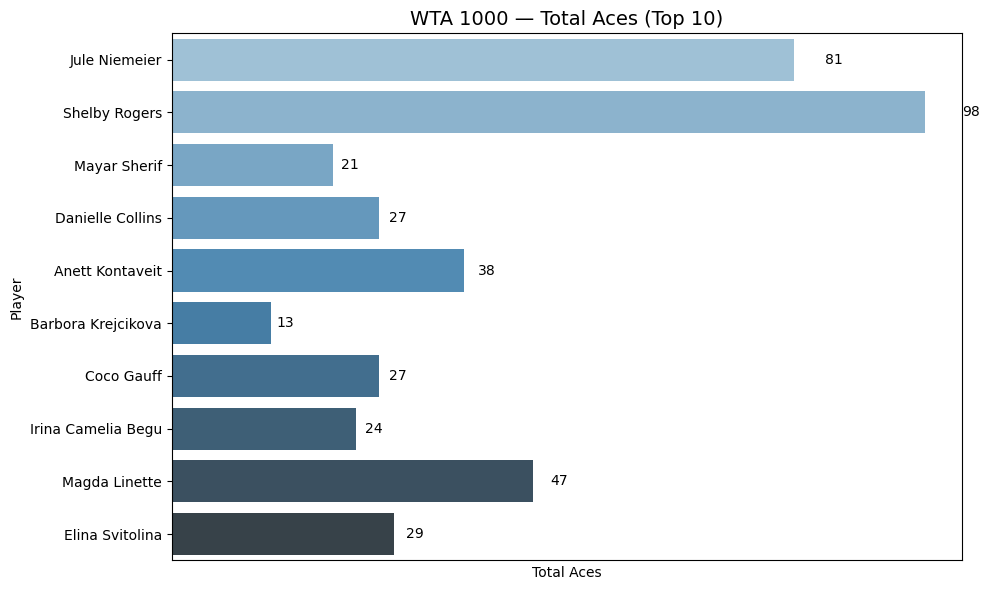

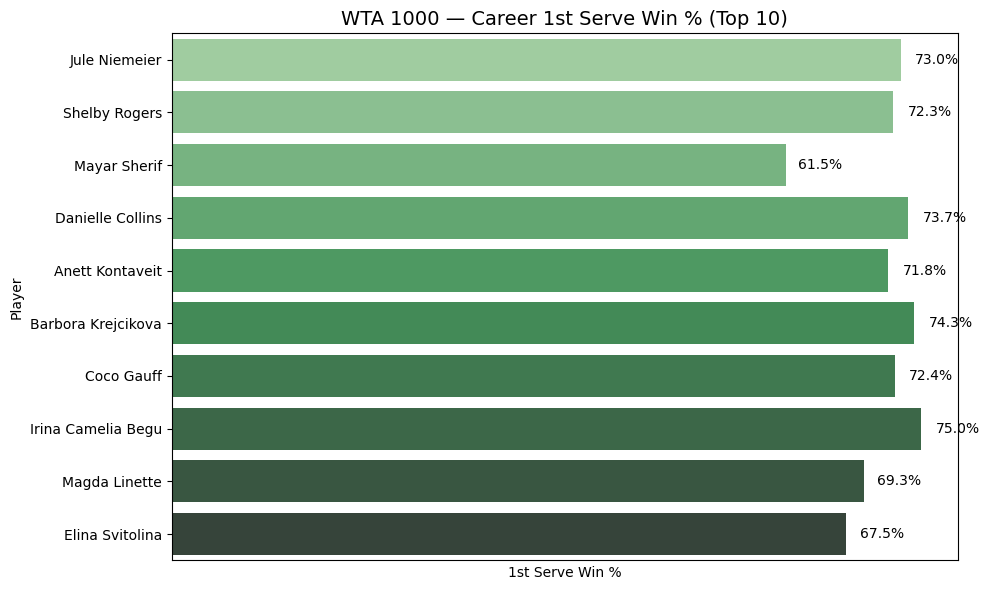

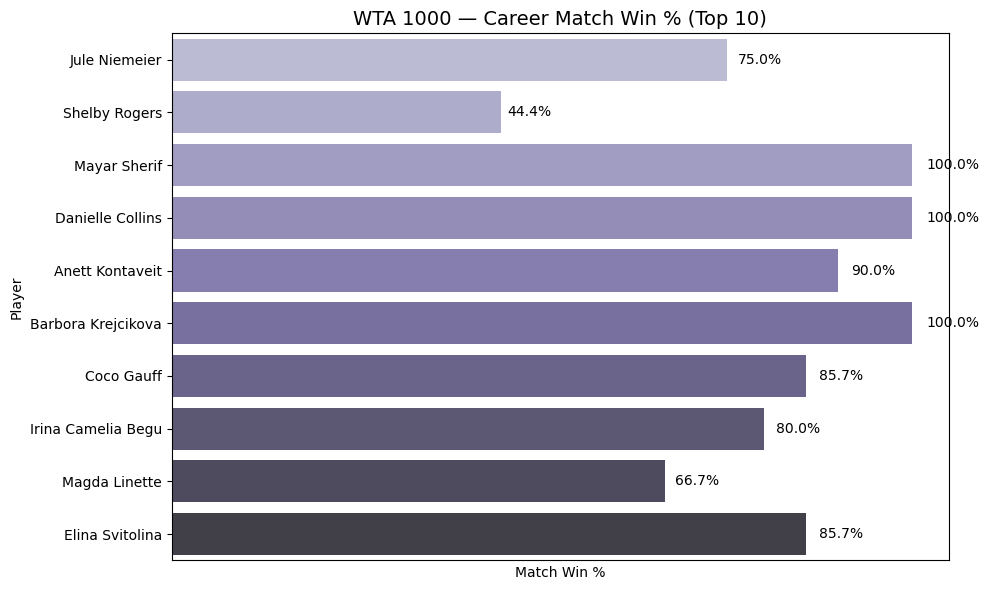

In [36]:
# Select top 10 GOATs from WTA 1000 tournaments
top10_wta_1000 = wta_1000_all_time.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time WTA 1000 GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['GOAT_score'], top10_wta_1000['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("WTA 1000 — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['total_aces'], top10_wta_1000['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("WTA 1000 — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['career_1st_win_pct'], top10_wta_1000['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career Match Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_wta_1000, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("WTA 1000 — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_wta_1000['career_win_pct'], top10_wta_1000['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
